# <div align="center">Project: Tỷ lệ khách hàng rời bỏ: Nghiên cứu các nhân tố quyết định tỷ lệ khách hàng rút tiền tại Ngân hàng sử dụng các thuật toán Machine Learning</div>

# Giới thiệu chung về bộ dữ liệu thô:
## I. Về bộ dữ liệu:
#### 1. Sao kê hằng ngày:
Dữ liệu được cung cấp là các ***SAO KÊ*** hằng ngày của từng khách hàng tại một chi nhánh ngân hàng trên địa bàn Tp Hồ Chí Minh.  Do đó, bộ dữ liệu có chứa các thông tin cơ bản để định danh khách hàng như *ngày giao dịch, mã khách hàng, loại khách hàng*. Ngoài ra bộ dữ liệu còn chứa thông tin về sao kê nguồn vốn và nợ vay của từng tài khoản của khách hàng như: *số tài khoản, số dư cuối ngày, nơi mở, ngày mở, loại hình mở, người quản lý..*

Dữ liệu có khung thời gian từ 01/01/2018 - 31/12/2019. Trong một ngày có xấp xỉ 60.000 dòng tương đương với 60.000 tài khoản tiền gửi và dư nợ. Một khách hàng có thể có nhiều tài khoản nhưng chỉ có duy nhất một mã khách hàng để định danh.
#### 2. Thông tin khách hàng:
Dữ liệu cung cấp là ***THÔNG TIN*** cơ bản của một khách hàng như: *mã khách hàng, ngày khởi tạo, tên khách hàng, số đt, địa chỉ, giới tính...*
## II. Cách xử lý và lựa chọn mô hình.
Vì bộ dữ liệu lớn nên học viên sử dụng Spark để xử lý và tổng hợp dữ liệu thành một bộ dữ liệu duy nhất bao gồm thông tin của khách hàng để dự đoán khả năng khách hàng còn/không còn gửi tiền.

## PHỤ LỤC
* [PHẦN 1: ĐỌC - GHI BỘ DỮ LIỆU THÔ](#part1)
* [PHẦN 2: ĐỌC INFO](#part2)
* [PHẦN 3: ĐỌC STATEMENT](#part3)
* [PHẦN 4: GÁN NHÃN](#part4)
* [PHẦN 5: MODELLING](#part5)

# LƯu Ý: Bộ dữ liệu thô có liên quan đến bảo mật thông tin khách hàng nên tác giả chỉ cung cấp bộ dữ liệu đã mã hóa để chạy[ Phần 5: Modelling](#part5).

# PHẦN 1: ĐỌC - GHI BỘ DỮ LIỆU THÔ <a name="part1"></a>

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession


from pyspark.sql.functions import col, when, count, isnull, isnan, udf, collect_set, trim
from pyspark.sql.functions import explode, lit, coalesce, first, concat, mean, round
from pyspark.sql.functions import dayofmonth, month, year

from pyspark.sql.types import DateType, StringType

from datetime import datetime

import time

# This is for recreating new columns
from functools import reduce

import pandas as pd
import numpy as np 

# Clean up memory
import gc

In [2]:
spark = SparkSession.builder.appName('project_churn').getOrCreate()

In [ ]:
t1 = time.perf_counter()
state_data = spark.read.csv('./Customer Churn & Segmentation/Raw data/unzipped_datas/SAOKE',
                            header=False, inferSchema=True)
t2 = time.perf_counter()

In [5]:
print('Time reading: ', (t2-t1)/60, 'mins.')

Time reading:  4.654111023333333 mins.


In [6]:
t1 = time.perf_counter()
print(state_data.count())
t2 = time.perf_counter()

39965359


In [7]:
print('Time reading: ', (t2-t1)/60, 'mins.')

Time reading:  4.301461791666667 mins.


In [ ]:
# Read header of state_data
header_state_data = pd.read_excel('./Customer Churn & Segmentation/Header/TBMS_SAOKE.xlsx')

In [9]:
str(header_state_data.columns.to_list())

"['NgayGD', 'MaCN', 'LoaiTien', 'MaTK', 'MaKH', 'SoTT', 'SoDuDau', 'SoDuCuoi', 'MaGD', 'SoGD', 'NghiepVu', 'NghiepVuChiTiet', 'MaLSCoBan', 'LSCoBan', 'ChenhLech', 'LaiSuat', 'DuThu/DuChi', 'NgayMo', 'NgayDH', 'NgayDong', 'NgayTraLaiTiep', 'NgayTraGocTiep', 'SoTraGocTiep', 'CachTinhLai', 'CachTraLai', 'CachTinhKyHanTra', 'Unnamed: 26', 'SoNgayTrongNam', 'CoCauNo', 'SoTKThamChieu', 'LoaiKyHanNgayVayLai', 'DSThuNoGocXLRR', 'DSNoGoc', 'LaiDuThu/ChiCuoiThang', 'KyHan', 'LaiQuaHan', 'GhiChu', 'LoaiHachToan', 'SoTienNo', 'SoTienCo', 'PGD', 'MaCNGD', 'CoQuaHan', 'TKMoi', 'TiGiaCB', 'TPKinhTe', 'LoaiKH', 'MaQG', 'TiGiaCuoiThang', 'MaPhongBan', 'TKhoanNHNN', 'LoaiNguocGocVay', 'CoLapLaiLichVay', 'LiDoNoXau', 'TinhTrangKhoanVay', 'SoTienVayTrongHopDong', 'LoaiHinhKte', 'KyHanVay', 'TenKH', 'CoDamBaoTSan', 'LyDoBaoDam', 'MaNguonVon', 'PhanLoaiNo', 'LoaiVay', 'MaHopDong', 'SoHopDong', 'NgayTraNoCuoi', 'NgayGiaHan', 'LaiTuNgayDenNgay', 'LoaiKHChiTiet', 'LoaiDN', 'ThuLaiTrongHan', 'ThuLaiQuaHan', 'Un

In [10]:
header_state_data

NgayGD  MaCN LoaiTien    MaTK    MaKH  SoTT  SoDuDau  SoDuCuoi  MaGD  \
0  20171231  1600      AUD  431101  502565     1    61.68     61.68   205   
1  20171231  1600      EUR  431101  503179     1   163.09    163.09   201   

    SoGD  ... MaHopDong  SoHopDong  NgayTraNoCuoi  NgayGiaHan  \
0  28542  ...            200734962       20171231               
1  16358  ...            200904250       20171231               

   LaiTuNgayDenNgay  LoaiKHChiTiet  LoaiDN  ThuLaiTrongHan  ThuLaiQuaHan  \
0                              101       0               0             0   
1                              521       2               0             0   

   Unused  
0       1  
1       1  

[2 rows x 74 columns]

In [11]:
newColumns = header_state_data.columns.to_list()
oldColumns = state_data.columns

In [12]:
# Change columns name
state_data = reduce(lambda state_data, idx: state_data.withColumnRenamed(oldColumns[idx], newColumns[idx]), 
                 range(len(oldColumns)), state_data) 

In [13]:
state_data.show(1)

+--------+----+--------+------+-------+----+-------+--------+----+----+--------+---------------+---------+-------+---------+-------+-----------+--------+--------+--------+--------------+--------------+------------+-----------+----------+----------------+-----------+--------------+-------------+-------------+-------------------+--------------+-------+---------------------+-----+---------+--------+------------+--------+--------+---+------+--------+------+-------+--------+------+----+--------------+----------+----------+---------------+---------------+---------+-----------------+---------------------+-----------+--------+---------------+------------+----------+----------+----------+-------+---------+---------+-------------+----------+----------------+-------------+------+--------------+------------+------+
|  NgayGD|MaCN|LoaiTien|  MaTK|   MaKH|SoTT|SoDuDau|SoDuCuoi|MaGD|SoGD|NghiepVu|NghiepVuChiTiet|MaLSCoBan|LSCoBan|ChenhLech|LaiSuat|DuThu/DuChi|  NgayMo|  NgayDH|NgayDong|NgayTraLaiTiep

In [14]:
str(state_data.columns)

"['NgayGD', 'MaCN', 'LoaiTien', 'MaTK', 'MaKH', 'SoTT', 'SoDuDau', 'SoDuCuoi', 'MaGD', 'SoGD', 'NghiepVu', 'NghiepVuChiTiet', 'MaLSCoBan', 'LSCoBan', 'ChenhLech', 'LaiSuat', 'DuThu/DuChi', 'NgayMo', 'NgayDH', 'NgayDong', 'NgayTraLaiTiep', 'NgayTraGocTiep', 'SoTraGocTiep', 'CachTinhLai', 'CachTraLai', 'CachTinhKyHanTra', 'Unnamed: 26', 'SoNgayTrongNam', 'CoCauNo', 'SoTKThamChieu', 'LoaiKyHanNgayVayLai', 'DSThuNoGocXLRR', 'DSNoGoc', 'LaiDuThu/ChiCuoiThang', 'KyHan', 'LaiQuaHan', 'GhiChu', 'LoaiHachToan', 'SoTienNo', 'SoTienCo', 'PGD', 'MaCNGD', 'CoQuaHan', 'TKMoi', 'TiGiaCB', 'TPKinhTe', 'LoaiKH', 'MaQG', 'TiGiaCuoiThang', 'MaPhongBan', 'TKhoanNHNN', 'LoaiNguocGocVay', 'CoLapLaiLichVay', 'LiDoNoXau', 'TinhTrangKhoanVay', 'SoTienVayTrongHopDong', 'LoaiHinhKte', 'KyHanVay', 'TenKH', 'CoDamBaoTSan', 'LyDoBaoDam', 'MaNguonVon', 'PhanLoaiNo', 'LoaiVay', 'MaHopDong', 'SoHopDong', 'NgayTraNoCuoi', 'NgayGiaHan', 'LaiTuNgayDenNgay', 'LoaiKHChiTiet', 'LoaiDN', 'ThuLaiTrongHan', 'ThuLaiQuaHan', 'Un

### *Nhận xét*:

1. Đây là sao kê hằng ngày cả nguồn vốn và dư nợ vay của khách hàng, do đó ta chỉ lựa chọn cấc thuộc tính có liên quan đến nguồn vốn, và bỏ các thuộc tính của dư nợ vay và không liên quan khác.
2. Lọc lại các cột (biến) không mang ý nghĩa trong mô hình.

In [15]:
state_data.printSchema()

root
 |-- NgayGD: integer (nullable = true)
 |-- MaCN: integer (nullable = true)
 |-- LoaiTien: string (nullable = true)
 |-- MaTK: integer (nullable = true)
 |-- MaKH: integer (nullable = true)
 |-- SoTT: double (nullable = true)
 |-- SoDuDau: double (nullable = true)
 |-- SoDuCuoi: double (nullable = true)
 |-- MaGD: string (nullable = true)
 |-- SoGD: integer (nullable = true)
 |-- NghiepVu: string (nullable = true)
 |-- NghiepVuChiTiet: string (nullable = true)
 |-- MaLSCoBan: string (nullable = true)
 |-- LSCoBan: double (nullable = true)
 |-- ChenhLech: double (nullable = true)
 |-- LaiSuat: double (nullable = true)
 |-- DuThu/DuChi: double (nullable = true)
 |-- NgayMo: integer (nullable = true)
 |-- NgayDH: string (nullable = true)
 |-- NgayDong: integer (nullable = true)
 |-- NgayTraLaiTiep: integer (nullable = true)
 |-- NgayTraGocTiep: integer (nullable = true)
 |-- SoTraGocTiep: double (nullable = true)
 |-- CachTinhLai: string (nullable = true)
 |-- CachTraLai: string (nul

In [17]:
state_data = state_data.withColumn('PGD', (when(col('MaCN') == 1609, '08')
                                          .otherwise(col('PGD'))))

In [18]:
state_data.groupby('PGD').count().show()

+---+--------+
|PGD|   count|
+---+--------+
| 07| 2123062|
| 01|     333|
|   |    2749|
| 00|21088179|
| 05| 1910286|
| 08| 2234584|
| 03| 8055835|
| 02| 3195761|
| 06| 1352023|
| 04|    2547|
+---+--------+



In [19]:
del_col_statement = ['MaCN', 'MaTK','SoTT','SoDuDau','SoGD', 'NghiepVu', 'MaLSCoBan', 
                     'LSCoBan', 'ChenhLech', 'DuThu/DuChi','NgayMo', 'NgayDH', 'NgayDong', 
                     'NgayTraLaiTiep', 'NgayTraGocTiep', 'SoTraGocTiep','CachTraLai', 
                     'CachTinhKyHanTra', 'Unnamed: 26', 'SoNgayTrongNam', 'CoCauNo', 
                     'SoTKThamChieu', 'LoaiKyHanNgayVayLai', 'DSThuNoGocXLRR', 'DSNoGoc', 
                     'LaiDuThu/ChiCuoiThang', 'LaiQuaHan', 'GhiChu', 'LoaiHachToan', 
                     'SoTienNo', 'SoTienCo','MaCNGD', 'CoQuaHan','TKMoi','TiGiaCB','MaQG', 
                     'TiGiaCuoiThang', 'MaPhongBan', 'TKhoanNHNN', 'LoaiNguocGocVay', 
                     'CoLapLaiLichVay', 'LiDoNoXau', 'TinhTrangKhoanVay', 
                     'SoTienVayTrongHopDong', 'LoaiHinhKte', 'KyHanVay', 'TenKH', 
                     'CoDamBaoTSan', 'LyDoBaoDam','MaNguonVon', 'PhanLoaiNo', 'LoaiVay', 
                     'MaHopDong', 'SoHopDong', 'NgayTraNoCuoi', 'NgayGiaHan', 'LaiTuNgayDenNgay',
                     'LoaiDN','ThuLaiTrongHan', 'ThuLaiQuaHan', 'Unused']

In [20]:
state_data_0 = state_data.select('*')

In [21]:
for i in del_col_statement:
    state_data_0 = state_data_0.drop(i)

In [22]:
state_data_0.printSchema()

root
 |-- NgayGD: integer (nullable = true)
 |-- LoaiTien: string (nullable = true)
 |-- MaKH: integer (nullable = true)
 |-- SoDuCuoi: double (nullable = true)
 |-- MaGD: string (nullable = true)
 |-- NghiepVuChiTiet: string (nullable = true)
 |-- LaiSuat: double (nullable = true)
 |-- CachTinhLai: string (nullable = true)
 |-- KyHan: double (nullable = true)
 |-- PGD: string (nullable = true)
 |-- TPKinhTe: integer (nullable = true)
 |-- LoaiKH: string (nullable = true)
 |-- LoaiKHChiTiet: string (nullable = true)



In [23]:
state_data_0['NgayGD']

Column<b'NgayGD'>

In [24]:
for c in state_data_0.columns:
    state_data_0.groupby(c).count().show(5)

+--------+-----+
|  NgayGD|count|
+--------+-----+
|20191119|71290|
|20190628|68668|
|20190228|66970|
|20180615|63751|
|20190810|68956|
|20190713|68626|
|20180301|65636|
|20180420|64987|
|20190909|69453|
|20180125|67256|
|20181105|64688|
|20180705|63370|
|20180915|62983|
|20190625|68598|
|20190517|68141|
|20190424|67823|
|20181230|65745|
|20180604|63644|
|20190910|69513|
|20190916|69658|
+--------+-----+
only showing top 20 rows

+--------+--------+
|LoaiTien|   count|
+--------+--------+
|     EUR|   21927|
|     AUD|     599|
|     JPY|    2152|
|     USD|  357572|
|     VND|39582510|
|     SGD|     599|
+--------+--------+

+---------+-----+
|     MaKH|count|
+---------+-----+
|  2868080| 1672|
|  6994796| 6042|
|281769978|  600|
|185587305|  599|
|380595719|   37|
|339008032|  512|
|160311535|  599|
|309994017|  599|
|130435777|  599|
|192382659|  599|
|301842177|  599|
|330003168|  599|
| 13558434|  599|
|  4393766|  599|
|  9655224|   62|
|234749228|  599|
|275777054|  599|
|2757

In [25]:
# # Saving headers
# pd.DataFrame(state_data_0.columns).to_csv('headers_statement.csv')

### Sau khi đã lựa chọn dữ liệu từ bộ dữ liệu gốc, học viên lưu mô hình thành file csv để đọc dữ liệu nhanh hơn.

In [27]:
# state_data_0.write.csv('statement_data.csv')

In [28]:
state_data_df = spark.read.csv('statement_data.csv', inferSchema=True)

In [29]:
state_data_df.show(3)

+--------+---+------+------+---+---+---+---+---+---+----+----+----+
|     _c0|_c1|   _c2|   _c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|
+--------+---+------+------+---+---+---+---+---+---+----+----+----+
|20190815|AUD|502565| 61.68|205| DA|0.0|  1|0.0| 00|  11| 100| 101|
|20190815|EUR|503179|323.28|201| DA|0.0|  1|0.0| 00|   6| 520| 521|
|20190815|EUR|506456|  0.26|201| DA|0.0|  1|0.0| 00|   4| 530| 532|
+--------+---+------+------+---+---+---+---+---+---+----+----+----+
only showing top 3 rows



In [510]:
# gc.enable()
# del state_data_df, state_data_0
# gc.collect()

# PHẦN 2: ĐỌC INFO <a name="part2"></a>
* ĐỌC DỮ LIỆU TỪ 'raw_cust_info_2018.csv' (Tổng hợp từ INFO) ĐỂ TẠO CÁC THUỘC TÍNH GIOITINH, DIACHI, ACCOUNT_MANAGEMENT

In [ ]:
# spark = SparkSession.builder.appName('project_churn_read_info').getOrCreate()

# Read data from customer info

In [32]:
cus_inf = spark.read.csv('E:/Hung/Data Science/Data Science Scheme/Customer Churn & Segmentation/project/raw_cust_info_2018.csv', 
                         header=False)

In [527]:
# cus_inf.printSchema()

TypeError: printSchema() takes 1 positional argument but 2 were given

In [34]:
cus_inf.count()

45760

In [35]:
cus_inf.show(2)

+--------+---+----+-------+---+--------+-------+----+---+---+----+----+----+------------+------------+----+----+----+----+----+----+---------+----+--------+----+----+----+--------+----+----+----+--------+----+----+----+--------+----+----+----+----+-----+-------+--------------------+----+----+--------------------+----+----+----+----+
|     _c0|_c1| _c2|    _c3|_c4|     _c5|    _c6| _c7|_c8|_c9|_c10|_c11|_c12|        _c13|        _c14|_c15|_c16|_c17|_c18|_c19|_c20|     _c21|_c22|    _c23|_c24|_c25|_c26|    _c27|_c28|_c29|_c30|    _c31|_c32|_c33|_c34|    _c35|_c36|_c37|_c38|_c39| _c40|   _c41|                _c42|_c43|_c44|                _c45|_c46|_c47|_c48|_c49|
+--------+---+----+-------+---+--------+-------+----+---+---+----+----+----+------------+------------+----+----+----+----+----+----+---------+----+--------+----+----+----+--------+----+----+----+--------+----+----+----+--------+----+----+----+----+-----+-------+--------------------+----+----+--------------------+----+----+----+-

In [36]:
header_cus_info = pd.read_excel('E:/Hung/Data Science/Data Science Scheme/Customer Churn & Segmentation/Header/TBCM_TTKH.xlsx')

In [38]:
newColumns = header_cus_info.columns.to_list()

In [39]:
oldColumns = cus_inf.columns
str(oldColumns)

"['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40', '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49']"

In [40]:
cus_inf = reduce(lambda cus_inf, idx: cus_inf.withColumnRenamed(oldColumns[idx], newColumns[idx]), 
                 range(len(oldColumns)), cus_inf)

In [41]:
cus_inf.show(3)

+--------+---+----+-------+----+--------+--------+--------+----+-----+------+--------+----+---------------+---------------+-----+-----+-----+----+-----+-----+---------+----------+-----------+-----------+-----+---------+----------+----------+------+----------+-----------+-----------+-------+-----------+------------+------------+----+----+----+-----+-------+--------------------+-------+--------+--------------------+-------+--------+--------+-----+
|  NGAYGD|STT|MACN|   MAKH|MATT| NGAYTAO|   MSNSD|   MANQL|TTKH|TENQG|LOAIKH|LOAIKHCT|MANH|       TENTATKH|          TENKH|EMAIL|MANKT|VIPTT| MST|CNGOC|DSDEN|      CMT|CMT_NOICAP|CMT_NGAYCAP|CMT_THOIHAN|HC_SO|HC_NOICAP|HC_NGAYCAP|HC_THOIHAN|MST_SO|MST_NOICAP|MST_NGAYCAP|MST_THOIHAN|DKKD_SO|DKKD_NOICAP|DKKD_NGAYCAP|DKKD_THOIHAN|MAQG|MABG|MATH| MAQH|   MAXA|           DIACHI_NR|SODT_NR|SOFAX_NR|           DIACHI_CQ|SODT_CQ|SOFAX_CQ|GIOITINH|SMSDK|
+--------+---+----+-------+----+--------+--------+--------+----+-----+------+--------+----+---------

In [42]:
cus_inf.printSchema()

root
 |-- NGAYGD: string (nullable = true)
 |-- STT: string (nullable = true)
 |-- MACN: string (nullable = true)
 |-- MAKH: string (nullable = true)
 |-- MATT: string (nullable = true)
 |-- NGAYTAO: string (nullable = true)
 |-- MSNSD: string (nullable = true)
 |-- MANQL: string (nullable = true)
 |-- TTKH: string (nullable = true)
 |-- TENQG: string (nullable = true)
 |-- LOAIKH: string (nullable = true)
 |-- LOAIKHCT: string (nullable = true)
 |-- MANH: string (nullable = true)
 |-- TENTATKH: string (nullable = true)
 |-- TENKH: string (nullable = true)
 |-- EMAIL: string (nullable = true)
 |-- MANKT: string (nullable = true)
 |-- VIPTT: string (nullable = true)
 |-- MST: string (nullable = true)
 |-- CNGOC: string (nullable = true)
 |-- DSDEN: string (nullable = true)
 |-- CMT: string (nullable = true)
 |-- CMT_NOICAP: string (nullable = true)
 |-- CMT_NGAYCAP: string (nullable = true)
 |-- CMT_THOIHAN: string (nullable = true)
 |-- HC_SO: string (nullable = true)
 |-- HC_NOICAP: s

In [43]:
cus_inf.where(col('GIOITINH').isNull()).select('TENTATKH').show(5)

+-------------------+
|           TENTATKH|
+-------------------+
|     Mai Chiếm Dũng|
|               null|
|               null|
|               null|
|               null|
|    Trần Thị Phương|
|               null|
|               null|
|               null|
|               null|
| Lê Thị Thúy Phượng|
|               null|
|               null|
|               null|
|               null|
|     Đặng Hoài Dinh|
|               null|
|               null|
|     Đặng Hoài Dinh|
|               null|
|               null|
|     Bùi Thanh Liêm|
|               null|
|               null|
|Phạm Nguyễn Thục My|
|               null|
|               null|
|               null|
|               null|
|      Trần Văn Sinh|
|               null|
|               null|
+-------------------+



In [44]:
cus_inf.distinct().count()

45755

In [45]:
cus_inf.count()

45760

In [46]:
cus_inf = cus_inf.dropDuplicates()

In [47]:
# Check null or nan values
cus_inf.select([count(when(isnan(col(c)), 1)).alias(c) for c in cus_inf.columns]).toPandas().T

0
NGAYGD        0
STT           0
MACN          0
MAKH          0
MATT          0
NGAYTAO       0
MSNSD         0
MANQL         0
TTKH          0
TENQG         0
LOAIKH        0
LOAIKHCT      0
MANH          0
TENTATKH      0
TENKH         0
EMAIL         0
MANKT         0
VIPTT         0
MST           0
CNGOC         0
DSDEN         0
CMT           0
CMT_NOICAP    0
CMT_NGAYCAP   0
CMT_THOIHAN   0
HC_SO         0
HC_NOICAP     0
HC_NGAYCAP    0
HC_THOIHAN    0
MST_SO        0
MST_NOICAP    0
MST_NGAYCAP   0
MST_THOIHAN   0
DKKD_SO       0
DKKD_NOICAP   0
DKKD_NGAYCAP  0
DKKD_THOIHAN  0
MAQG          0
MABG          0
MATH          0
MAQH          0
MAXA          0
DIACHI_NR     0
SODT_NR       0
SOFAX_NR      0
DIACHI_CQ     0
SODT_CQ       0
SOFAX_CQ      0
GIOITINH      0
SMSDK         0

In [48]:
cus_inf.select([count(when(isnull(col(c)), 1)).alias(c) for c in cus_inf.columns]).toPandas().T

0
NGAYGD            0
STT               6
MACN             19
MAKH              4
MATT             12
NGAYTAO          19
MSNSD            19
MANQL         30164
TTKH             19
TENQG            19
LOAIKH           19
LOAIKHCT         19
MANH          45755
TENTATKH         19
TENKH            19
EMAIL         45421
MANKT            19
VIPTT            19
MST           45242
CNGOC            19
DSDEN            19
CMT              19
CMT_NOICAP       19
CMT_NGAYCAP      19
CMT_THOIHAN      20
HC_SO            19
HC_NOICAP        19
HC_NGAYCAP       19
HC_THOIHAN       19
MST_SO           19
MST_NOICAP       19
MST_NGAYCAP      19
MST_THOIHAN      19
DKKD_SO          19
DKKD_NOICAP      19
DKKD_NGAYCAP     19
DKKD_THOIHAN     19
MAQG             19
MABG             19
MATH             19
MAQH             19
MAXA             19
DIACHI_NR        19
SODT_NR        6891
SOFAX_NR      45211
DIACHI_CQ        27
SODT_CQ        6891
SOFAX_CQ      45211
GIOITINH         27
SMSDK            27

In [49]:
# Drop null values MaKH va tenKH
cus_inf = cus_inf.where(~col('MAKH').isNull())

In [50]:
cus_inf = cus_inf.where(~col('TENKH').isNull())

In [51]:
cus_inf.where(col('GIOITINH').isNull()).select(['TENTATKH', 'GIOITINH']).show()

+-------------------+--------+
|           TENTATKH|GIOITINH|
+-------------------+--------+
|     Đặng Hoài Dinh|    null|
|     Đặng Hoài Dinh|    null|
|    Trần Thị Phương|    null|
|Phạm Nguyễn Thục My|    null|
|     Mai Chiếm Dũng|    null|
| Lê Thị Thúy Phượng|    null|
|      Trần Văn Sinh|    null|
|     Bùi Thanh Liêm|    null|
+-------------------+--------+



In [52]:
cus_inf.where(col('GIOITINH').isNull()).select('TENTATKH').collect()

[Row(TENTATKH='Đặng Hoài Dinh'),
 Row(TENTATKH='Đặng Hoài Dinh'),
 Row(TENTATKH='Trần Thị Phương'),
 Row(TENTATKH='Phạm Nguyễn Thục My'),
 Row(TENTATKH='Mai Chiếm Dũng'),
 Row(TENTATKH='Lê Thị Thúy Phượng'),
 Row(TENTATKH='Trần Văn Sinh'),
 Row(TENTATKH='Bùi Thanh Liêm')]

In [53]:
cus_inf = cus_inf.withColumn('GIOITINH', (when(col('TENTATKH') == 'Đặng Hoài Dinh', 1)
                                          .when(col('TENTATKH') == 'Trần Thị Phương', 2)
                                          .when(col('TENTATKH') == 'Phạm Nguyễn Thục My', 2)
                                          .when(col('TENTATKH') == 'Mai Chiếm Dũng', 1)
                                          .when(col('TENTATKH') == 'Lê Thị Thúy Phượng', 2)
                                          .when(col('TENTATKH') == 'Trần Văn Sinh', 1)
                                          .when(col('TENTATKH') == 'Bùi Thanh Liêm', 1)
                                          .otherwise(col('GIOITINH'))))

In [54]:
cus_inf.where(col('GIOITINH').isNull()).select(['TENTATKH', 'GIOITINH']).show()

+--------+--------+
|TENTATKH|GIOITINH|
+--------+--------+
+--------+--------+



In [55]:
cus_inf.groupby('GIOITINH').count().show()

+--------+-----+
|GIOITINH|count|
+--------+-----+
|       1|22247|
|       2|23489|
+--------+-----+



In [56]:
del_col = ['NGAYGD', 'STT', 'MACN', 'NGAYTAO', 'MSNSD', 'MANQL', 'TTKH', 'MATT','MANKT','MAQH','SMSDK',
           'TENQG','LOAIKHCT','MANH', 'TENTATKH', 'TENKH', 'EMAIL', 'VIPTT', 'DSDEN', 'CMT', 'CMT_NOICAP',
           'CMT_NGAYCAP', 'CMT_THOIHAN', 'HC_SO', 'HC_NGAYCAP', 'HC_THOIHAN','HC_NOICAP', 'MST', 'MST_SO', 
           'MST_NOICAP', 'MST_NGAYCAP', 'MST_THOIHAN', 'DKKD_SO', 'DKKD_NOICAP', 'DKKD_NGAYCAP', 'CNGOC',
           'DKKD_THOIHAN', 'MAQG', 'MABG', 'MATH', 'MAXA','SODT_NR', 'SOFAX_NR', 'DIACHI_CQ', 'SODT_CQ', 'SOFAX_CQ', 'LOAIKH']

In [57]:
cus_inf_0 = cus_inf.select('*')

In [58]:
for i in del_col:
    cus_inf_0 = cus_inf_0.drop(i)

In [59]:
cus_inf_0.show(5)

+---------+--------------------+--------+
|     MAKH|           DIACHI_NR|GIOITINH|
+---------+--------------------+--------+
|331791061|ấp 1-Bình Hàng Tr...|       2|
|  7254739|CTy CPVTHK Taxi C...|       1|
|156063754|Mỹ Thạnh Tây-H Đứ...|       1|
|332377800|Quới Thành Châu t...|       1|
|153730576|34 Nguyễn Du-TP P...|       1|
|289922942|Số 6 Đường Tự quy...|       2|
|187323040|83/35/4 KP2- P.TT...|       1|
|257134975|TT A5 Chế Tạo Điệ...|       2|
|103749981|123/1/4C Đường304...|       1|
|  6644779|124A TT Ba TRi Bế...|       1|
| 88382630|104/14 THANH THAI...|       1|
| 15313694|Xóm 6 Diễn Tháp  ...|       2|
| 33234888|Tiến Hưng-Đồng Xo...|       1|
|120483934|Thôn Đồng Tâm- Ph...|       2|
| 20294607|16B/22 Chánh Hưng...|       1|
| 20358178|320/6 Nguyễn Lươn...|       2|
|284287725|ấp mới 1-Mỹ Hạnh ...|       2|
| 83943843|An Thường - AT1 C...|       1|
|294854679|an thạnh Trung- C...|       2|
|335411293|16A Trần Văn Thàn...|       1|
|335439609|46/15/7 Xóm Chiếu...|  

In [60]:
cus_inf_0.select([count(when(isnull(col(c)), 1)).alias(c) for c in cus_inf_0.columns]).toPandas().T

0
MAKH       0
DIACHI_NR  0
GIOITINH   0

In [61]:
cus_inf_0.count()

45736

In [62]:
cus_inf_0.distinct().count()

41368

In [63]:
cus_inf_0 = cus_inf_0.distinct()

### 1: Male, 0: Female

In [64]:
cus_inf_0 = cus_inf_0.withColumn('GIOITINH', (when(col('GIOITINH') == 2, 0)
                                              .otherwise(col('GIOITINH'))))

## Read 2017 file:

In [66]:
cus_inf_2017 = spark.read.csv('E:/Hung/Data Science/Data Science Scheme/Customer Churn & Segmentation/project/cus_info_2017.csv',
                              header=True, inferSchema=True)

In [67]:
cus_inf_2017.show(3)

+-----------+-------------+--------------------+------+
|Customer_No|Cust_TypeCode|             Address|Gender|
+-----------+-------------+--------------------+------+
|     542199|          100|49/8 Trần Kế Xươn...|Female|
|     545153|          200|28/16A KP1 P.TÂN ...|  null|
|     547773|          100|119/7 Phó Cơ Điền...|  Male|
+-----------+-------------+--------------------+------+
only showing top 3 rows



In [68]:
cus_inf_2017 = cus_inf_2017.drop('Cust_TypeCode')

In [69]:
newColumns = cus_inf_0.columns
oldColumns = cus_inf_2017.columns

In [70]:
cus_inf_2017 = reduce(lambda cus_inf_2017, idx: cus_inf_2017.withColumnRenamed(oldColumns[idx], newColumns[idx]), 
                 range(len(oldColumns)), cus_inf_2017)

In [71]:
cus_inf_2017.show(3)

+------+--------------------+--------+
|  MAKH|           DIACHI_NR|GIOITINH|
+------+--------------------+--------+
|542199|49/8 Trần Kế Xươn...|  Female|
|545153|28/16A KP1 P.TÂN ...|    null|
|547773|119/7 Phó Cơ Điền...|    Male|
+------+--------------------+--------+
only showing top 3 rows



In [72]:
cus_inf_2017.groupby('GIOITINH').count().show()

+-----------------+-----+
|         GIOITINH|count|
+-----------------+-----+
|        EAH"" LEO|    1|
|               01|    2|
|      P.Phước Lộc|    1|
|             null|  143|
|           Female|36327|
|  DAC LACTH16776"|    1|
|   DAC LACTH6284"|    1|
|        CƯ M""GAR|    1|
|  Đắk LắkVINASUN"|    1|
|               02|    8|
|   DAC LACTH6264"|    1|
|             Male|31621|
| DAC NONGTH16783"|    1|
+-----------------+-----+



In [73]:
cus_inf_2017 = cus_inf_2017.withColumn('GIOITINH', (when(col('GIOITINH') == 'Female', 0)
                                                    .when(col('GIOITINH') == 'Male', 1)
                                                    .otherwise(col('GIOITINH'))))

In [74]:
cus_inf_2017.show(3)

+------+--------------------+--------+
|  MAKH|           DIACHI_NR|GIOITINH|
+------+--------------------+--------+
|542199|49/8 Trần Kế Xươn...|       0|
|545153|28/16A KP1 P.TÂN ...|    null|
|547773|119/7 Phó Cơ Điền...|       1|
+------+--------------------+--------+
only showing top 3 rows



In [75]:
cus_inf_2017 = cus_inf_2017.dropna()

In [76]:
cus_inf_2017.groupby('GIOITINH').count().show()

+-----------------+-----+
|         GIOITINH|count|
+-----------------+-----+
|        EAH"" LEO|    1|
|               01|    2|
|                0|36327|
|      P.Phước Lộc|    1|
|  DAC LACTH16776"|    1|
|   DAC LACTH6284"|    1|
|        CƯ M""GAR|    1|
|  Đắk LắkVINASUN"|    1|
|               02|    8|
|   DAC LACTH6264"|    1|
|                1|31621|
| DAC NONGTH16783"|    1|
+-----------------+-----+



In [77]:
cus_inf_2017 = cus_inf_2017.withColumn('GIOITINH', (when(col('GIOITINH') == '02', 0)
                                                    .when(col('GIOITINH') == '01', 1)
                                                    .otherwise(col('GIOITINH'))))

In [78]:
cus_inf_2017.groupby('GIOITINH').count().show()

+-----------------+-----+
|         GIOITINH|count|
+-----------------+-----+
|        EAH"" LEO|    1|
|                0|36335|
|      P.Phước Lộc|    1|
|  DAC LACTH16776"|    1|
|   DAC LACTH6284"|    1|
|        CƯ M""GAR|    1|
|  Đắk LắkVINASUN"|    1|
|   DAC LACTH6264"|    1|
|                1|31623|
| DAC NONGTH16783"|    1|
+-----------------+-----+



In [79]:
cus_inf_2017 = cus_inf_2017.where((col('GIOITINH') != 0) | (col('GIOITINH') != 1))

In [80]:
cus_inf_2017.groupby('GIOITINH').count().show()

+--------+-----+
|GIOITINH|count|
+--------+-----+
|       0|36335|
|       1|31623|
+--------+-----+



In [81]:
cus_inf_2017.printSchema()

root
 |-- MAKH: integer (nullable = true)
 |-- DIACHI_NR: string (nullable = true)
 |-- GIOITINH: string (nullable = true)



In [82]:
cust_inf_merge = cus_inf_2017.union(cus_inf_0)

In [83]:
cust_inf_merge.count()

109326

In [84]:
cust_inf_merge.distinct().count()

98228

In [85]:
cust_inf_merge = cust_inf_merge.dropDuplicates()

# Read file attributes_account_management.csv

In [87]:
account_man = spark.read.csv('attributes_account_management.csv', header=True, inferSchema=True)

In [88]:
account_man.show(5)

+------+------------------+
|  MaKH|Account_Management|
+------+------------------+
|490607|                 1|
|491182|                 1|
|493221|                 1|
|493398|                 1|
|493427|                 1|
+------+------------------+
only showing top 5 rows



In [89]:
cust_inf_merge = cust_inf_merge.join(account_man, on='MaKH', how='left')

In [90]:
cust_inf_merge.show(3)

+-------+--------------------+--------+------------------+
|   MAKH|           DIACHI_NR|GIOITINH|Account_Management|
+-------+--------------------+--------+------------------+
|2279203|592/19 KP3, Trần ...|       0|              null|
| 495358|351/110Lê Đại Hàn...|       0|              null|
| 508569|  70 DINH CONG TRANG|       1|              null|
+-------+--------------------+--------+------------------+
only showing top 3 rows



In [91]:
cust_inf_merge = cust_inf_merge.orderBy('MAKH')

In [92]:
cust_inf_merge = cust_inf_merge.fillna(0)

In [93]:
cust_inf_merge.groupby('Account_Management').count().show()

+------------------+-----+
|Account_Management|count|
+------------------+-----+
|                 1|  404|
|                 0|97824|
+------------------+-----+



In [94]:
cust_inf_merge.toPandas().to_csv('cust_inf_merge_2.csv')

# PHẦN 3: ĐỌC STATEMENT <a name="part3"></a>
* ĐỌC TẬP TIN 'statement_data.csv', 
* TIỀN XỬ LÝ DỮ LIỆU, 
* LÀM SẠCH BỘ DỮ LIỆU, 
* TẠO CÁC CỘT THUỘC TÍNH

In [96]:
spark = SparkSession.builder.appName('project_main00').getOrCreate()

## Read statement account & Data Engineering

In [97]:
dataset1 = spark.read.csv('statement_data.csv', header=False, inferSchema=True)

In [98]:
header = pd.read_csv('headers_statement.csv')

In [99]:
newColumns = np.array(header['0']).tolist()

In [100]:
oldColumns = dataset1.columns

In [101]:
# Change columns name
dataset1 = reduce(lambda dataset1, idx: dataset1.\
                  withColumnRenamed(oldColumns[idx], 
                                    newColumns[idx]),
                  range(len(oldColumns)), dataset1)

### Các thuộc tính lựa chọn trong mô hình và dataset1
1. NgayGD: là các ngày trong năm từ 01/01/2018 - 31/12/2019 (bỏ qua các ngày nghỉ lễ, tết).
2. LoaiTien: là các loại tiền gửi (AUD, EUR, USD, VND).
3. MaKH: là mã của từng khách hàng, là số duy nhất của 1 khách hàng cụ thể.
4. SoDuCuoi: là số dư tiền gửi cuối ngày
5. MaGD: là loại chi tiết tiền gửi (không kỳ hạn, có kỳ hạn dưới 12 tháng..)
6. NghiepVuChiTiet: DA: 
7. LaiSuat: là lãi suất của từng loại tiền gửi
8. CachTinhLai: lãi trả hằng tháng hoặc năm
9. KyHan: kỳ hạn của tiền gửi
10. PGD: nơi mở tk
11. TPKinhTe: thành phần kinh tế
12. LoaiKH: 100-300 là cá nhân, >300 là doanh nghiệp
13. LoaiKHChiTiet

*Vì khách hàng ở đây là cá nhân hoặc hộ kinh doanh nên học viên sẽ chỉ giữ lại các khách hàng cá nhân (LoaiKH <= 300).*

In [178]:
data_sub = dataset1.where(col('LoaiKH') <= 300)

In [179]:
# Chỉ chọn SA và DA
data_sub = data_sub.where((col('NghiepVuChiTiet') == 'SA') | (col('NghiepVuChiTiet') == 'DA'))

In [180]:
# Drop 'CachTinhLai'
data_sub = data_sub.drop('CachTinhLai')

In [106]:
data_sub.printSchema()

root
 |-- NgayGD: integer (nullable = true)
 |-- LoaiTien: string (nullable = true)
 |-- MaKH: integer (nullable = true)
 |-- SoDuCuoi: double (nullable = true)
 |-- MaGD: string (nullable = true)
 |-- NghiepVuChiTiet: string (nullable = true)
 |-- LaiSuat: double (nullable = true)
 |-- KyHan: double (nullable = true)
 |-- PGD: string (nullable = true)
 |-- TPKinhTe: integer (nullable = true)
 |-- LoaiKH: string (nullable = true)
 |-- LoaiKHChiTiet: string (nullable = true)



In [107]:
data_sub.groupby('KyHan').agg(round(mean("LaiSuat").alias("y"),2).alias('avg_interest')).orderBy('KyHan').show()

+-----+------------+
|KyHan|avg_interest|
+-----+------------+
|  0.0|         0.2|
|  1.0|         4.1|
|  2.0|        4.02|
|  3.0|        4.69|
|  4.0|        4.81|
|  5.0|        4.97|
|  6.0|        5.31|
|  7.0|        4.15|
|  9.0|        5.69|
| 12.0|        6.63|
| 13.0|        7.04|
| 15.0|        6.89|
| 18.0|        6.29|
| 24.0|        6.64|
| 36.0|         9.3|
| 60.0|        6.36|
|120.0|        9.86|
+-----+------------+



In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [181]:
data_KyHan = data_sub.select(['KyHan', 'MaGD', 'MaKH']).distinct().groupby('KyHan').count().toPandas()

In [182]:
data_KyHan

KyHan  count
0     0.0  67904
1     7.0     20
2    18.0     22
3   120.0     18
4     1.0   2605
5    36.0     14
6     4.0    113
7    60.0      3
8     3.0   2007
9     2.0    259
10   13.0    469
11    6.0   1553
12    5.0     78
13   24.0     44
14   15.0      4
15    9.0     63
16   12.0   2806

In [183]:
bins = [-np.inf, 0, 6, 12, 120]
labels = ['0', '1-6', '7-12', '120']
data_KyHan['KyHan_binned'] = pd.cut(data_KyHan['KyHan'], bins, labels=labels)

In [184]:
data_KyHan.groupby('KyHan_binned')['count'].sum()

KyHan_binned
0       67904
1-6      6615
7-12     2889
120       574
Name: count, dtype: int64

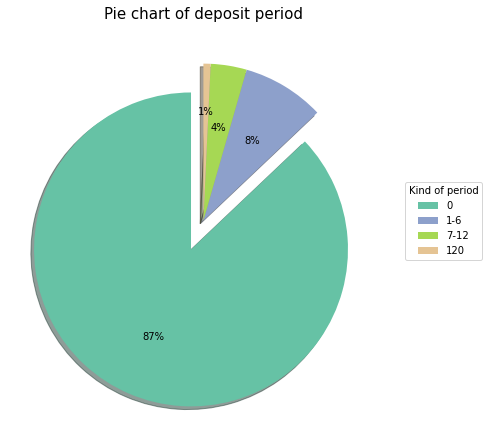

In [185]:
cs=cm.Set2(np.arange(4)/4.)
plt.figure(figsize=(10, 6))
explode = [0.1, 0.1, 0, 0, 0, 0]
patches, texts, autotexts = plt.pie(data_KyHan.groupby('KyHan_binned')['count'].sum(), explode= [0.2,0,0,0],
                                    shadow=True, startangle=90, autopct='%1.0f%%', colors=cs)

plt.legend(patches, data_KyHan.groupby('KyHan_binned')['count'].sum().index,
          title="Kind of period",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Pie chart of deposit period', fontsize=15)

plt.tight_layout()

for patch, txt in zip(patches, autotexts):
    # the angle at which the text is located
    ang = (patch.theta2 + patch.theta1) / 2.
    # new coordinates of the text, 0.7 is the distance from the center 
    x = patch.r * 0.7 * np.cos(ang*np.pi/180)
    y = patch.r * 0.7 * np.sin(ang*np.pi/180)
    # if patch is narrow enough, move text to new coordinates
    if (patch.theta2 - patch.theta1) < 10.:
        txt.set_position((x, y))

plt.savefig('piechartdepositperiod.png')

In [187]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="MaGD", outputCol="MaGDIndex") 
data_sub_indexed = indexer.fit(data_sub).transform(data_sub)

In [188]:
data_sub_indexed.select(['MaGD', 'MaGDIndex']).distinct().orderBy('MaGD').show(5)

+----+---------+
|MaGD|MaGDIndex|
+----+---------+
| 105|     32.0|
| 201|     12.0|
| 205|      0.0|
| 207|      7.0|
| 215|      2.0|
+----+---------+
only showing top 5 rows



In [189]:
data_sub_indexed = data_sub_indexed.drop('MaGD').withColumnRenamed('MaGDIndex', 'MaGD')

In [190]:
data_sub_indexed = data_sub_indexed.withColumn('MaGD', col('MaGD').cast('int').cast('string'))

In [191]:
data_sub_indexed[['MaGD']].show(5)

+----+
|MaGD|
+----+
|   0|
|  12|
|   0|
|   0|
|   0|
+----+
only showing top 5 rows



In [192]:
data_sub = data_sub.where((col('LoaiTien') == 'VND') | (col('LoaiTien') == 'USD'))

In [193]:
# Đổi đơn vị VND thành ngàn VND
data_sub = data_sub.withColumn('SoDuCuoi', (when(col('LoaiTien') == 'VND', col('SoDuCuoi')/1000)
                                            .otherwise(col('SoDuCuoi'))))

In [194]:
data_main = data_sub.select('MaKH').distinct()
def makeDescritiveStatisticAttr(df, col_statistic, col_filt, filts, statistic_attrs):
    '''A function to make a dataframe with descritive staticstic columns.
       ***
       Parameters:
        Input:
            df (spark dataframe): a based dataframe to aggregate.
            col_statistic (string type): a value column.
            col_filt (string type): a column contained groupby values.
            filts (list type): groupby values.
            statistic_attrs (list type): descritive staticstic values. ie: mean, min, max...
        returns: A joined global dataframe with descritive staticstic columns.
    '''
    global data_main
    for filt in filts:
        for statistic_attr in statistic_attrs:
            df_agg = df.where(col(col_filt) == filt).groupby('MaKH').agg({col_statistic : statistic_attr})
            if statistic_attr == 'mean':
                statistic_attr = 'avg'
            # Renamed columns
            df_agg = df_agg.withColumnRenamed(statistic_attr + '(' + col_statistic + ')', statistic_attr+'_'+filt)
            data_main = data_main.join(df_agg, on='MaKH', how='left')

In [195]:
filts = ['VND', 'USD']
statistic_attrs = ['mean', 'min', 'max']

In [196]:
makeDescritiveStatisticAttr(data_sub, col_statistic='SoDuCuoi', col_filt='LoaiTien', 
                            filts=filts, statistic_attrs=statistic_attrs)

In [197]:
data_main.show(3)

+------+------------------+--------+----------+-------+-------+-------+
|  MaKH|           avg_VND| min_VND|   max_VND|avg_USD|min_USD|max_USD|
+------+------------------+--------+----------+-------+-------+-------+
|496699| 4786.616838063439|1996.814|501997.314|   null|   null|   null|
|501949| 491.0763539232054| 425.364|   555.064|   null|   null|   null|
|512041|105.69223255813952|  97.762|   108.762|   null|   null|   null|
+------+------------------+--------+----------+-------+-------+-------+
only showing top 3 rows



In [198]:
data_main.count()

70347

In [199]:
data_avg_int = data_sub.select(['MaKH', 'LoaiTien', 'LaiSuat', 'SoDuCuoi'])\
                        .where(col('LoaiTien') == 'VND')\
                        .withColumn('numerator', col('LaiSuat') * col('SoDuCuoi'))\
                        .groupby('MaKH').sum('SoDuCuoi', 'numerator')\
                        .withColumn('avg_interest', col('sum(numerator)') / col('sum(SoDuCuoi)'))\
                        .select('MaKH', 'avg_interest')

In [200]:
data_main = data_main.join(data_avg_int, on='MaKH', how='left')

### Lý do phải lấy bình quân lãi suất (avg_inst) là lãi suất biến động định kỳ theo sự điều hành lãi suất của TSC và NHNN.

In [133]:
def makeExplodeAttributes(df, c):
    df = df.select(['MaKH', c])
    df = df.withColumn(c, concat(col(c), lit('_'+c)))
    df = df.withColumn('constant_val', lit(1))
    df = df.groupby('MaKH').pivot(c).agg(coalesce(first('constant_val')))
    return df

In [201]:
df_MaGD = makeExplodeAttributes(data_sub_indexed, 'MaGD')
data_main = data_main.join(df_MaGD, on='MaKH', how='left')

In [202]:
df_PGD = makeExplodeAttributes(data_sub, 'PGD')

In [203]:
str(data_sub.columns)

"['NgayGD', 'LoaiTien', 'MaKH', 'SoDuCuoi', 'MaGD', 'NghiepVuChiTiet', 'LaiSuat', 'KyHan', 'PGD', 'TPKinhTe', 'LoaiKH', 'LoaiKHChiTiet']"

In [204]:
df_PGD.columns

['MaKH',
 '00_PGD',
 '01_PGD',
 '02_PGD',
 '03_PGD',
 '05_PGD',
 '06_PGD',
 '07_PGD',
 '08_PGD',
 '\\"\\"_PGD']

In [205]:
df_PGD.groupby('\\"\\"_PGD').count().show()

+--------+-----+
|\"\"_PGD|count|
+--------+-----+
|    null|70324|
|       1|   23|
+--------+-----+



In [206]:
df_PGD.groupby('00_PGD').count().show()

+------+-----+
|00_PGD|count|
+------+-----+
|  null|31940|
|     1|38407|
+------+-----+



In [207]:
df_PGD = df_PGD.withColumn('00_PGD', (when(col('\\"\\"_PGD') == 1, 1)
                                      .otherwise(col('00_PGD'))))

In [210]:
df_PGD = df_PGD.drop('\\"\\"_PGD')

In [211]:
df_PGD = df_PGD.withColumn('00_PGD', (when(col('01_PGD') == 1, 1)
                                      .otherwise(col('00_PGD'))))

In [212]:
df_PGD.groupby('00_PGD').count().show()

+------+-----+
|00_PGD|count|
+------+-----+
|  null|31933|
|     1|38414|
+------+-----+



In [213]:
df_PGD = df_PGD.drop('01_PGD')

In [214]:
data_main = data_main.join(df_PGD, on='MaKH', how='left')

In [215]:
df_NghiepVuChiTiet = makeExplodeAttributes(data_sub, 'NghiepVuChiTiet')

In [216]:
df_NghiepVuChiTiet.columns

['MaKH', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet']

In [217]:
data_main = data_main.join(df_NghiepVuChiTiet, on='MaKH', how='left')

In [218]:
t2 = time.perf_counter()

In [219]:
(t2 - t1)/60

14.553828649999998

In [220]:
data_main = data_main.fillna(0)

## Read dataset2: import more attributes from customer's info

    * DIACHI_NR
    * GIOITINH

In [221]:
dataset2 = spark.read.csv('cust_inf_merge_2.csv', header=True, inferSchema=True)

In [222]:
dataset2.show(5)

+---+---------+--------------------+--------+------------------+
|_c0|     MAKH|           DIACHI_NR|GIOITINH|Account_Management|
+---+---------+--------------------+--------+------------------+
|  0| 10001650|11 Nguyễn Kim-P12...|       0|                 0|
|  1|100048738|357/1 Bạch Đằng F...|       0|                 0|
|  2|100054220|31Huỳnh Tấn Phát-...|       0|                 0|
|  3|100054220|31Huỳnh Tấn Phát,...|       0|                 0|
|  4| 10005632|100/10 Trần Hưng ...|       1|                 0|
+---+---------+--------------------+--------+------------------+
only showing top 5 rows



In [223]:
dataset2 = dataset2.withColumnRenamed('MAKH', 'MaKH')

In [224]:
dataset2 = dataset2.drop('_c0')

In [225]:
data_main = data_main.join(dataset2, on='MaKH', how='left')

In [226]:
data_main.show(3)

+------+------------------+--------+----------+-------+-------+-------+-------------------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------------------+------------------+--------------------+--------+------------------+
|  MaKH|           avg_VND| min_VND|   max_VND|avg_USD|min_USD|max_USD|       avg_interest|0_MaGD|10_MaGD|11_MaGD|12_MaGD|13_MaGD|14_MaGD|15_MaGD|16_MaGD|17_MaGD|18_MaGD|19_MaGD|1_MaGD|20_MaGD|21_MaGD|22_MaGD|23_MaGD|24_MaGD|25_MaGD|26_MaGD|27_MaGD|28_MaGD|29_MaGD|2_MaGD|30_MaGD|31_MaGD|32_MaGD|3_MaGD|4_MaGD|5_MaGD|6_MaGD|7_MaGD|8_MaGD|9_MaGD|00_PGD|02_PGD|03_PGD|05_PGD|06_PGD|07_PGD|08_PGD|DA_NghiepVuChiTiet|SA_NghiepVuChiTiet|           DIACHI_NR|GIOITINH|Account_Management|
+------+------------------+--------+

In [158]:
# # Saving for further calculation
# data_main.toPandas().to_csv('data_cust_unlabelled_2.csv')

# PHẦN 4: GÁN NHÃN <a name="part4"></a>
* Gán nhãn khách hàng bằng phương pháp loại suy: Nếu khách hàng trong năm 2018 không có trong năm 2019 thì gán nhãn 1

In [227]:
t1 = time.perf_counter()

In [228]:
spark = SparkSession.builder.appName('project_main00').getOrCreate()

In [229]:
dataset1 = spark.read.csv('statement_data.csv', header=False, inferSchema=True)

In [230]:
header = pd.read_csv('headers_statement.csv')

In [231]:
newColumns = np.array(header['0']).tolist()

In [232]:
# newColumns

In [233]:
oldColumns = dataset1.columns

In [234]:
# Change columns name
dataset1 = reduce(lambda dataset1, idx: dataset1.\
                  withColumnRenamed(oldColumns[idx], 
                                    newColumns[idx]),
                  range(len(oldColumns)), dataset1)

In [235]:
# dataset1.show(3)

### Các thuộc tính lựa chọn trong mô hình và dataset1
1. NgayGD: là các ngày trong năm từ 01/01/2018 - 31/12/2019 (bỏ qua các ngày nghỉ lễ, tết).
2. LoaiTien: là các loại tiền gửi (AUD, EUR, USD, VND).
3. MaKH: là mã của từng khách hàng, là số duy nhất của 1 khách hàng cụ thể.
4. SoDuCuoi: là số dư tiền gửi cuối ngày
5. MaGD: là loại chi tiết tiền gửi (không kỳ hạn, có kỳ hạn dưới 12 tháng..)
6. NghiepVuChiTiet: DA: 
7. LaiSuat: là lãi suất của từng loại tiền gửi
8. CachTinhLai: lãi trả hằng tháng hoặc năm
9. KyHan: kỳ hạn của tiền gửi
10. PGD: nơi mở tk
11. TPKinhTe: thành phần kinh tế
12. LoaiKH: 100-300 là cá nhân, >300 là doanh nghiệp
13. LoaiKHChiTiet

In [169]:
# print('Number of All the rows:', dataset1.count())

*Vì khách hàng ở đây là cá nhân hoặc hộ kinh doanh nên tác giả sẽ chỉ giữ lại các khách hàng cá nhân (LoaiKH <= 300).*

In [237]:
data_sub = dataset1.where(col('LoaiKH') <= 300)

In [238]:
# Chỉ chọn SA và DA
data_sub = data_sub.where((col('NghiepVuChiTiet') == 'SA') | (col('NghiepVuChiTiet') == 'DA'))

In [239]:
data_sub.printSchema()

root
 |-- NgayGD: integer (nullable = true)
 |-- LoaiTien: string (nullable = true)
 |-- MaKH: integer (nullable = true)
 |-- SoDuCuoi: double (nullable = true)
 |-- MaGD: string (nullable = true)
 |-- NghiepVuChiTiet: string (nullable = true)
 |-- LaiSuat: double (nullable = true)
 |-- CachTinhLai: string (nullable = true)
 |-- KyHan: double (nullable = true)
 |-- PGD: string (nullable = true)
 |-- TPKinhTe: integer (nullable = true)
 |-- LoaiKH: string (nullable = true)
 |-- LoaiKHChiTiet: string (nullable = true)



# Nguyên tắc gán nhãn các khách hàng tiền gửi:

Trong khoa học, muốn xem xét sự thay đổi của một hiện tượng/sự vật thì phải cố định một yếu tố rồi thay đổi các yếu tố còn lại. Gán nhãn cho một khách hàng cũng vậy, ta phải cố định danh sách khách hàng trong một năm để xem xét sự thay đổi của các khách hàng trong năm đó. 

#### I. Lý do mà học viên chọn thêm năm 2019 vì:
1. Một số khách hàng gửi tiền theo kỳ hạn 1 năm, hoặc theo kỳ hạn ngắn hơn nhưng thời điểm kết thúc hợp đồng tiền gửi vào năm tiếp theo.
2. Ta có thể tính được một số thuộc tính quan trọng như bình quân tiền gửi, bình quân lãi suất cho đến năm sau. 

#### II. Nguyên tắc: Khách hàng không còn gửi tiền được gán là 1, còn lại là 0
Để việc gắn nhãn không bị sót, học viên đề xuất điều kiện sau.
* Map danh sách khách hàng có trong cả năm 2018 nhưng không có trong danh sách tại ngày 31/12/2019.

#### III. Phương pháp: 
1. dùng thuật left-join để lọc.
2. Sử dụng propagate labeling là một thuật toán học bán giám sát do <> đề xuất.

In [240]:
data_label = data_sub.select(['NgayGD', 'MaKH']).orderBy('NgayGD')

In [241]:
dataset_cus_2018 = data_label.where(col('NgayGD') <= 20181231)\
                               .select('MaKH').distinct()

In [242]:
dataset_cus_2019 = data_label.where((col('NgayGD') == 20191231))\
                               .select('MaKH').distinct()

In [243]:
dataset_cus_2018.count()

63133

In [244]:
dataset_cus_2019.count()

59266

In [245]:
dataset_cus_2018 = dataset_cus_2018.withColumn('dummy', lit(1))
dataset_cus_2019 = dataset_cus_2019.withColumn('label', lit(1))

In [246]:
data_label_join = dataset_cus_2018.join(dataset_cus_2019, on='MaKH', how='left_outer')

In [247]:
data_label_join.show(10)

+-------+-----+-----+
|   MaKH|dummy|label|
+-------+-----+-----+
| 496699|    1|    1|
| 501949|    1|    1|
| 512041|    1| null|
| 529757|    1|    1|
| 749060|    1| null|
| 832491|    1|    1|
|2578386|    1|    1|
|2868080|    1|    1|
|3131446|    1| null|
|3237070|    1|    1|
+-------+-----+-----+
only showing top 10 rows



In [249]:
data_label_join = data_label_join.drop('dummy')

In [250]:
data_label_join = data_label_join.fillna(0)

In [251]:
data_label_join.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|52387|
|    0|10746|
+-----+-----+



In [252]:
data_label_join = data_label_join.withColumn('label', (when(col('label') == 0, 1)
                                                       .otherwise(0)))

In [253]:
# Saving label for further calculation
# data_label_join.toPandas().to_csv('data_label.csv')

# PHẦN 5: MODELLING <a name="part5"></a>

* [Nhập 2 dataset unlabelled và label](#readdata).
* [Làm sạch dữ liệu](#datacleaning).
* [Exploratory Data Analysis](#EDA).
* [Imbalance handling](#handleImbalance).
* [Outlier handling](#outlier).
* [Chạy mô hình](#modelling).
* [Propagation Labelling](#propagation)
* [Đánh giá các thuật toán](#assessment)
* [Giải thích bằng LIME](#lime)

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy.stats import chi2_contingency, chi2

# Library for Cook's distance
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.spatial.distance import cdist
from statsmodels.formula.api import ols
from yellowbrick.regressor import CooksDistance

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, silhouette_score, roc_curve

import re
import spacy
import time
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [255]:
def statistic_con(variables):
    ''' This function is for statistically describing and visualising given continuous variables.
        returns: descritive statistic (min, median, mode, dispersion, IQR) of continuous variables.
    '''
    for variable in variables:
        data[variable].describe(include='All')
        _median = data[variable].median()
        _mode = data[variable].mode()
        # Measure of dispersion
        _range = np.array(data[variable]).ptp()
        # Measures percentile
        Q1 = np.percentile(data[variable], 25)
        Q3 = np.percentile(data[variable], 75)
        _IQR = Q3 - Q1
        _var = data[variable].var()
        _std = data[variable].std()
        upper_outlier = data[variable].loc[data[variable] > Q3 + 1.5 * _IQR].shape[0]
        pct_u_o = (upper_outlier / data[variable].shape[0]) * 100
        lower_outlier = data[variable].loc[data[variable] < Q1 - 1.5 * _IQR].shape[0]
        pct_l_o = (lower_outlier / data[variable].shape[0]) * 100
        pct_t_o = ((upper_outlier + lower_outlier) / data[variable].shape[0]) * 100
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        sns.distplot(data[variable], kde_kws={'bw': 0.01})
        plt.subplot(1,2,2)
        plt.hist(data[variable])    
        print(f'''
        {'-' * 40}
        Dispersion of {variable}: {_range}
        {variable}_median: {_median}
        {variable}_mode: {_mode}
        {variable}_Q1: {Q1}
        {variable}_Q3: {Q3}
        {variable}_IQR: {_IQR}
        {variable}_var: {_var}
        {variable}_std: {_std}
        Number of upper outlier: {upper_outlier}, takes {pct_u_o:.4}% of total sample.
        Number of lower outlier: {lower_outlier}, takes {pct_l_o:.4}% of total sample.
        Number of Total outlier: {upper_outlier + lower_outlier}, takes {pct_t_o:.4}% of total sample.
        {'-' * 40}
        ''')
        plt.show()

In [256]:
def cate_cate_analysing(df, var_list, var2):
    '''Analysing two categorical varibles. 
       Iterate items in var_list which is compared with var2 in order to conclude whether they are independent or not.
       -----
       Parameters:
            `df`: dataframe contains variables.
            `var_list`: list of categorical variables.
            `var2`: a compared categorical variable.
        ----
       returns: if 
    '''
    for var1 in var_list:
        table_FB = pd.crosstab(df[var1], df[var2])
        table_FB.plot(kind='bar', stacked=True)
        plt.show()
        # Chi-square test:
        stat, p, dof, expected = chi2_contingency(table_FB)
        # Hypothesis testing using p-value:
        alpha = 0.05
        if p < alpha:
            print(f'{var1} and {var2} Dependent.')
        else: 
            print(f'{var1} and {var2} Independent.')

In [257]:
def make_log_column(df, vals, prefix=False):
    '''To make Logarithm columns based on given continuous varibles.
       -----
       Parameters:
        df: dataframe contains variables.
        vals: list of continuous variables.
        prefix (False: converse variable parse, 
                True will make a different column with '_log')
       -----
       Returns: a dataframe with logarithm columns.
    '''
    for val in vals:
        if prefix == True:
            val_name = val + '_log'
        else:
            val_name = val
        df.loc[:, val_name] = np.log(df[val])
        # Replace values that smaller than 0 to 0.
        df.loc[:, val_name][df.loc[:, val_name] < 0] = 0
    return df

In [258]:
def make_RobustScaler_column(df, vals, prefix=False):
    '''To make Robust Scaling columns based on given continuous varibles.
       -----
       Parameters:
            `df`: dataframe contains variables.
            `vals`: list of continuous variables.
            `prefix` (False: converse variable parse, 
                True will make a different column with '_log')
       -----
       Returns: a dataframe with Robust Scaling columns.
    '''
    scaler = RobustScaler()
    robust_scaler = scaler.fit_transform(df[vals])
    
    if prefix == True:
        val_name = [x + '_Rscale' for x in vals]
    else:
        val_name = val
        
    tmp = pd.DataFrame(robust_scaler, columns=val_name)
    for val in val_name:
        df.loc[:, val] = tmp[val].values

    return df

In [259]:
def make_StandardScaler_column(df, vals, prefix=False):
    '''To make Standard Scaling columns based on given continuous varibles.
       -----
       Parameters:
            `df`: dataframe contains variables.
            `vals`: list of continuous variables.
            `prefix`: (False: converse variable parse, 
                True will make a different column with '_log')
        -----
       Returns: a dataframe with Standard Scaling columns.
    '''
    scaler = StandardScaler()
    robust_scaler = scaler.fit_transform(df[vals])
    
    if prefix == True:
        val_name = [x + '_Stscale' for x in vals]
    else:
        val_name = val
        
    tmp = pd.DataFrame(robust_scaler, columns=val_name)
    for val in val_name:
        df.loc[:, val] = tmp[val].values

    return df

In [260]:
def num_outliers(df, variables):
    ''' This function is for statistically describe outliers in given continuous variables.
    '''
    for variable in variables:
        Q1 = np.percentile(df[variable], 25)
        Q3 = np.percentile(df[variable], 75)
        _IQR = Q3 - Q1
        upper_outlier = df[variable].loc[df[variable] > Q3 + 1.5 * _IQR].shape[0]
        lower_outlier = df[variable].loc[df[variable] < Q1 - 1.5 * _IQR].shape[0]
        pct_u_o = (upper_outlier / df[variable].shape[0]) * 100
        pct_l_o = (lower_outlier / df[variable].shape[0]) * 100
        pct_t_o = ((upper_outlier + lower_outlier) / df[variable].shape[0]) * 100
        print(f'''
        {'-' * 40}
        {variable}:
        Number of upper outlier: {upper_outlier}, takes {pct_u_o:.4}% of total sample.
        Number of lower outlier: {lower_outlier}, takes {pct_l_o:.4}% of total sample.
        Number of Total outlier: {upper_outlier + lower_outlier}, takes {pct_t_o:.4}% of total sample.
        {'-' * 40}
        ''')

In [261]:
def evaluate_model(model, test_features, test_labels):
    '''To evaluate a trained algorithm based on test values and test labels.
       ***
       Parameters:
            `model` : a fitted model 
            `test_features` : 
            `test_labels` : 
            
    '''
    predictions = model.predict(test_features)
    model_name = model.__class__.__name__
    recall = recall_score(test_labels, predictions) * 100
    f1 = f1_score(test_labels, predictions) * 100
    print('Model %s Performance' % model_name)
    print(f'- Recall score: {recall:0.4f} %.')
    print(f'- f1 score    : {f1:0.2f} %.')
    return f1, recall

In [262]:
def multiModelEvaluation(df, inputs, resample_train):
    
    """
       Scaling continuous variables in dataset.
       Resample model (if True).
       Train and test models based on chosen inputs.
    
    Parameters
    --------
        df (pd.DataFrame): 
            dataframe contained raw features and label
        inputs (list): 
            list of inputs 
        resample (str, default = ''): 
            Use over-resampling for handiling imbalanced data set.
            if resample = 'SMOTE', model uses SMOTE to upsample.
            if resample = 'utils', model uses sklearn.utils to upsample.
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `name` mode name, `f1` f1-score, `recall` recall-score
        
    """ 
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if resample_train.lower() == 'utils':
        df_train = X_train.merge(y_train, on=X_train.index)
        df_0 = df_train.loc[df_train['label'] == 0]
        df_1 = df_train.loc[df_train['label'] == 1]     
   
        df_1_resample = resample(df_1, replace=True, n_samples = df_0.shape[0])
        
        df_upsampled = pd.concat([df_1_resample, df_0])
        X_train = df_upsampled.drop('label', axis=1)
        y_train = df_upsampled['label']
        
    elif resample_train.lower() == 'smote':
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)       
    else:
        X_train, X_test, y_train, y_test
    
    X_train, X_test = X_train[inputs], X_test[inputs]
    
    rfc = RandomForestClassifier(n_jobs=-1)
    list_tree = [30, 50, 70, 100, 150, 200, 500, 1000]
    rfc_score = []
    for tree in list_tree:
        rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
        rfc.fit(X_train, y_train)
        score_test = rfc.score(X_test, y_test)
        rfc_score.append(score_test)
    dic_score = {a:b for a, b in zip(list_tree, rfc_score)}
    for tree, score in dic_score.items():
        if score == max(dic_score.values()):
            break
    print('Best tree: ', tree)
    
    models = [LogisticRegression(), 
              DecisionTreeClassifier(criterion='entropy'), 
              RandomForestClassifier(n_estimators=tree, n_jobs=-1),
              XGBClassifier(random_state=42, n_jobs=-1)]

    submission = []
    for model in models:
        t1 = time.perf_counter()
        name = model.__class__.__name__
        model.fit(X_train, y_train)
        f1, recall = evaluate_model(model, X_test, y_test)
        t2 = time.perf_counter()
        time_count = t2 - t1
        submission.append([name, f1, recall, time_count])
        
    submission = pd.DataFrame(submission, columns = ['name', 'f1', 'recall', 'time_running'])
    
    return submission

## Đọc tập tin <a name="readdata"></a>

In [263]:
data_input = pd.read_csv('data_cust_unlabelled_3_encode.csv', index_col='Unnamed: 0')
data_output = pd.read_csv('data_label.csv', index_col='Unnamed: 0')

In [264]:
data_input.describe()

MaKH       avg_VND       min_VND       max_VND        avg_USD  \
count  8.011100e+04  8.011100e+04  8.011100e+04  8.011100e+04   80111.000000   
mean   2.278203e+08  2.610421e+04  2.345544e+03  1.135376e+05     107.328364   
std    1.106588e+08  1.964833e+05  6.565466e+04  8.438012e+05    4381.677193   
min    4.498900e+04  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    1.571915e+08  4.352087e+00  0.000000e+00  3.355000e+01       0.000000   
50%    2.590776e+08  2.655411e+02  0.000000e+00  4.052800e+03       0.000000   
75%    3.108533e+08  3.207093e+03  4.290000e+01  2.699788e+04       0.000000   
max    3.831856e+08  1.334867e+07  9.239000e+06  7.860641e+07  619318.181818   

             min_USD        max_USD  avg_interest        0_MaGD       10_MaGD  \
count   80111.000000   80111.000000  80111.000000  80111.000000  80111.000000   
mean       31.681530     147.011115      0.627966      0.755664      0.004331   
std      2446.983389    5911.649748      1.412026      0.429695      0.065672   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%         0.000000       0.000000      0.201347      1.000000      0.000000   
50%         0.000000       0.000000      0.214618      1.000000      0.000000   
75%         0.000000       0.000000      0.242982      1.000000      0.000000   
max    515965.000000  700000.000000     11.009628      1.000000      1.000000   

       ...        00_PGD        02_PGD        03_PGD        05_PGD  \
count  ...  80111.000000  80111.000000  80111.000000  80111.000000   
mean   ...      0.544332      0.072524      0.222579      0.038571   
std    ...      0.498034      0.259356      0.415980      0.192573   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      1.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

             06_PGD        07_PGD        08_PGD  DA_NghiepVuChiTiet  \
count  80111.000000  80111.000000  80111.000000        80111.000000   
mean       0.026813      0.052078      0.053314            0.957035   
std        0.161537      0.222185      0.224659            0.202780   
min        0.000000      0.000000      0.000000            0.000000   
25%        0.000000      0.000000      0.000000            1.000000   
50%        0.000000      0.000000      0.000000            1.000000   
75%        0.000000      0.000000      0.000000            1.000000   
max        1.000000      1.000000      1.000000            1.000000   

       SA_NghiepVuChiTiet  Account_Management  
count        80111.000000        79241.000000  
mean             0.088490            0.004934  
std              0.284008            0.070072  
min              0.000000            0.000000  
25%              0.000000            0.000000  
50%              0.000000            0.000000  
75%              0.000000            0.000000  
max              1.000000            1.000000  

[8 rows x 51 columns]

In [530]:
data_input.head(5)

MaKH       avg_VND   min_VND     max_VND  avg_USD  min_USD  max_USD  \
0  496699   4786.616838  1996.814  501997.314      0.0      0.0      0.0   
1  501949    491.076354   425.364     555.064      0.0      0.0      0.0   
2  512041    105.692233    97.762     108.762      0.0      0.0      0.0   
3  529757  32377.561932  2091.601   72587.330      0.0      0.0      0.0   
4  749060     63.580233    55.650      66.650      0.0      0.0      0.0   

   avg_interest  0_MaGD  10_MaGD  ...  03_PGD  05_PGD  06_PGD  07_PGD  08_PGD  \
0      0.223046       1        0  ...       0       0       0       0       0   
1      0.209180       1        0  ...       0       0       0       0       0   
2      0.300000       1        0  ...       0       0       0       0       0   
3      0.217048       1        0  ...       0       0       0       0       0   
4      0.300000       1        0  ...       0       0       0       0       0   

   DA_NghiepVuChiTiet  SA_NghiepVuChiTiet  \
0                   1                   0   
1                   1                   0   
2                   1                   0   
3                   1                   0   
4                   1                   0   

                                           DIACHI_NR  GIOITINH  \
0  Cty Tài Chính Cao Su, 210 Nam Kỳ Khởi Nghĩa, Q...         0   
1                                               1600         0   
2                                     32 Quân Sự Q11         1   
3                             114 PASTEUR Q1TTĐĐ-PCN         1   
4        9X/9 Chu Văn An, P.12Quận Bình Thạnh, TPHCM         1   

   Account_Management  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 53 columns]

In [529]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70346 entries, 0 to 80110
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MaKH                70346 non-null  int64  
 1   avg_VND             70346 non-null  float64
 2   min_VND             70346 non-null  float64
 3   max_VND             70346 non-null  float64
 4   avg_USD             70346 non-null  float64
 5   min_USD             70346 non-null  float64
 6   max_USD             70346 non-null  float64
 7   avg_interest        70346 non-null  float64
 8   0_MaGD              70346 non-null  int64  
 9   10_MaGD             70346 non-null  int64  
 10  11_MaGD             70346 non-null  int64  
 11  12_MaGD             70346 non-null  int64  
 12  13_MaGD             70346 non-null  int64  
 13  14_MaGD             70346 non-null  int64  
 14  15_MaGD             70346 non-null  int64  
 15  16_MaGD             70346 non-null  int64  
 16  17_M

In [267]:
data_input.shape

(80111, 53)

In [268]:
data_input = data_input.drop_duplicates(subset='MaKH')

In [269]:
data_input.shape

(70347, 53)

In [270]:
data_output.head()

MaKH  label
0  496699      0
1  501949      0
2  512041      1
3  529757      0
4  749060      1

In [271]:
data_output.count()

MaKH     63133
label    63133
dtype: int64

In [272]:
data_output.label.value_counts()

0    52387
1    10746
Name: label, dtype: int64

In [273]:
data_input.GIOITINH.value_counts().index

Index([0.0, 1.0, '0', '1', ' M""""ĐrăkLOP K16402C24"""'], dtype='object')

## Làm sạch dữ liệu <a name="datacleaning"></a>

In [274]:
data_input = data_input.loc[data_input.GIOITINH != ' M""""ĐrăkLOP K16402C24"""']

In [275]:
data = data_input.merge(data_output, on = 'MaKH', how='left')

In [277]:
data.isnull().sum()

MaKH                     0
avg_VND                  0
min_VND                  0
max_VND                  0
avg_USD                  0
min_USD                  0
max_USD                  0
avg_interest             0
0_MaGD                   0
10_MaGD                  0
11_MaGD                  0
12_MaGD                  0
13_MaGD                  0
14_MaGD                  0
15_MaGD                  0
16_MaGD                  0
17_MaGD                  0
18_MaGD                  0
19_MaGD                  0
1_MaGD                   0
20_MaGD                  0
21_MaGD                  0
22_MaGD                  0
23_MaGD                  0
24_MaGD                  0
25_MaGD                  0
26_MaGD                  0
27_MaGD                  0
28_MaGD                  0
29_MaGD                  0
2_MaGD                   0
30_MaGD                  0
31_MaGD                  0
32_MaGD                  0
3_MaGD                   0
4_MaGD                   0
5_MaGD                   0
6

. Có 3 thuộc tính có giá trị null bao gồm DIACHI_NR, GIOITINH, label 

In [278]:
print('Percentage of null values (%):')
data.isnull().sum()[data.isnull().any() == True]/data.shape[0] * 100

Percentage of null values (%):


DIACHI_NR              1.236744
GIOITINH               1.236744
Account_Management     1.236744
label                 10.272084
dtype: float64

**Ghi chú:**<br>
- Vì số lượng các giá trị null nhỏ, ít ảnh hưởng đến model nên ta sẽ thực hiện loại bỏ các giá trị này.
- Giá trị null của label là các khách hàng mới trong năm 2019 nên không được xét đến như đã đề cập đến trong phần labelling.

In [279]:
data = data.dropna()

In [281]:
data = data.drop('MaKH', axis=1)

In [282]:
data.GIOITINH = data.GIOITINH.astype('int')

In [283]:
data.reset_index(inplace=True)
data = data.drop('index', axis=1)

## Explore Data Analysis <a name="EDA"></a>

### Phân tích một biến

In [284]:
numbers = [f for f in data.columns if data[f].dtypes != 'object']
print('Numerical variables:',len(numbers), numbers)

Numerical variables: 52 ['avg_VND', 'min_VND', 'max_VND', 'avg_USD', 'min_USD', 'max_USD', 'avg_interest', '0_MaGD', '10_MaGD', '11_MaGD', '12_MaGD', '13_MaGD', '14_MaGD', '15_MaGD', '16_MaGD', '17_MaGD', '18_MaGD', '19_MaGD', '1_MaGD', '20_MaGD', '21_MaGD', '22_MaGD', '23_MaGD', '24_MaGD', '25_MaGD', '26_MaGD', '27_MaGD', '28_MaGD', '29_MaGD', '2_MaGD', '30_MaGD', '31_MaGD', '32_MaGD', '3_MaGD', '4_MaGD', '5_MaGD', '6_MaGD', '7_MaGD', '8_MaGD', '9_MaGD', '00_PGD', '02_PGD', '03_PGD', '05_PGD', '06_PGD', '07_PGD', '08_PGD', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet', 'GIOITINH', 'Account_Management', 'label']


In [285]:
objects = [f for f in data.columns if data[f].dtypes == 'object']
print('String variables:',len(objects), objects)

String variables: 1 ['DIACHI_NR']


In [286]:
# Drop địa chỉ để phân tích trước
data.drop(['DIACHI_NR'], axis=1, inplace=True)

Numerical Variable:

    * Continuous Variables
    * Categorical Variables
<br>

In [287]:
# Categorical variable and continuous:
i = 1
for cat in numbers:
    print(i,'.', cat, '  ', 'Unique value ', 
          len(data[cat].unique()),':', 
          data[cat].unique() if len(data[cat].unique()) < 10 else "")
    i += 1

1 . avg_VND    Unique value  48690 : 
2 . min_VND    Unique value  16944 : 
3 . max_VND    Unique value  41630 : 
4 . avg_USD    Unique value  371 : 
5 . min_USD    Unique value  158 : 
6 . max_USD    Unique value  294 : 
7 . avg_interest    Unique value  37618 : 
8 . 0_MaGD    Unique value  2 : [1 0]
9 . 10_MaGD    Unique value  2 : [0 1]
10 . 11_MaGD    Unique value  2 : [0 1]
11 . 12_MaGD    Unique value  2 : [0 1]
12 . 13_MaGD    Unique value  2 : [0 1]
13 . 14_MaGD    Unique value  2 : [0 1]
14 . 15_MaGD    Unique value  2 : [0 1]
15 . 16_MaGD    Unique value  2 : [0 1]
16 . 17_MaGD    Unique value  2 : [0 1]
17 . 18_MaGD    Unique value  2 : [0 1]
18 . 19_MaGD    Unique value  2 : [0 1]
19 . 1_MaGD    Unique value  2 : [0 1]
20 . 20_MaGD    Unique value  2 : [0 1]
21 . 21_MaGD    Unique value  2 : [0 1]
22 . 22_MaGD    Unique value  2 : [0 1]
23 . 23_MaGD    Unique value  2 : [0 1]
24 . 24_MaGD    Unique value  2 : [0 1]
25 . 25_MaGD    Unique value  2 : [0 1]
26 . 26_MaGD    Uni

In [288]:
cat_val = []
con_val = []
for val in numbers:
    if len(data[val].unique()) < 10:
        cat_val.append(val)
    else:
        con_val.append(val)

In [289]:
print(f'Number of Continuous varibles: {len(con_val)}.\nNumber of Categorical variable: {len(cat_val)}.')

Number of Continuous varibles: 7.
Number of Categorical variable: 45.


### Continuous variables:
* avg_VND
* avg_USD
* max_VND
* min_VND
* max_USD
* min_USD
* avg_interest


        ----------------------------------------
        Dispersion of avg_VND: 13348671.395665566
        avg_VND_median: 174.31085141903162
        avg_VND_mode: 0    0.380634
dtype: float64
        avg_VND_Q1: 3.829900667779633
        avg_VND_Q3: 2321.1358693656093
        avg_VND_IQR: 2317.3059686978295
        avg_VND_var: 32872475984.426136
        avg_VND_std: 181307.68319193242
        Number of upper outlier: 10977, takes 17.55% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 10977, takes 17.55% of total sample.
        ----------------------------------------
        


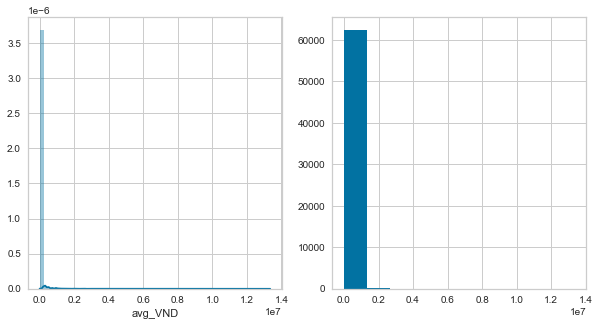


        ----------------------------------------
        Dispersion of min_VND: 4280214.0
        min_VND_median: 0.0
        min_VND_mode: 0    0.0
dtype: float64
        min_VND_Q1: 0.0
        min_VND_Q3: 35.25025
        min_VND_IQR: 35.25025
        min_VND_var: 1146214306.2630768
        min_VND_std: 33855.78689475518
        Number of upper outlier: 7869, takes 12.58% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 7869, takes 12.58% of total sample.
        ----------------------------------------
        


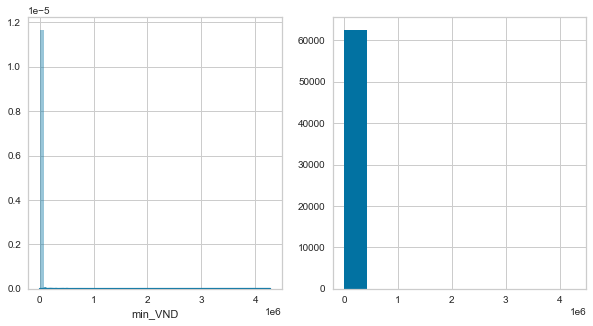

In [290]:
statistic_con(con_val[:2])


        ----------------------------------------
        Dispersion of max_VND: 78606414.0
        max_VND_median: 2351.7195
        max_VND_mode: 0    2.0
dtype: float64
        max_VND_Q1: 13.724250000000001
        max_VND_Q3: 21848.3165
        max_VND_IQR: 21834.59225
        max_VND_var: 605291395621.5393
        max_VND_std: 778004.7529556226
        Number of upper outlier: 9552, takes 15.27% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 9552, takes 15.27% of total sample.
        ----------------------------------------
        


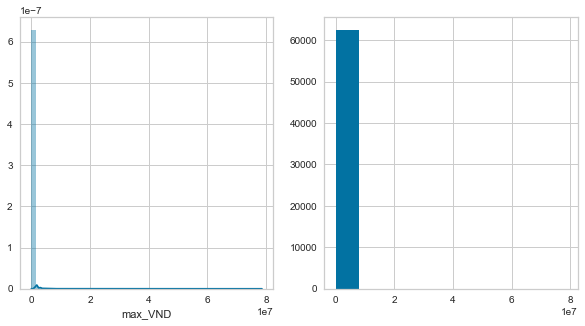


        ----------------------------------------
        Dispersion of avg_USD: 619318.1818181818
        avg_USD_median: 0.0
        avg_USD_mode: 0    0.0
dtype: float64
        avg_USD_Q1: 0.0
        avg_USD_Q3: 0.0
        avg_USD_IQR: 0.0
        avg_USD_var: 20450776.557385303
        avg_USD_std: 4522.253482212745
        Number of upper outlier: 386, takes 0.6172% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 386, takes 0.6172% of total sample.
        ----------------------------------------
        


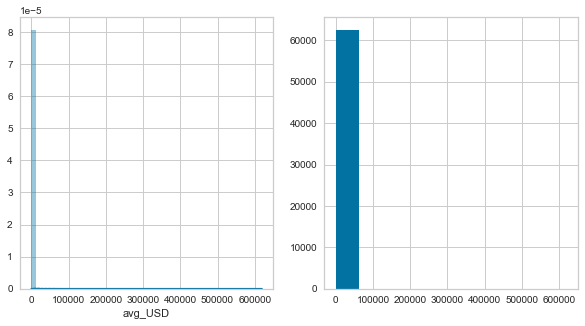

In [291]:
statistic_con(con_val[2:4])


        ----------------------------------------
        Dispersion of min_USD: 515965.0
        min_USD_median: 0.0
        min_USD_mode: 0    0.0
dtype: float64
        min_USD_Q1: 0.0
        min_USD_Q3: 0.0
        min_USD_IQR: 0.0
        min_USD_var: 7405614.841155275
        min_USD_std: 2721.3259343847944
        Number of upper outlier: 183, takes 0.2926% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 183, takes 0.2926% of total sample.
        ----------------------------------------
        


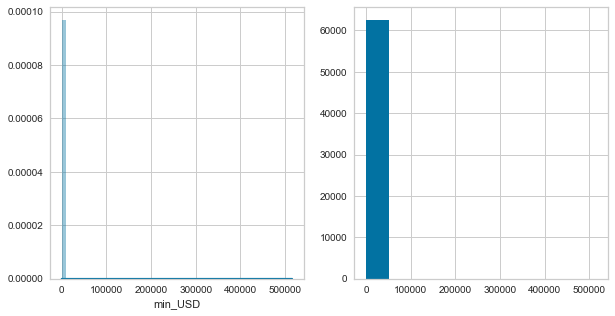


        ----------------------------------------
        Dispersion of max_USD: 700000.0
        max_USD_median: 0.0
        max_USD_mode: 0    0.0
dtype: float64
        max_USD_Q1: 0.0
        max_USD_Q3: 0.0
        max_USD_IQR: 0.0
        max_USD_var: 35247574.77107648
        max_USD_std: 5936.966798886152
        Number of upper outlier: 386, takes 0.6172% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 386, takes 0.6172% of total sample.
        ----------------------------------------
        


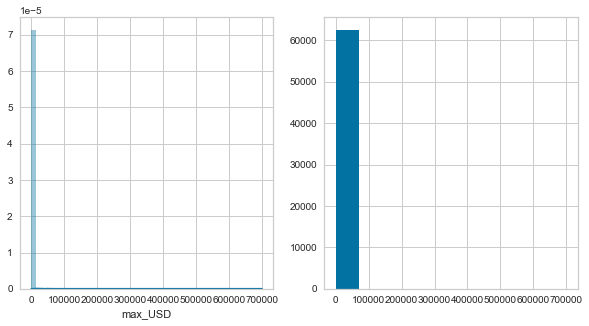

In [292]:
statistic_con(con_val[4:6])

In [293]:
[con_val[6]]

['avg_interest']


        ----------------------------------------
        Dispersion of avg_interest: 11.009628156584464
        avg_interest_median: 0.22092568487179576
        avg_interest_mode: 0    0.242982
dtype: float64
        avg_interest_Q1: 0.20438973354732923
        avg_interest_Q3: 0.24439633531447033
        avg_interest_IQR: 0.0400066017671411
        avg_interest_var: 1.6845719330540512
        avg_interest_std: 1.297910602874501
        Number of upper outlier: 4590, takes 7.34% of total sample.
        Number of lower outlier: 1837, takes 2.938% of total sample.
        Number of Total outlier: 6427, takes 10.28% of total sample.
        ----------------------------------------
        


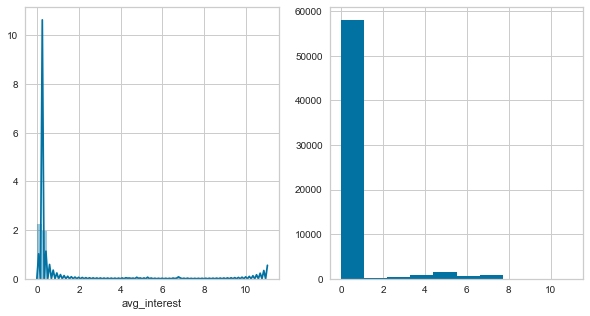

In [294]:
statistic_con([con_val[6]])

### Nhận xét sơ bộ về Continuous variables:
1. Vì đa số các biến số tiền đều có sự chênh lệch giữa rất lớn, ta sẽ lấy log các cột số tiền: 'avg_VND', 'avg_USD', 'max_VND', 'min_VND', 'max_USD', 'min_USD'.
2. Có khá nhiều các outliers trên các biến.

In [295]:
# Save processed data for Propagation Labelling
data_cleaned = data.copy()
data_cleaned.to_csv('data_cleaned.csv')

In [296]:
data = make_log_column(data, con_val, prefix=True)

In [297]:
# Take columns that has 'log' value
con_val_log = [val for val in data.columns.tolist() if '_log' in val]

In [299]:
con_val_log

['avg_VND_log',
 'min_VND_log',
 'max_VND_log',
 'avg_USD_log',
 'min_USD_log',
 'max_USD_log',
 'avg_interest_log']

In [300]:
from numpy import round

In [302]:
print('Range of logged values:')
for col in con_val_log:
    print('* ', col + ': ' + str(round(np.ptp(data[col]), 2)))

Range of logged values:
*  avg_VND_log: 16.41
*  min_VND_log: 15.27
*  max_VND_log: 18.18
*  avg_USD_log: 13.34
*  min_USD_log: 13.15
*  max_USD_log: 13.46
*  avg_interest_log: 2.4



        ----------------------------------------
        Dispersion of avg_VND_log: 16.40692741693407
        avg_VND_log_median: 5.160840195314595
        avg_VND_log_mode: 0    0.0
dtype: float64
        avg_VND_log_Q1: 1.3428388665416024
        avg_VND_log_Q3: 7.749811942709633
        avg_VND_log_IQR: 6.406973076168031
        avg_VND_log_var: 13.761000182160492
        avg_VND_log_std: 3.7095822112686077
        Number of upper outlier: 0, takes 0.0% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 0, takes 0.0% of total sample.
        ----------------------------------------
        


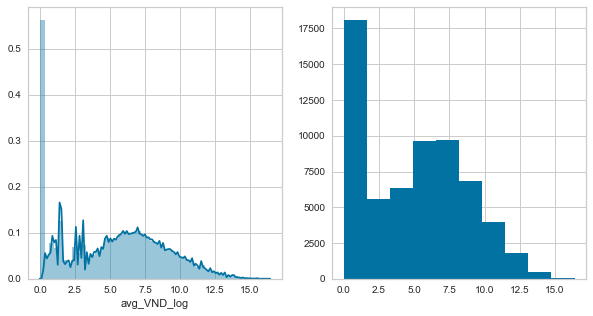


        ----------------------------------------
        Dispersion of min_VND_log: 15.26951356630802
        min_VND_log_median: 0.0
        min_VND_log_mode: 0    0.0
dtype: float64
        min_VND_log_Q1: 0.0
        min_VND_log_Q3: 3.5624726213562625
        min_VND_log_IQR: 3.5624726213562625
        min_VND_log_var: 5.470265361133592
        min_VND_log_std: 2.3388598421311166
        Number of upper outlier: 631, takes 1.009% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 631, takes 1.009% of total sample.
        ----------------------------------------
        


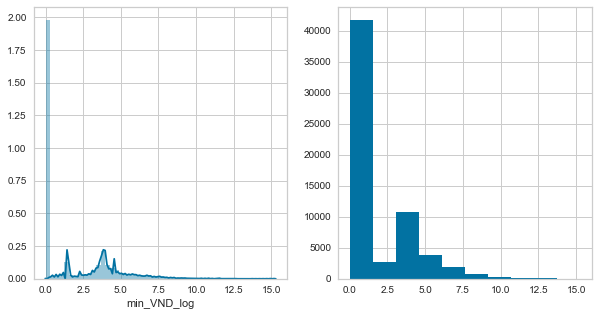


        ----------------------------------------
        Dispersion of max_VND_log: 18.17996385712352
        max_VND_log_median: 7.7629019793463705
        max_VND_log_mode: 0    0.0
dtype: float64
        max_VND_log_Q1: 2.6191638624143274
        max_VND_log_Q3: 9.991879148306186
        max_VND_log_IQR: 7.372715285891859
        max_VND_log_var: 17.60503173606295
        max_VND_log_std: 4.195835046336182
        Number of upper outlier: 0, takes 0.0% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 0, takes 0.0% of total sample.
        ----------------------------------------
        


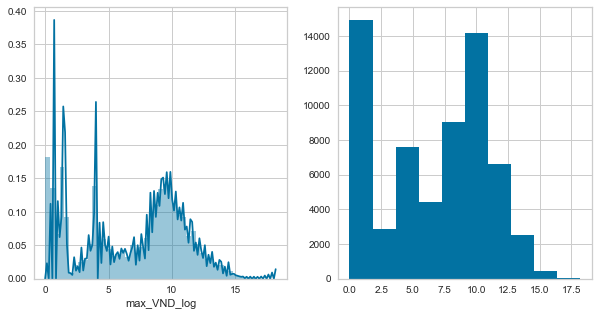


        ----------------------------------------
        Dispersion of avg_USD_log: 13.336374445155267
        avg_USD_log_median: 0.0
        avg_USD_log_mode: 0    0.0
dtype: float64
        avg_USD_log_Q1: 0.0
        avg_USD_log_Q3: 0.0
        avg_USD_log_IQR: 0.0
        avg_USD_log_var: 0.3872237707877682
        avg_USD_log_std: 0.6222730677024101
        Number of upper outlier: 385, takes 0.6156% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 385, takes 0.6156% of total sample.
        ----------------------------------------
        


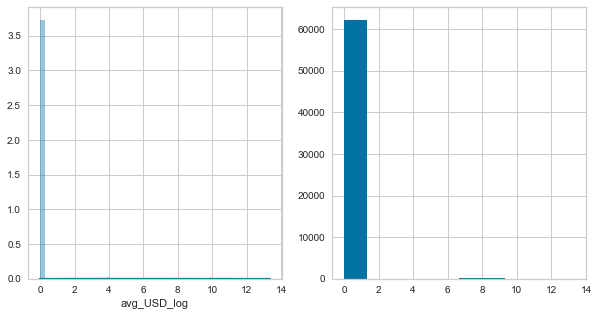


        ----------------------------------------
        Dispersion of min_USD_log: 13.153794212705813
        min_USD_log_median: 0.0
        min_USD_log_mode: 0    0.0
dtype: float64
        min_USD_log_Q1: 0.0
        min_USD_log_Q3: 0.0
        min_USD_log_IQR: 0.0
        min_USD_log_var: 0.13206898017672328
        min_USD_log_std: 0.36341296093662273
        Number of upper outlier: 181, takes 0.2894% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 181, takes 0.2894% of total sample.
        ----------------------------------------
        


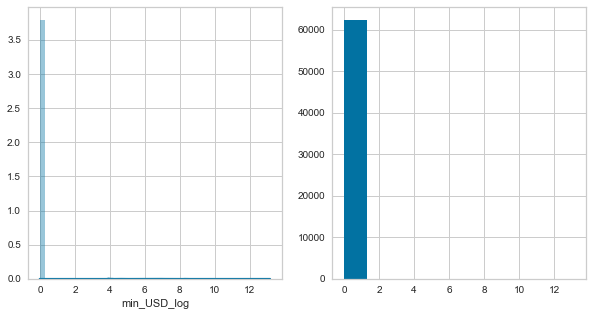


        ----------------------------------------
        Dispersion of max_USD_log: 13.458835614025542
        max_USD_log_median: 0.0
        max_USD_log_mode: 0    0.0
dtype: float64
        max_USD_log_Q1: 0.0
        max_USD_log_Q3: 0.0
        max_USD_log_IQR: 0.0
        max_USD_log_var: 0.41491543467921116
        max_USD_log_std: 0.644139297574066
        Number of upper outlier: 385, takes 0.6156% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 385, takes 0.6156% of total sample.
        ----------------------------------------
        


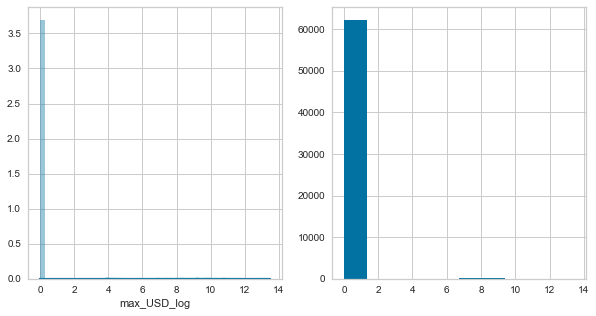


        ----------------------------------------
        Dispersion of avg_interest_log: 2.398770176920342
        avg_interest_log_median: 0.0
        avg_interest_log_mode: 0    0.0
dtype: float64
        avg_interest_log_Q1: 0.0
        avg_interest_log_Q3: 0.0
        avg_interest_log_IQR: 0.0
        avg_interest_log_var: 0.17071514582236835
        avg_interest_log_std: 0.4131768941051379
        Number of upper outlier: 4475, takes 7.156% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 4475, takes 7.156% of total sample.
        ----------------------------------------
        


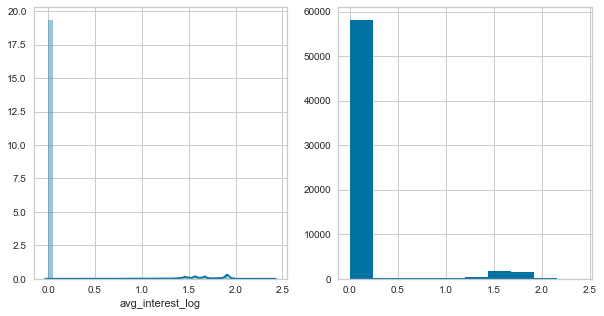

In [303]:
statistic_con(con_val_log)

### Ta có thể thấy việc lấy log đã hạn chế độ lớn giữa min và max cũng như hạn chế các outlier.

In [304]:
df = data[con_val]
df = make_log_column(df, con_val, prefix=True)
df = make_RobustScaler_column(df, con_val, prefix=True)
df = make_StandardScaler_column(df, con_val, prefix=True)

In [305]:
df.head()

avg_VND   min_VND     max_VND  avg_USD  min_USD  max_USD  \
0   4786.616838  1996.814  501997.314      0.0      0.0      0.0   
1    491.076354   425.364     555.064      0.0      0.0      0.0   
2    105.692233    97.762     108.762      0.0      0.0      0.0   
3  32377.561932  2091.601   72587.330      0.0      0.0      0.0   
4     63.580233    55.650      66.650      0.0      0.0      0.0   

   avg_interest  avg_VND_log  min_VND_log  max_VND_log  ...  min_USD_Rscale  \
0      0.223046     8.473579     7.599308    13.126350  ...             0.0   
1      0.209180     6.196600     6.052945     6.319083  ...             0.0   
2      0.300000     4.660531     4.582536     4.689162  ...             0.0   
3      0.217048    10.385221     7.645685    11.192546  ...             0.0   
4      0.300000     4.152303     4.019082     4.199455  ...             0.0   

   max_USD_Rscale  avg_interest_Rscale  avg_VND_Stscale  min_VND_Stscale  \
0             0.0             0.053003        -0.093825         0.024764   
1             0.0            -0.293596        -0.117517        -0.021652   
2             0.0             1.976532        -0.119643        -0.031328   
3             0.0            -0.096920         0.058353         0.027564   
4             0.0             1.976532        -0.119875        -0.032572   

   max_VND_Stscale  avg_USD_Stscale  min_USD_Stscale  max_USD_Stscale  \
0         0.521225        -0.022648        -0.012744        -0.023166   
1        -0.123303        -0.022648        -0.012744        -0.023166   
2        -0.123877        -0.022648        -0.012744        -0.023166   
3        -0.030717        -0.022648        -0.012744        -0.023166   
4        -0.123931        -0.022648        -0.012744        -0.023166   

   avg_interest_Stscale  
0             -0.263615  
1             -0.274299  
2             -0.204324  
3             -0.268237  
4             -0.204324  

[5 rows x 28 columns]

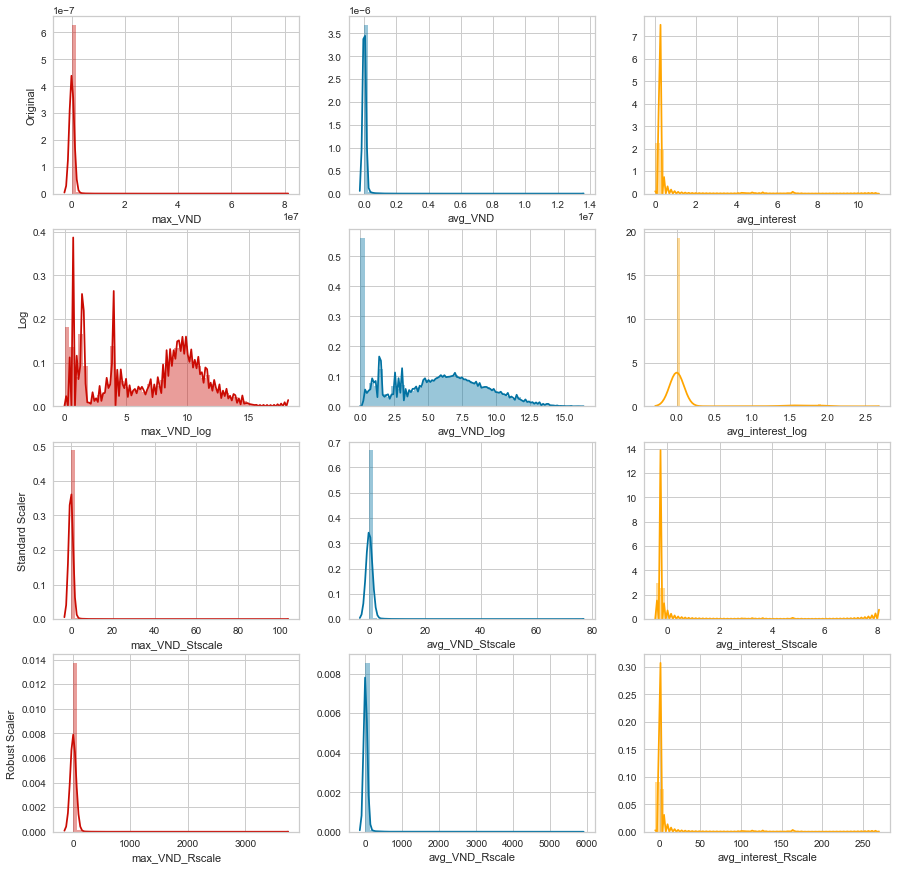

In [306]:
plt.figure(figsize=(15, 15))
plt.subplot(4,3,1)
sns.distplot(df['max_VND'], kde_kws={'bw': 900000}, color='r')
plt.ylabel('Original')
plt.subplot(4,3,2)
sns.distplot(df['avg_VND'], kde_kws={'bw': 90000}, color='b')
plt.subplot(4,3,3)
sns.distplot(df['avg_interest'], kde_kws={'bw': 0.0001}, color='orange')

plt.subplot(4,3,4)
plt.ylabel('Log')
sns.distplot(df['max_VND_log'], kde_kws={'bw': 0.01}, color='r')
plt.subplot(4,3,5)
sns.distplot(df['avg_VND_log'], kde_kws={'bw': 0.01}, color='b')
plt.subplot(4,3,6)
sns.distplot(df['avg_interest_log'], kde_kws={'bw': 0.095}, color='orange')

plt.subplot(4,3,7)
plt.ylabel('Standard Scaler')
sns.distplot(df['max_VND_Stscale'], kde_kws={'bw': 1}, color='r')
plt.subplot(4,3,8)
sns.distplot(df['avg_VND_Stscale'], kde_kws={'bw': 1.11}, color='b')
plt.subplot(4,3,9)
sns.distplot(df['avg_interest_Stscale'], kde_kws={'bw': 0.01}, color='orange')

plt.subplot(4,3,10)
plt.ylabel('Robust Scaler')
sns.distplot(df['max_VND_Rscale'], kde_kws={'bw': 50}, color='r')
plt.subplot(4,3,11)
sns.distplot(df['avg_VND_Rscale'], kde_kws={'bw': 50}, color='b')
plt.subplot(4,3,12)
sns.distplot(df['avg_interest_Rscale'], kde_kws={'bw': 0.01}, color='orange')
plt.show()
# plt.savefig()

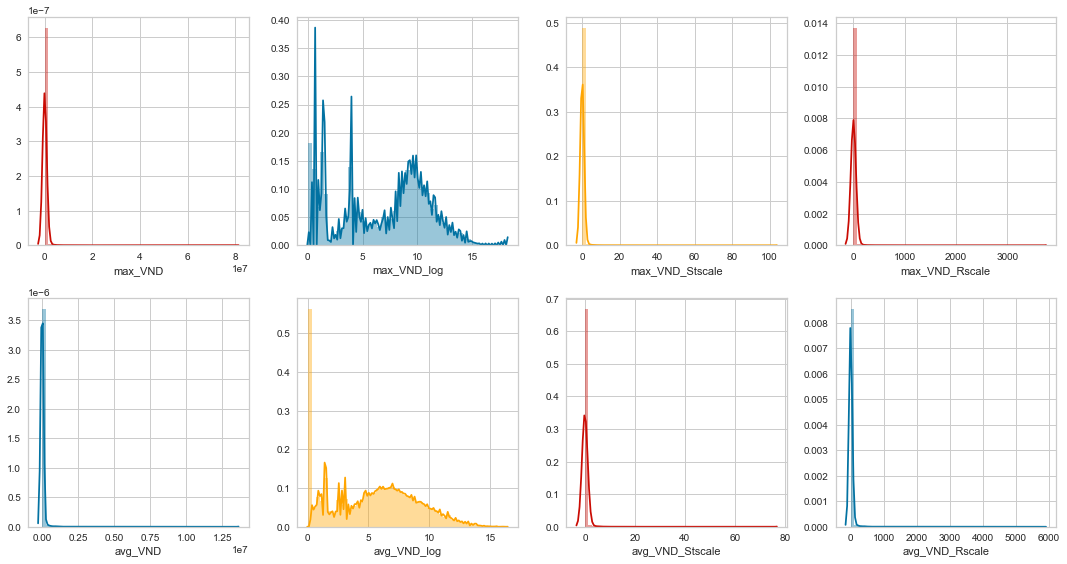

In [307]:
plt.figure(figsize=(15, 8))

plt.subplot(2,4,1)
sns.distplot(df['max_VND'], kde_kws={'bw': 900000}, color='r')
plt.subplot(2,4,2)
sns.distplot(df['max_VND_log'], kde_kws={'bw': 0.01}, color='b')
plt.subplot(2,4,3)
sns.distplot(df['max_VND_Stscale'], kde_kws={'bw': 1}, color='orange')
plt.subplot(2,4,4)
sns.distplot(df['max_VND_Rscale'], kde_kws={'bw': 50}, color='r')

plt.subplot(2,4,5)
sns.distplot(df['avg_VND'], kde_kws={'bw': 90000}, color='b')
plt.subplot(2,4,6)
sns.distplot(df['avg_VND_log'], kde_kws={'bw': 0.01}, color='orange')
plt.subplot(2,4,7)
sns.distplot(df['avg_VND_Stscale'], kde_kws={'bw': 1.11}, color='r')
plt.subplot(2,4,8)
sns.distplot(df['avg_VND_Rscale'], kde_kws={'bw': 50}, color='b')
plt.tight_layout()

# plt.savefig('histogram_comparingscaler.png')

In [308]:
con_val_Stscale = [val for val in df.columns.tolist() if '_Stscale' in val]
con_val_Rscale = [val for val in df.columns.tolist() if '_Rscale' in val]

In [309]:
df = make_RobustScaler_column(df, con_val_log, prefix=True)
df = make_StandardScaler_column(df, con_val_log, prefix=True)

In [310]:
str(df.columns)

"Index(['avg_VND', 'min_VND', 'max_VND', 'avg_USD', 'min_USD', 'max_USD',\n       'avg_interest', 'avg_VND_log', 'min_VND_log', 'max_VND_log',\n       'avg_USD_log', 'min_USD_log', 'max_USD_log', 'avg_interest_log',\n       'avg_VND_Rscale', 'min_VND_Rscale', 'max_VND_Rscale', 'avg_USD_Rscale',\n       'min_USD_Rscale', 'max_USD_Rscale', 'avg_interest_Rscale',\n       'avg_VND_Stscale', 'min_VND_Stscale', 'max_VND_Stscale',\n       'avg_USD_Stscale', 'min_USD_Stscale', 'max_USD_Stscale',\n       'avg_interest_Stscale', 'avg_VND_log_Rscale', 'min_VND_log_Rscale',\n       'max_VND_log_Rscale', 'avg_USD_log_Rscale', 'min_USD_log_Rscale',\n       'max_USD_log_Rscale', 'avg_interest_log_Rscale', 'avg_VND_log_Stscale',\n       'min_VND_log_Stscale', 'max_VND_log_Stscale', 'avg_USD_log_Stscale',\n       'min_USD_log_Stscale', 'max_USD_log_Stscale',\n       'avg_interest_log_Stscale'],\n      dtype='object')"

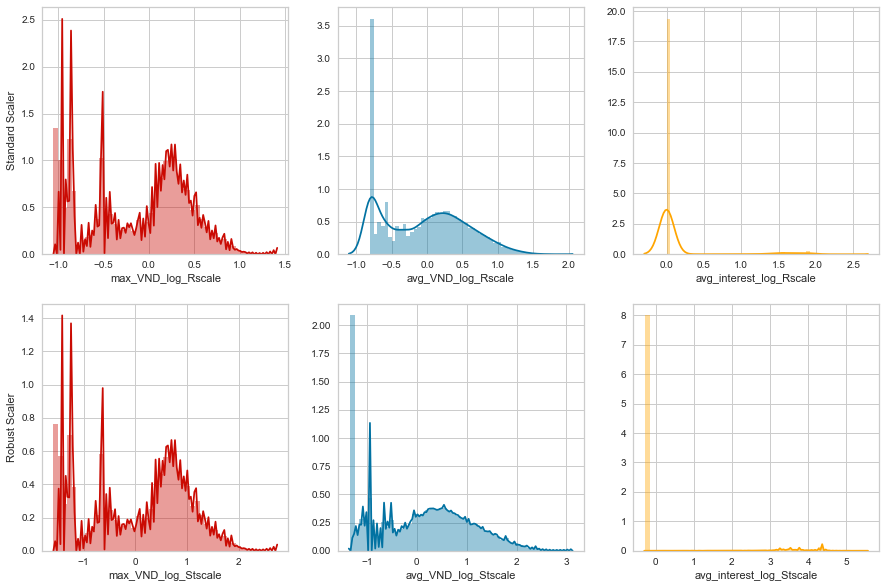

In [311]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('Standard Scaler')
sns.distplot(df['max_VND_log_Rscale'], kde_kws={'bw': 0.0001}, color='r')
plt.subplot(2, 3, 2)
sns.distplot(df['avg_VND_log_Rscale'], kde_kws={'bw': 0.1}, color='b')
plt.subplot(2, 3, 3)
sns.distplot(df['avg_interest_log_Rscale'], kde_kws={'bw': 0.1}, color='orange')

plt.subplot(2, 3, 4)
plt.ylabel('Robust Scaler')
sns.distplot(df['max_VND_log_Stscale'], kde_kws={'bw': 0.0001}, color='r')
plt.subplot(2, 3, 5)
sns.distplot(df['avg_VND_log_Stscale'], kde_kws={'bw': 0.01}, color='b')
plt.subplot(2, 3, 6)
sns.distplot(df['avg_interest_log_Stscale'], kde_kws={'bw': 0.01}, color='orange')

plt.show()

## Outliers handling:<a name="outlier"></a>

In [312]:
outliers = []
for variable in con_val_log:
    Q1 = np.percentile(data[variable], 25)
    Q3 = np.percentile(data[variable], 75)
    _IQR = Q3 - Q1
    upper_bound = (data[variable] >= Q3 + 1.5 * _IQR)
    lower_bound = (data[variable] <= Q1 - 1.5 * _IQR)
    if data[variable].loc[upper_bound | lower_bound].count() > 0:
        outliers.append(variable)

In [313]:
num_outliers(data, outliers)


        ----------------------------------------
        min_VND_log:
        Number of upper outlier: 631, takes 1.009% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 631, takes 1.009% of total sample.
        ----------------------------------------
        

        ----------------------------------------
        avg_USD_log:
        Number of upper outlier: 385, takes 0.6156% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 385, takes 0.6156% of total sample.
        ----------------------------------------
        

        ----------------------------------------
        min_USD_log:
        Number of upper outlier: 181, takes 0.2894% of total sample.
        Number of lower outlier: 0, takes 0.0% of total sample.
        Number of Total outlier: 181, takes 0.2894% of total sample.
        ----------------------------------------
        

        

In [314]:
data['avg_USD_log'].loc[data['avg_USD_log'] > 0].count()

385

In [315]:
data['label'].loc[data['avg_USD_log'] > 0].value_counts()

0.0    321
1.0     64
Name: label, dtype: int64

    Tuy số lượng các khách hàng có tài khoản USD ít nhưng có chứa các label của khách hàng không gửi tiền nên ta sẽ không bỏ các outlier này.

In [316]:
print('Number of rows have rate > 1%: ', data['avg_interest'][data['avg_interest'] > 1].count())
print('Number of rows have rate < = 0%: ', data['avg_interest'][data['avg_interest'] <= 1].count())

Number of rows have rate > 1%:  4475
Number of rows have rate < = 0%:  58061


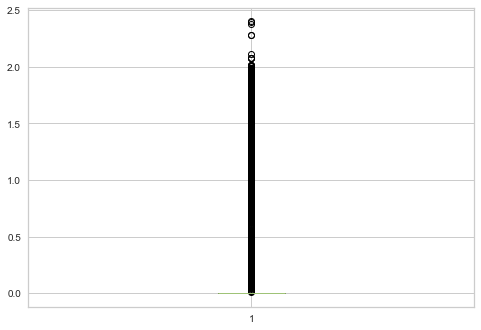

In [317]:
plt.boxplot(data['avg_interest_log'])
plt.show()

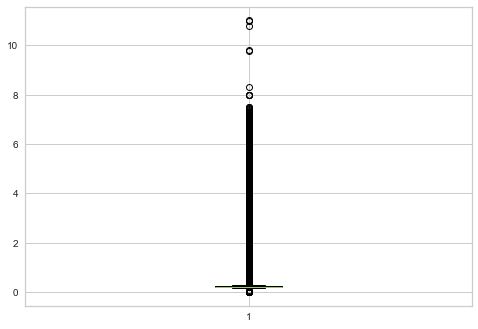

In [318]:
plt.boxplot(data['avg_interest'])
plt.show()

**Nhận xét:**

    * Lãi suất bình quân chủ yếu xuất là mức lãi suất dưới 1% : 58061 mẫu.
    * Lãi suất bình quân lớn hơn 1% : 4475 mẫu.

Ta có thể **chia bins** các mức lãi suất hoặc **loại bỏ** outlier.

### Ngoài các phương pháp phát hiện outlier truyền thống, ta có thể tham khảo ***khoảng cách Cook (Cook's Distance)*** để đo lường các giá trị outlier.
https://medium.com/@lymielynn/a-little-closer-to-cooks-distance-e8cc923a3250

In [319]:
f = 'label ~ avg_interest'

model = smf.ols(formula=f, data=data).fit()

print ('R-Squared:', model.rsquared)
print (model.params)

R-Squared: 0.012756191823503404
Intercept       0.151676
avg_interest    0.032700
dtype: float64


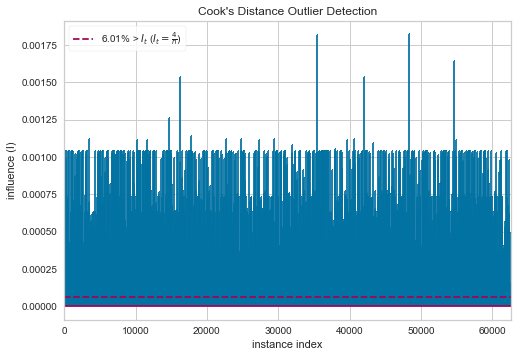

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [320]:
X = data["avg_interest"].values.reshape(-1,1)
y = data["label"]

visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

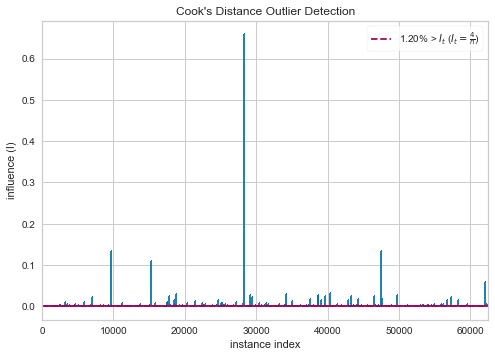

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [321]:
X = data["avg_VND"].values.reshape(-1,1)
y = data["label"]

visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

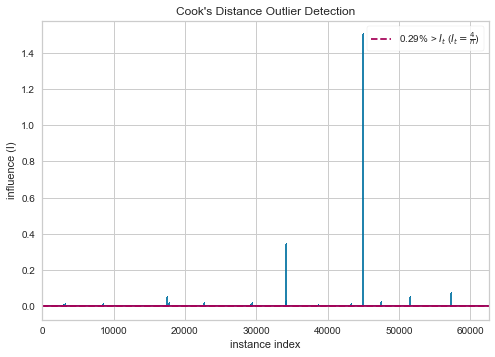

In [322]:
X = data["max_VND"].values.reshape(-1,1)
y = data["label"]

visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show('cookDistance.png')

In [323]:
print('Outlier value: ', data["max_VND"].max())
print('ID row of max value:', data["max_VND"].idxmax())

Outlier value:  78606414.0
ID row of max value: 44878


In [324]:
i = 1
for cat in cat_val[:-1]:
    count = data[cat].sum()
    print('%i. %s: %i' % (i, cat, count))
    i += 1

1. 0_MaGD: 46307
2. 10_MaGD: 211
3. 11_MaGD: 302
4. 12_MaGD: 24
5. 13_MaGD: 52
6. 14_MaGD: 52
7. 15_MaGD: 66
8. 16_MaGD: 4
9. 17_MaGD: 35
10. 18_MaGD: 19
11. 19_MaGD: 17
12. 1_MaGD: 12371
13. 20_MaGD: 11
14. 21_MaGD: 17
15. 22_MaGD: 6
16. 23_MaGD: 5
17. 24_MaGD: 1
18. 25_MaGD: 1
19. 26_MaGD: 1
20. 27_MaGD: 2
21. 28_MaGD: 1
22. 29_MaGD: 0
23. 2_MaGD: 1516
24. 30_MaGD: 1
25. 31_MaGD: 1
26. 32_MaGD: 1
27. 3_MaGD: 2273
28. 4_MaGD: 1971
29. 5_MaGD: 936
30. 6_MaGD: 937
31. 7_MaGD: 406
32. 8_MaGD: 471
33. 9_MaGD: 195
34. 00_PGD: 35545
35. 02_PGD: 4587
36. 03_PGD: 13412
37. 05_PGD: 2315
38. 06_PGD: 1502
39. 07_PGD: 2682
40. 08_PGD: 3057
41. DA_NghiepVuChiTiet: 60350
42. SA_NghiepVuChiTiet: 4693
43. GIOITINH: 29925
44. Account_Management: 286


In [325]:
# Kiểm tra các giá trị có tần số xuất hiện <= 10.
delcol = []
for cat in cat_val[:-1]:
    count = data[cat].sum()
    if count <= 10:
        delcol.append(cat)
print(delcol)

['16_MaGD', '22_MaGD', '23_MaGD', '24_MaGD', '25_MaGD', '26_MaGD', '27_MaGD', '28_MaGD', '29_MaGD', '30_MaGD', '31_MaGD', '32_MaGD']


In [326]:
# Nếu các cột này có label = 1 thì sẽ giữ lại để tiếp tục phân tích, không thì sẽ được loại bỏ khỏi mô hình để tránh gây nhiễu
for col in delcol:
    if data[(data[col] == 1) & (data['label'] == 1)].shape[0] > 0:
        print(col)

16_MaGD
22_MaGD
23_MaGD


In [327]:
for col in delcol:
    if data[(data[col] == 1) & (data['label'] == 1)].shape[0] > 0:
        delcol.remove(col)

In [328]:
i = 1
for cat in delcol[:-1]:
    count = data[cat].sum()
    print('%i. %s: %i' % (i, cat, count))
    i += 1

1. 22_MaGD: 6
2. 24_MaGD: 1
3. 25_MaGD: 1
4. 26_MaGD: 1
5. 27_MaGD: 2
6. 28_MaGD: 1
7. 29_MaGD: 0
8. 30_MaGD: 1
9. 31_MaGD: 1


In [329]:
data.drop(delcol, axis=1, inplace=True)

In [531]:
str(delcol)

"['22_MaGD', '24_MaGD', '25_MaGD', '26_MaGD', '27_MaGD', '28_MaGD', '29_MaGD', '30_MaGD', '31_MaGD', '32_MaGD']"

In [331]:
# Xóa các giá trị cột trong list cat_val
for i in delcol:
    cat_val.remove(i)

In [332]:
# Vì mã tài khoản 12_MaGD là mã số cũ của 0_MaGD nên chuyển từ 12_MaGD qua 0_MaGD và drop 12_MaGD
data['0_MaGD'].loc[data['12_MaGD'] != 0] = 1
data.drop('12_MaGD', axis=1, inplace=True)
cat_val.remove('12_MaGD')

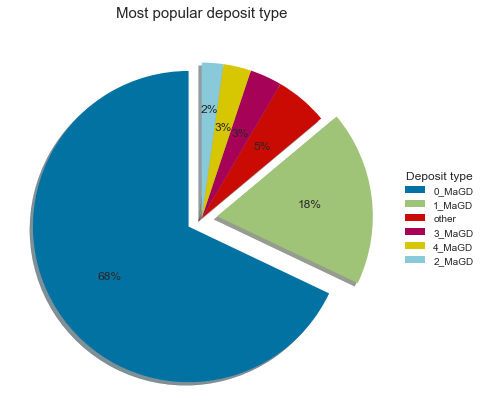

In [333]:
# Sử dụng regular expression để lọc các mã tiền gửi trong list cat_val (có định dạng _MaGD)
maTienGui = [re.findall('.*_MaGD', x)[0] for x in cat_val if re.findall('.*_MaGD', x) != []]
pie_chart_maTienGui = data[maTienGui].sum()
pie_chart_maTienGui
pie_chart_maTienGui['other'] = 0
for i in range(pie_chart_maTienGui.count()):
    if pie_chart_maTienGui[i] < 1000:
        pie_chart_maTienGui['other'] += pie_chart_maTienGui[i]

# filter các mã có số lượng > 1000
pie_chart_maTienGui = pie_chart_maTienGui[pie_chart_maTienGui >= 1000]
pie_chart_maTienGui.sort_values(ascending=False, inplace=True)

# Plot pie chart
plt.figure(figsize=(10, 6))
explode = [0.1, 0.1, 0, 0, 0, 0]
patches, texts, autotexts = plt.pie(pie_chart_maTienGui,
                                    explode=explode, shadow=True, 
                                    startangle=90, autopct='%1.0f%%')

plt.legend(patches, pie_chart_maTienGui.index,
          title="Deposit type",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Most popular deposit type', fontsize=15)
plt.tight_layout()

for patch, txt in zip(patches, autotexts):
    # the angle at which the text is located
    ang = (patch.theta2 + patch.theta1) / 2.
    # new coordinates of the text, 0.7 is the distance from the center 
    x = patch.r * 0.7 * np.cos(ang*np.pi/180)
    y = patch.r * 0.7 * np.sin(ang*np.pi/180)
    # if patch is narrow enough, move text to new coordinates
    if (patch.theta2 - patch.theta1) < 10.:
        txt.set_position((x, y))

        plt.savefig('piechart_mostpopulardeposittype.png')

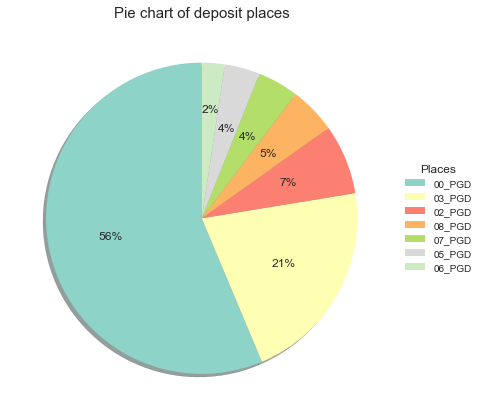

In [334]:
# Sử dụng regular expression để lọc các mã tiền gửi trong list cat_val (có định dạng _PGD)
maNoiGui = [re.findall('.*_PGD', x)[0] for x in cat_val if re.findall('.*_PGD', x) != []]
pie_chart_maNoiGui = data[maNoiGui].sum()

pie_chart_maNoiGui.sort_values(ascending=False, inplace=True)

# Plot pie chart
cs=cm.Set3(np.arange(7)/7.)
plt.figure(figsize=(10, 6))
explode = [0.1, 0.1, 0, 0, 0, 0]
patches, texts, autotexts = plt.pie(pie_chart_maNoiGui, shadow=True, 
                                    startangle=90, autopct='%1.0f%%', colors=cs)

plt.legend(patches, pie_chart_maNoiGui.index,
          title="Places",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Pie chart of deposit places', fontsize=15)

for patch, txt in zip(patches, autotexts):
    # the angle at which the text is located
    ang = (patch.theta2 + patch.theta1) / 2.
    # new coordinates of the text, 0.7 is the distance from the center 
    x = patch.r * 0.7 * np.cos(ang*np.pi/180)
    y = patch.r * 0.7 * np.sin(ang*np.pi/180)
    # if patch is narrow enough, move text to new coordinates
    if (patch.theta2 - patch.theta1) < 10.:
        txt.set_position((x, y))
plt.tight_layout()
plt.savefig('piechart_places.png')

Trong số các khách hàng có:
* 56% khách gửi tại 00, 
* 21% gửi tại 03,
* 7% chọn 02, 
* 5% gửi tại 08,
* 4% khách gửi có tiền gửi tại 07 và 05,
* còn lại 06 chiếm 2%.

# Bi-variate Analysis

## Categorical - Categorical

In [335]:
str(cat_val[:-1])

"['0_MaGD', '10_MaGD', '11_MaGD', '13_MaGD', '14_MaGD', '15_MaGD', '16_MaGD', '17_MaGD', '18_MaGD', '19_MaGD', '1_MaGD', '20_MaGD', '21_MaGD', '23_MaGD', '2_MaGD', '3_MaGD', '4_MaGD', '5_MaGD', '6_MaGD', '7_MaGD', '8_MaGD', '9_MaGD', '00_PGD', '02_PGD', '03_PGD', '05_PGD', '06_PGD', '07_PGD', '08_PGD', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet', 'GIOITINH', 'Account_Management']"

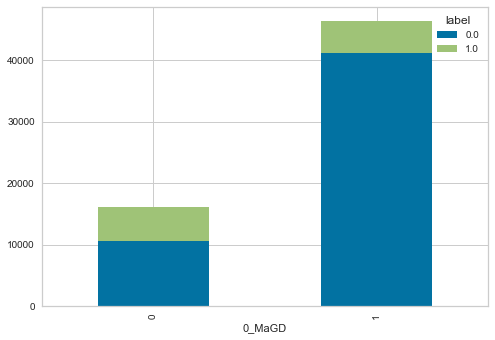

0_MaGD and label Dependent.


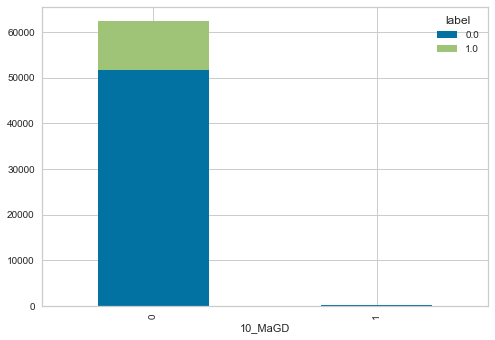

10_MaGD and label Independent.


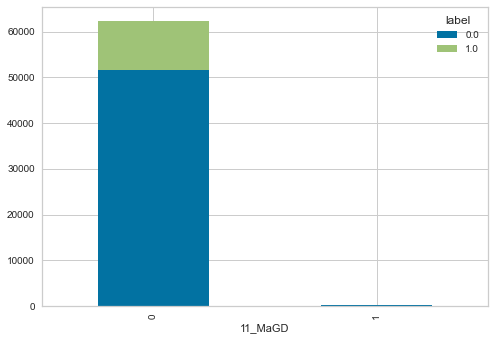

11_MaGD and label Dependent.


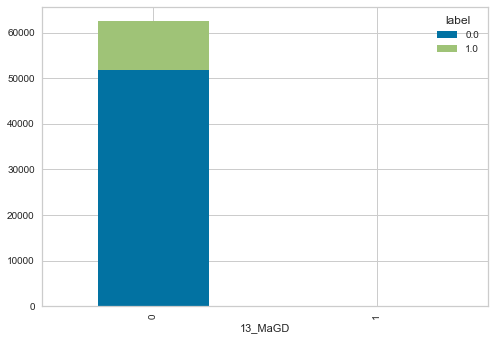

13_MaGD and label Independent.


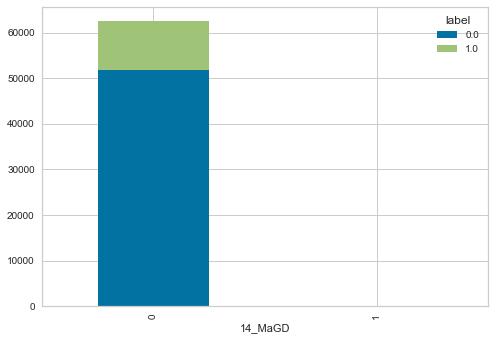

14_MaGD and label Independent.


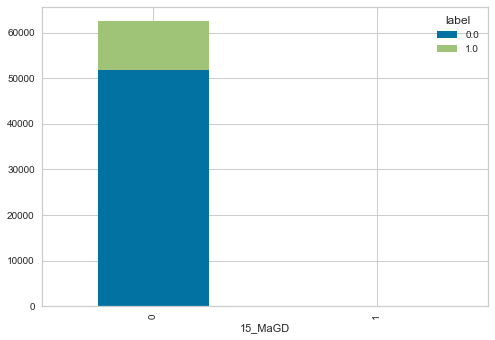

15_MaGD and label Dependent.


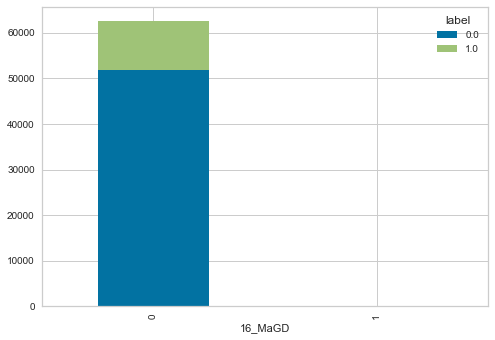

16_MaGD and label Independent.


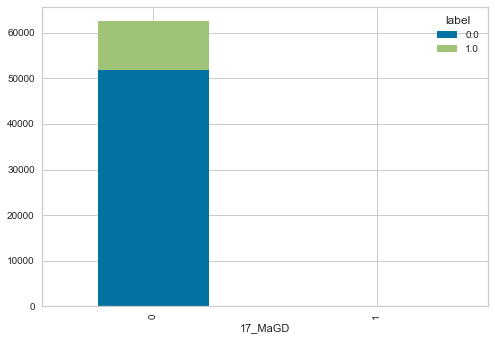

17_MaGD and label Independent.


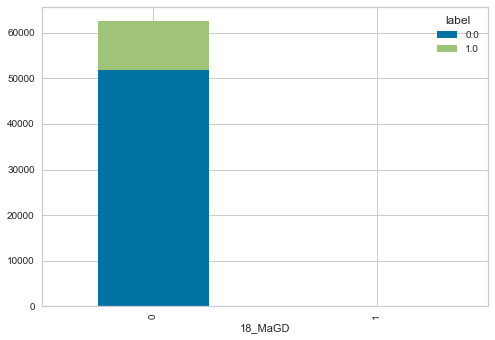

18_MaGD and label Independent.


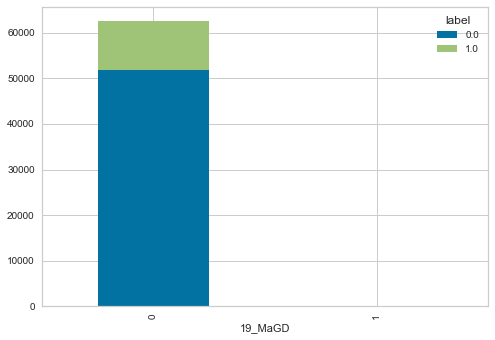

19_MaGD and label Independent.


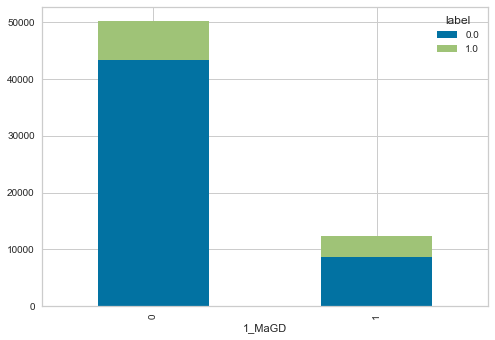

1_MaGD and label Dependent.


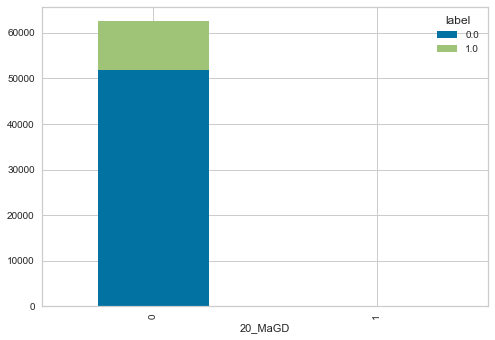

20_MaGD and label Independent.


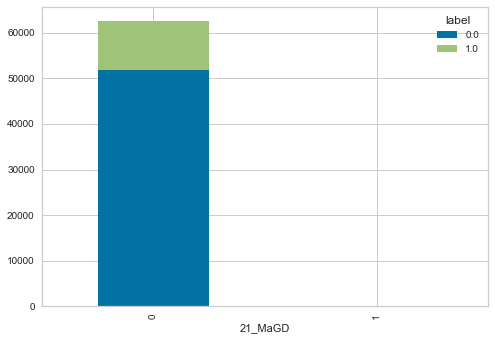

21_MaGD and label Independent.


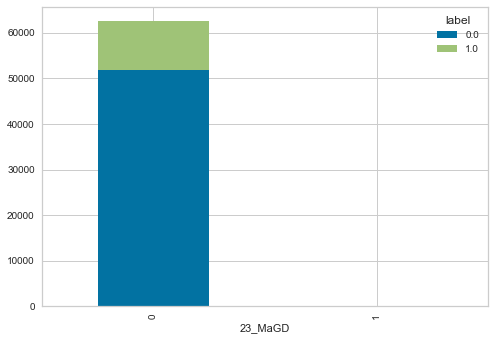

23_MaGD and label Independent.


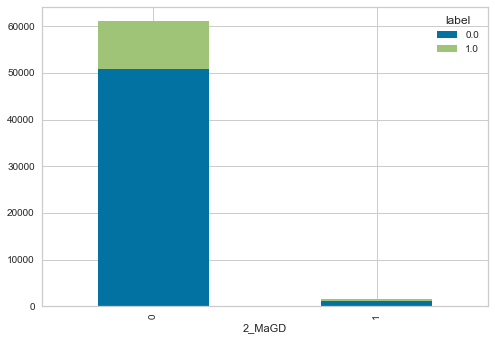

2_MaGD and label Dependent.


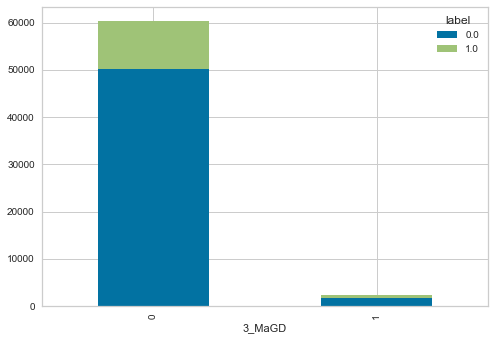

3_MaGD and label Dependent.


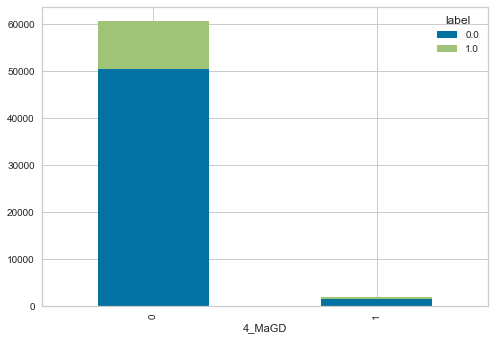

4_MaGD and label Dependent.


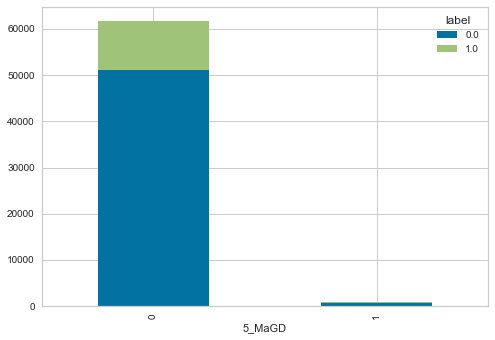

5_MaGD and label Independent.


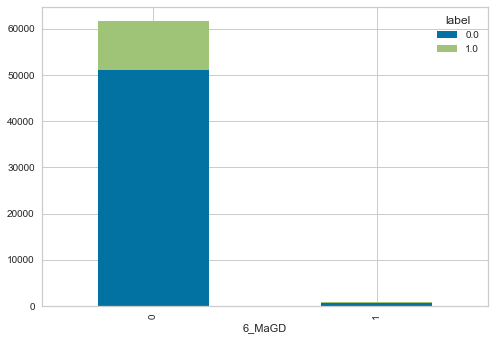

6_MaGD and label Dependent.


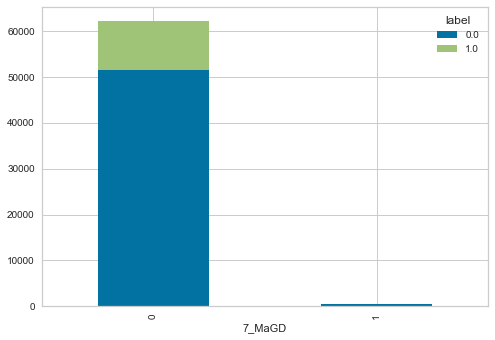

7_MaGD and label Dependent.


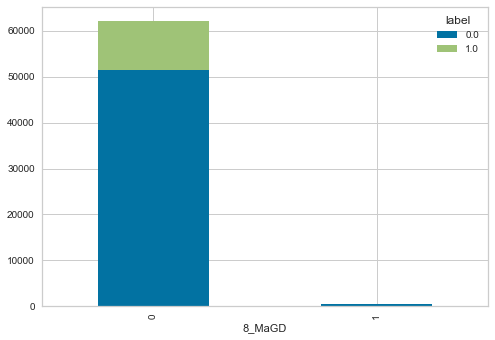

8_MaGD and label Dependent.


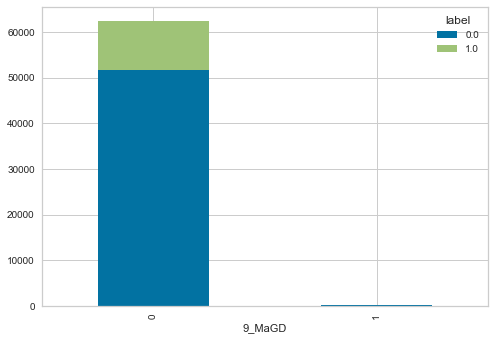

9_MaGD and label Independent.


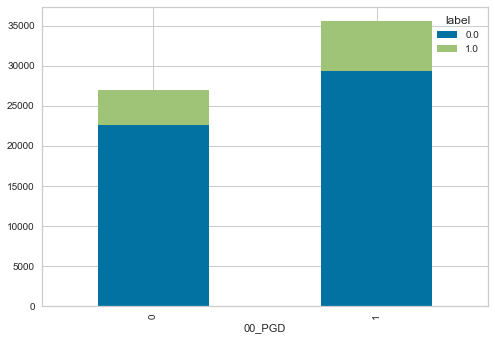

00_PGD and label Dependent.


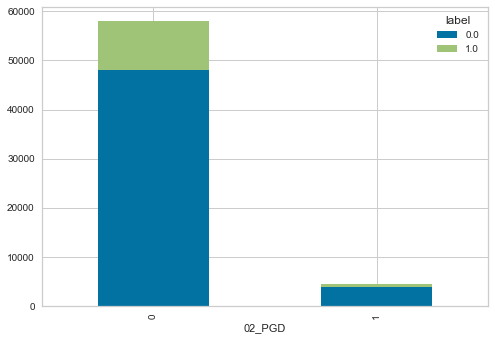

02_PGD and label Dependent.


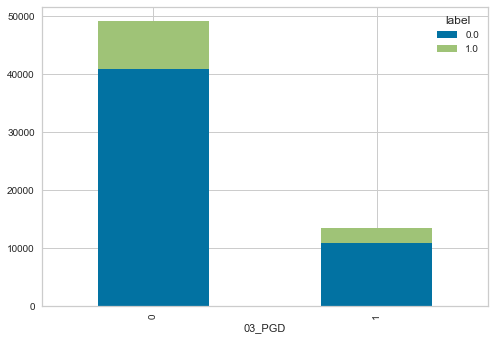

03_PGD and label Dependent.


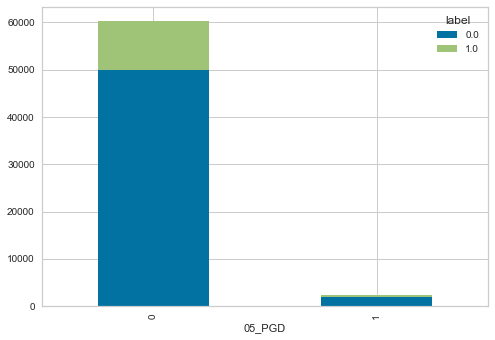

05_PGD and label Dependent.


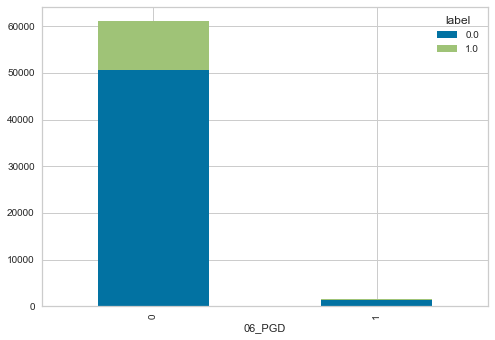

06_PGD and label Dependent.


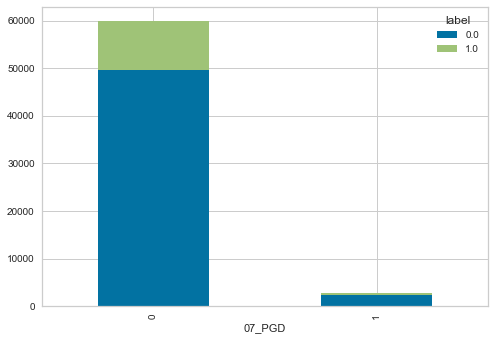

07_PGD and label Dependent.


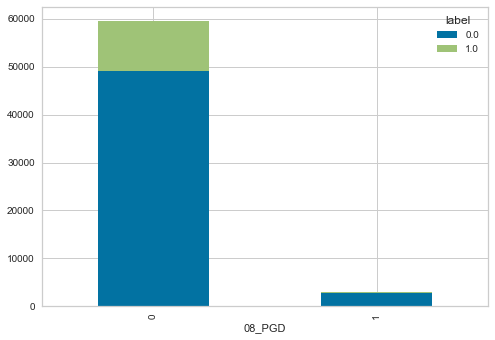

08_PGD and label Dependent.


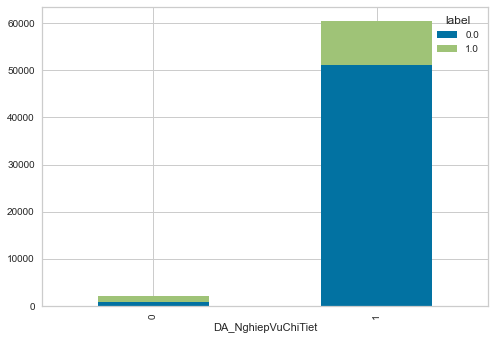

DA_NghiepVuChiTiet and label Dependent.


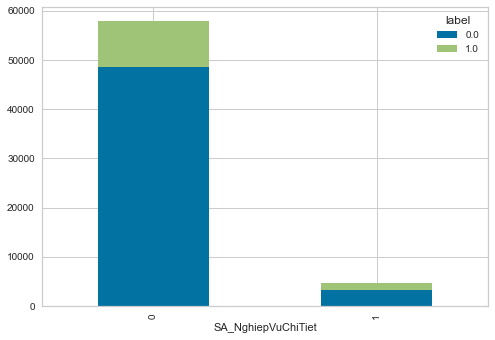

SA_NghiepVuChiTiet and label Dependent.


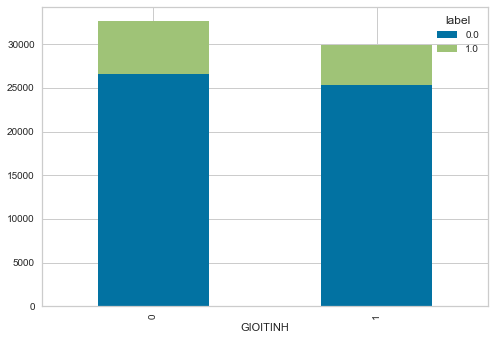

GIOITINH and label Dependent.


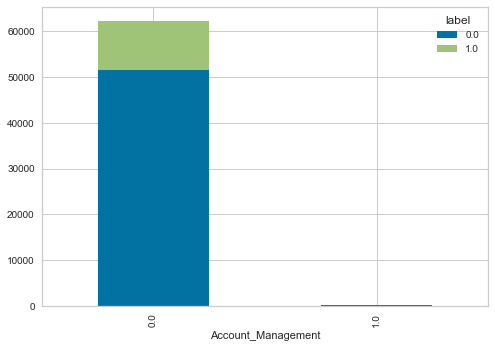

Account_Management and label Dependent.


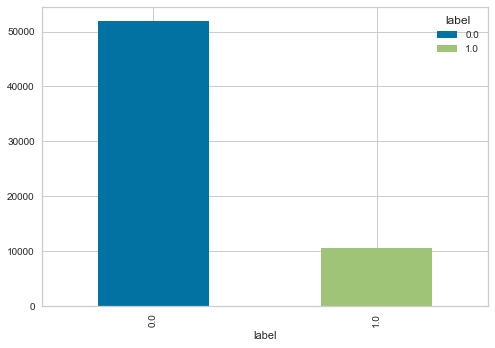

label and label Dependent.


In [336]:
cate_cate_analysing(data, cat_val, 'label')

In [337]:
# Kiểm định chi bình phương:
cat_depend_list = []
cat_independ_list = []
p_list = []
for var1 in cat_val[:-1]:
    table_FB = pd.crosstab(data[var1], data['label'])
    # Chi-square test:
    stat, p, dof, expected = chi2_contingency(table_FB)
    # Hypothesis testing using p-value:
    alpha = 0.05
    p_list.append(p)
    if p >= alpha:
        cat_independ_list.append(var1)
    else:
        cat_depend_list.append(var1)

In [338]:
df_p_h_testig = pd.DataFrame([cat_val[:-1], p_list])
df_p_h_testig = df_p_h_testig.T

In [339]:
df_p_h_testig['results'] = df_p_h_testig.loc[:,1].map(lambda x: 'Bác bỏ H0' if x < alpha else 'Chấp nhận H0')

In [340]:
df_p_h_testig

0             1       results
0               0_MaGD             0     Bác bỏ H0
1              10_MaGD       0.53226  Chấp nhận H0
2              11_MaGD   2.77309e-10     Bác bỏ H0
3              13_MaGD      0.385971  Chấp nhận H0
4              14_MaGD      0.809838  Chấp nhận H0
5              15_MaGD   0.000436746     Bác bỏ H0
6              16_MaGD      0.275589  Chấp nhận H0
7              17_MaGD      0.837599  Chấp nhận H0
8              18_MaGD      0.870493  Chấp nhận H0
9              19_MaGD      0.695033  Chấp nhận H0
10              1_MaGD             0     Bác bỏ H0
11             20_MaGD      0.765473  Chấp nhận H0
12             21_MaGD      0.799892  Chấp nhận H0
13             23_MaGD      0.439718  Chấp nhận H0
14              2_MaGD   4.66017e-35     Bác bỏ H0
15              3_MaGD   1.02996e-44     Bác bỏ H0
16              4_MaGD    2.0125e-08     Bác bỏ H0
17              5_MaGD      0.212275  Chấp nhận H0
18              6_MaGD   3.74876e-05     Bác bỏ H0
19              7_MaGD   1.21401e-10     Bác bỏ H0
20              8_MaGD   8.35811e-17     Bác bỏ H0
21              9_MaGD      0.896609  Chấp nhận H0
22              00_PGD   7.54731e-05     Bác bỏ H0
23              02_PGD     0.0373125     Bác bỏ H0
24              03_PGD   1.55404e-07     Bác bỏ H0
25              05_PGD     0.0459202     Bác bỏ H0
26              06_PGD     0.0147659     Bác bỏ H0
27              07_PGD   8.34329e-10     Bác bỏ H0
28              08_PGD   2.55066e-25     Bác bỏ H0
29  DA_NghiepVuChiTiet             0     Bác bỏ H0
30  SA_NghiepVuChiTiet  4.99782e-128     Bác bỏ H0
31            GIOITINH   8.83121e-25     Bác bỏ H0
32  Account_Management    0.00416977     Bác bỏ H0

In [341]:
str(cat_independ_list)

"['10_MaGD', '13_MaGD', '14_MaGD', '16_MaGD', '17_MaGD', '18_MaGD', '19_MaGD', '20_MaGD', '21_MaGD', '23_MaGD', '5_MaGD', '9_MaGD']"

In [342]:
str(cat_depend_list)

"['0_MaGD', '11_MaGD', '15_MaGD', '1_MaGD', '2_MaGD', '3_MaGD', '4_MaGD', '6_MaGD', '7_MaGD', '8_MaGD', '00_PGD', '02_PGD', '03_PGD', '05_PGD', '06_PGD', '07_PGD', '08_PGD', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet', 'GIOITINH', 'Account_Management']"

**Nhận xét:**

    * Qua phân tích kiểm định chi bình phương và đồ thị giữa 2 biến categorical, ta có thể kết luận được rằng có bằng chứng thống kê cho thấy có mối quan hệ có ý nghĩa giữa các biến '0_MaGD', '11_MaGD', '15_MaGD', '1_MaGD', '2_MaGD', '3_MaGD', '4_MaGD', '6_MaGD', '7_MaGD', '8_MaGD', '00_PGD', '02_PGD', '03_PGD', '05_PGD', '06_PGD', '07_PGD', '08_PGD', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet', 'GIOITINH', 'Account_Management' và label.

In [343]:
a = data.groupby('label')[maTienGui].sum()
for c in a.columns:
    a[c] = a[c].map(lambda x: round(x/a[c].sum()*100, 2))
a = a.sort_values(1, axis = 1, ascending=True)

In [344]:
a

15_MaGD  8_MaGD  7_MaGD  0_MaGD  13_MaGD  21_MaGD  10_MaGD  18_MaGD  \
label                                                                        
0.0      100.0   97.45   95.07   89.03    88.46    88.24    84.83    84.21   
1.0        0.0    2.55    4.93   10.97    11.54    11.76    15.17    15.79   

       9_MaGD  17_MaGD  ...  14_MaGD  4_MaGD  6_MaGD  19_MaGD  3_MaGD  2_MaGD  \
label                   ...                                                     
0.0     83.59    82.86  ...    80.77   78.29   77.91    76.47   72.11   71.17   
1.0     16.41    17.14  ...    19.23   21.71   22.09    23.53   27.89   28.83   

       1_MaGD  11_MaGD  23_MaGD  16_MaGD  
label                                     
0.0     69.61    69.21     60.0     50.0  
1.0     30.39    30.79     40.0     50.0  

[2 rows x 22 columns]

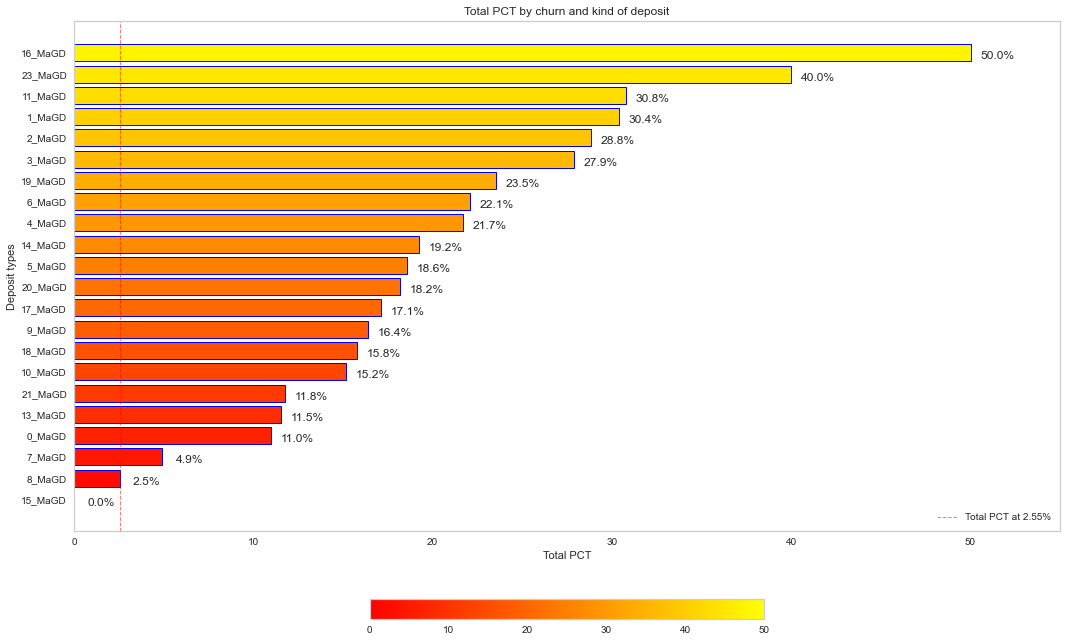

In [345]:
plt.figure(figsize=(15, 10))
N = len(a.columns)
label_1 = a.loc[1].tolist()

plot = plt.scatter(label_1, label_1, c = label_1, cmap = 'autumn')
plt.clf()
plt.colorbar(plot, shrink=0.4, orientation="horizontal", pad=0.1)

ind = np.arange(N)  
width = 0.5       

colors = cm.autumn(np.arange(22) / 22.0)

plt.barh(ind, label_1, color=colors,
         edgecolor='blue', linewidth=1)

plt.axvline(min(x for x in label_1 if x >0), linestyle = '--',
            color='red', label=f'Total PCT at {min(x for x in label_1 if x >0)}%', linewidth=1, alpha=0.5)

plt.xlabel('Total PCT')
plt.ylabel('Deposit types')

plt.title('Total PCT by churn and kind of deposit', fontsize=12)
plt.yticks(ind, a.columns)
plt.grid(False)
plt.legend(loc='lower right')

for i, v in enumerate(label_1):
    plt.text(v+1.5, i-0.3, "%.1f%%" % v, ha="center")
      
plt.tight_layout()
plt.xlim(0, 55)
plt.savefig('barhChart_churnvsdepo.png')

In [346]:
b = data.groupby('label')[maNoiGui].sum()
for c in b.columns:
    b[c] = b[c].map(lambda x: round(x/b[c].sum()*100, 2))
b

00_PGD  02_PGD  03_PGD  05_PGD  06_PGD  07_PGD  08_PGD
label                                                        
0.0     82.46   84.11   81.47   84.54   85.35   87.36   89.89
1.0     17.54   15.89   18.53   15.46   14.65   12.64   10.11

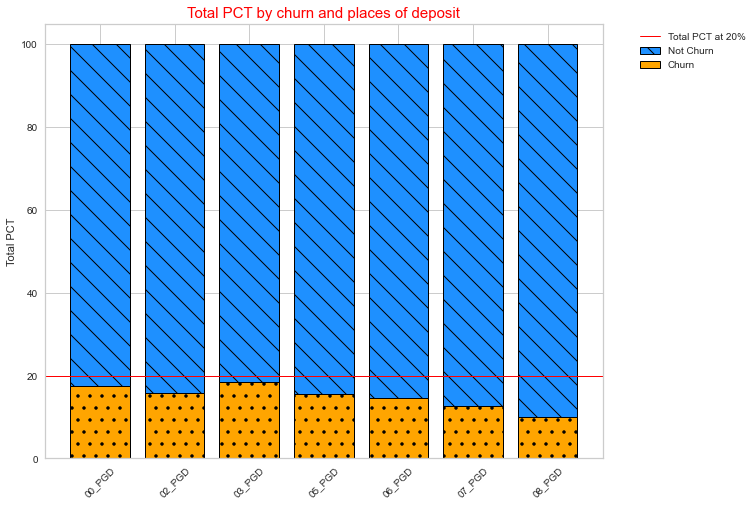

In [347]:
plt.figure(figsize=(10, 8))
N = len(b.columns)

label_0 = b.loc[0].tolist()
label_1 = b.loc[1].tolist()

ind = np.arange(N)  
width = 0.5       

p1 = plt.bar(ind, label_0, bottom=label_1, label="Not Churn", color='dodgerblue',
             edgecolor='black', linewidth=1, hatch='\\')
p2 = plt.bar(ind, label_1, label="Churn", color='orange',
             edgecolor='black', linewidth=1, hatch=".")

plt.axhline(20, color='red', label='Total PCT at 20%', linewidth=1)

plt.ylabel('Total PCT')
plt.title('Total PCT by churn and places of deposit', color='red', fontsize=15)
plt.xticks(ind, b.columns, rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

** Nhận xét:**<br>
    * Nơi giao dịch số 03 có tỷ trọng khách hàng rút tiền lớn nhất.
    * Nơi giao dịch số 08 có tỷ trọng khách hàng rút tiền thấp nhất.

In [348]:
joint_prob_table_noiGD = data.groupby('label')[maNoiGui].sum()
count_value = joint_prob_table_noiGD.values.sum()
for c in joint_prob_table_noiGD.columns:
    joint_prob_table_noiGD[c] = joint_prob_table_noiGD[c].map(lambda x: round(x / count_value * 100, 3))
joint_prob_table_noiGD.loc['sum'] = joint_prob_table_noiGD.iloc[0:2].sum()
joint_prob_table_noiGD.loc[:, 'sum'] = joint_prob_table_noiGD.iloc[:, 0:7].sum(axis=1)

In [349]:
joint_prob_table_noiGD.loc['P(Churn/noiGD)'] = round(joint_prob_table_noiGD.iloc[1]/joint_prob_table_noiGD.iloc[2] * 100,3)

In [350]:
print('Bảng xác suất đồng thời của khách hàng churn tại các điểm giao dịch khác nhau.')
pprint(joint_prob_table_noiGD)

Bảng xác suất đồng thời của khách hàng churn tại các điểm giao dịch khác nhau.
                00_PGD  02_PGD  03_PGD  05_PGD  06_PGD  07_PGD  08_PGD     sum
label                                                                         
0.0             46.453   6.114  17.317   3.101   2.032   3.713   4.355  83.085
1.0              9.878   1.155   3.938   0.567   0.349   0.537   0.490  16.914
sum             56.331   7.269  21.255   3.668   2.381   4.250   4.845  99.999
P(Churn/noiGD)  17.536  15.889  18.527  15.458  14.658  12.635  10.114  16.914


Dòng P(Churn/noiGD) được diễn giải là xác suất churn của một khách hàng khi biết được nơi giao dịch của khách hàng đó. Ví dụ với một khách hàng từ nơi giao dịch mã 00_PGD thì xác suất rút tiền là 17.536 %.

In [351]:
joint_prob_table_noiGD

00_PGD  02_PGD  03_PGD  05_PGD  06_PGD  07_PGD  08_PGD     sum
label                                                                         
0.0             46.453   6.114  17.317   3.101   2.032   3.713   4.355  83.085
1.0              9.878   1.155   3.938   0.567   0.349   0.537   0.490  16.914
sum             56.331   7.269  21.255   3.668   2.381   4.250   4.845  99.999
P(Churn/noiGD)  17.536  15.889  18.527  15.458  14.658  12.635  10.114  16.914

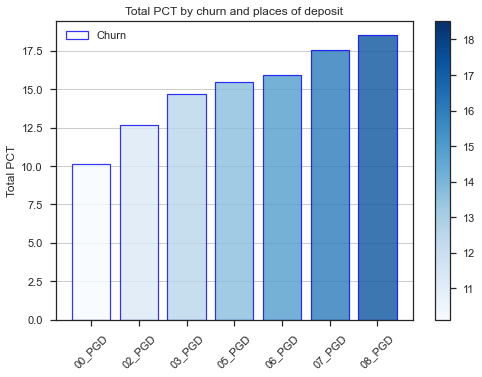

In [352]:
ind = np.arange(joint_prob_table_noiGD.shape[1] - 1)
colors = cm.Blues(np.arange(7) / 7.0)
list_PGD = joint_prob_table_noiGD.iloc[3, 0:7].tolist()
list_PGD.sort()
sns.set(style='ticks')
plot = plt.scatter(list_PGD, list_PGD, c = list_PGD, cmap = 'Blues')
plt.clf()
plt.colorbar(plot)

plt.bar(ind, list_PGD, label="Churn", color=colors,
             edgecolor='blue', linewidth=1.2, alpha=0.8)
plt.ylabel('Total PCT')
plt.title('Total PCT by churn and places of deposit', fontsize=12)
plt.xticks(ind, joint_prob_table_noiGD.columns[:-1], rotation=45)

plt.grid(axis='y')
plt.legend()
plt.show()

## Continuous - Categorical

In [353]:
con_val

['avg_VND',
 'min_VND',
 'max_VND',
 'avg_USD',
 'min_USD',
 'max_USD',
 'avg_interest']

In [354]:
model = ols('avg_VND ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_VND   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.35
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.30e-12
Time:                        13:12:35   Log-Likelihood:            -8.4589e+05
No. Observations:               62536   AIC:                         1.692e+06
Df Residuals:                   62534   BIC:                         1.692e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.947e+04    795.577     

In [355]:
model = ols('avg_USD ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7293
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.393
Time:                        13:12:35   Log-Likelihood:            -6.1508e+05
No. Observations:               62536   AIC:                         1.230e+06
Df Residuals:                   62534   BIC:                         1.230e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          95.4277     19.851     

In [356]:
model = ols('max_VND ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                max_VND   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     55.94
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           7.56e-14
Time:                        13:12:35   Log-Likelihood:            -9.3698e+05
No. Observations:               62536   AIC:                         1.874e+06
Df Residuals:                   62534   BIC:                         1.874e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.07e+05   3413.727     

In [357]:
model = ols('min_VND ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                min_VND   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.525
Date:                Tue, 24 Nov 2020   Prob (F-statistic):             0.0106
Time:                        13:12:35   Log-Likelihood:            -7.4097e+05
No. Observations:               62536   AIC:                         1.482e+06
Df Residuals:                   62534   BIC:                         1.482e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1314.9950    148.611     

In [358]:
model = ols('max_USD ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                max_USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1246
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.724
Time:                        13:12:36   Log-Likelihood:            -6.3211e+05
No. Observations:               62536   AIC:                         1.264e+06
Df Residuals:                   62534   BIC:                         1.264e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         133.7421     26.062     

In [359]:
model = ols('min_USD ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                min_USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.083
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.149
Time:                        13:12:36   Log-Likelihood:            -5.8332e+05
No. Observations:               62536   AIC:                         1.167e+06
Df Residuals:                   62534   BIC:                         1.167e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          41.7918     11.946     

In [360]:
model = ols('avg_interest ~ C(label)', data=data).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_interest   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     808.0
Date:                Tue, 24 Nov 2020   Prob (F-statistic):          1.31e-176
Time:                        13:12:36   Log-Likelihood:            -1.0464e+05
No. Observations:               62536   AIC:                         2.093e+05
Df Residuals:                   62534   BIC:                         2.093e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4988      0.006     

In [361]:
str(con_val)

"['avg_VND', 'min_VND', 'max_VND', 'avg_USD', 'min_USD', 'max_USD', 'avg_interest']"

**Nhận xét:**
    
    * Qua phân tích giữa các cặp continuous và categorical thông qua kiểm định z-test, với mức ý nghĩa alpha = 0.05. các biến với P_value < 0.05 có ý nghĩa thống kê cho thấy có mối quan hệ có ý nghĩa giữa *avg_VND_log, max_VND_log, min_VND_log, avg_interest* và *label*.
    
*Ta có thể trực quan hóa các nhận định trên qua các đồ thị:*

Đồ thị trên cho thấy khách hàng nữ trung bình tiền gửi của khách hàng cao thì có xu hướng rút tiền hơn các khách hàng có trung bình tiền gửi thấp.

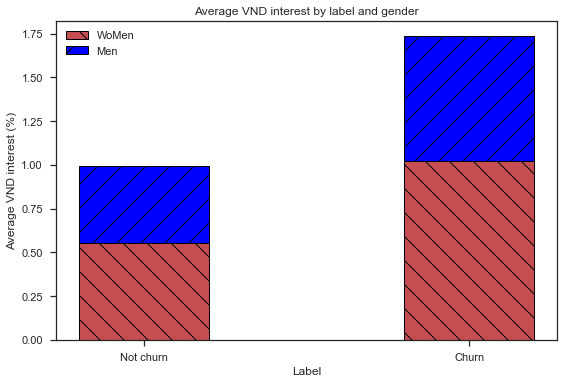

In [362]:
a = data.groupby(['GIOITINH', 'label']).avg_interest.mean().to_frame()
N = 2
avg_women = [a['avg_interest'].loc[0, i] for i in range(0, 2)]
avg_men = [a['avg_interest'].loc[1, i] for i in range(0, 2)]
ind = np.arange(N)    # the x locations for the groups
width = 0.4      

p1 = plt.bar(ind, avg_women, width, label="WoMen", 
             color='r', edgecolor='black', linewidth=1, hatch='\\')
p2 = plt.bar(ind, avg_men, width, bottom=avg_women, 
             label="Men", color='blue', edgecolor='black', linewidth=1, hatch='/')
plt.xlabel('Label')
plt.ylabel('Average VND interest (%)')
plt.title('Average VND interest by label and gender')
plt.xticks(ind, ('Not churn', 'Churn'))

plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

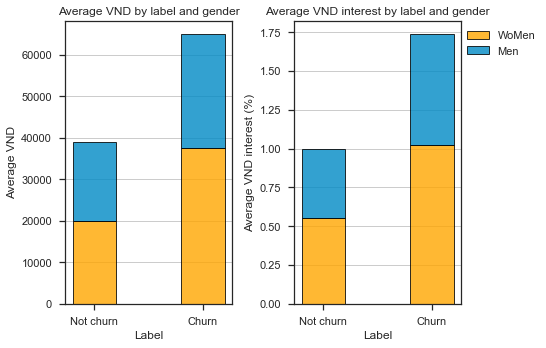

In [363]:
gender_VND = data.groupby(['GIOITINH', 'label']).avg_VND.mean().to_frame()
gender_int = data.groupby(['GIOITINH', 'label']).avg_interest.mean().to_frame()
N = 2
VND_women = [gender_VND['avg_VND'].loc[0, i] for i in range(0, 2)]
VND_men = [gender_VND['avg_VND'].loc[1, i] for i in range(0, 2)]

int_women = [gender_int['avg_interest'].loc[0, i] for i in range(0, 2)]
int_men = [gender_int['avg_interest'].loc[1, i] for i in range(0, 2)]
ind = np.arange(N)    # the x locations for the groups
width = 0.4      
sns.set(style='ticks')
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.bar(ind, VND_women, width, label="WoMen", 
             color='#ffa600', edgecolor='black', linewidth=1, alpha=0.8)
plt.bar(ind, VND_men, width, bottom=VND_women, 
             label="Men", color='#008ac5', edgecolor='black', linewidth=1, alpha=0.8)
plt.xlabel('Label')
plt.ylabel('Average VND')
plt.title('Average VND by label and gender')
plt.xticks(ind, ('Not churn', 'Churn'))
plt.grid(True, axis='y')
plt.subplot(122)
plt.bar(ind, int_women, width, label="WoMen", 
             color='#ffa600', edgecolor='black', linewidth=1, alpha=0.8)
plt.bar(ind, int_men, width, bottom=int_women, 
             label="Men", color='#008ac5', edgecolor='black', linewidth=1, alpha=0.8)
plt.xlabel('Label')
plt.ylabel('Average VND interest (%)')
plt.title('Average VND interest by label and gender')
plt.xticks(ind, ('Not churn', 'Churn'))


plt.grid(True, axis='y')
plt.legend(bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()

plt.savefig('barchart_avgVND_byGenderandInterest.png')


Đồ thị trên cho thấy các khách hàng có xu hướng rút tiền khi trung bình lãi suất cao hơn các khách hàng có lãi suất thấp. Hiện tượng này xảy ra trên cả khách hàng nam giới và nữ giới.

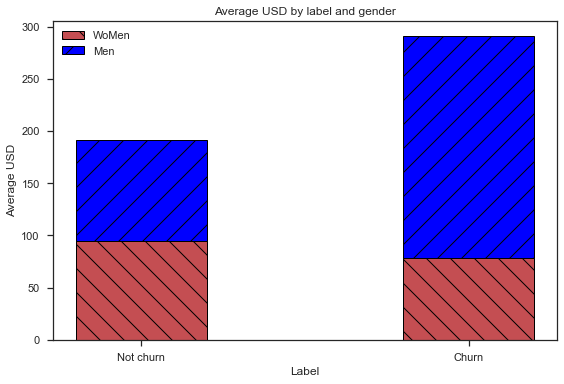

In [364]:
a = data.groupby(['GIOITINH', 'label']).avg_USD.mean().to_frame()
N = 2
avg_women = [a['avg_USD'].loc[0, i] for i in range(0, 2)]
avg_men = [a['avg_USD'].loc[1, i] for i in range(0, 2)]
ind = np.arange(N)    # the x locations for the groups
width = 0.4      

p1 = plt.bar(ind, avg_women, width, label="WoMen", 
             color='r', edgecolor='black', linewidth=1, hatch='\\')
p2 = plt.bar(ind, avg_men, width, bottom=avg_women, 
             label="Men", color='blue', edgecolor='black', linewidth=1, hatch='/')
plt.xlabel('Label')
plt.ylabel('Average USD')
plt.title('Average USD by label and gender')
plt.xticks(ind, ('Not churn', 'Churn'))

plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [365]:
con_depend_list = ['avg_VND', 'max_VND', 'min_VND', 'avg_interest']

## Modelling <a name="modelling"></a>

### Chọn lại các biến có ý nghĩa để fit vào mô hình

In [366]:
inputs_list = con_depend_list + cat_depend_list

In [367]:
str(inputs_list)

"['avg_VND', 'max_VND', 'min_VND', 'avg_interest', '0_MaGD', '11_MaGD', '15_MaGD', '1_MaGD', '2_MaGD', '3_MaGD', '4_MaGD', '6_MaGD', '7_MaGD', '8_MaGD', '00_PGD', '02_PGD', '03_PGD', '05_PGD', '06_PGD', '07_PGD', '08_PGD', 'DA_NghiepVuChiTiet', 'SA_NghiepVuChiTiet', 'GIOITINH', 'Account_Management']"

In [368]:
X = data[inputs_list]
y = data['label']

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistics Regression

In [370]:
clf = LogisticRegression()

In [371]:
clf.fit(X_train, y_train)

LogisticRegression()

In [372]:
clf.score(X_train, y_train)

0.8322139601822979

In [373]:
clf.score(X_test, y_test)

0.8285097537575952

In [374]:
clf_f1 = evaluate_model(clf, X_test, y_test)

Model LogisticRegression Performance
- Recall score: 2.2873 %.
- f1 score    : 4.45 %.


## Mô hình cho score khá tốt (trên 90%) và không bị over hoặc underfitting. Tuy nhiên recall và f1 rất thấp nên học viên sẽ chạy thử với các mô hình khác.

# Decision Tree

In [375]:
dtc = DecisionTreeClassifier(criterion='entropy')

In [376]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [377]:
dtc.score(X_test, y_test)

0.9779341221618164

In [378]:
dtc.score(X_train, y_train)

0.9979411529543456

In [379]:
dtc_f1 = evaluate_model(dtc, X_test, y_test)

Model DecisionTreeClassifier Performance
- Recall score: 94.0073 %.
- f1 score    : 93.71 %.


# Random Forest

In [380]:
list_tree = [30, 50, 70, 100, 150, 200, 500, 1000]
rfc_score = []
for tree in list_tree:
    rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rfc.fit(X_train, y_train)
    score_train = rfc.score(X_train, y_train)
    score_test = rfc.score(X_test, y_test)
    rfc_score.append(score_test)
    print('----')
    print('n_estimators = %i trees:' % tree)
    print('R squared of training model', score_train)
    print('R squared of testing model', score_test)

----
n_estimators = 30 trees:
R squared of training model 0.9975213880227073
R squared of testing model 0.9821714102974096
----
n_estimators = 50 trees:
R squared of training model 0.9978212201167346
R squared of testing model 0.9820115126319156
----
n_estimators = 70 trees:
R squared of training model 0.9979011753418086
R squared of testing model 0.9832107451231212
----
n_estimators = 100 trees:
R squared of training model 0.9978811865355401
R squared of testing model 0.9825711544611448
----
n_estimators = 150 trees:
R squared of training model 0.9979411529543456
R squared of testing model 0.982811000959386
----
n_estimators = 200 trees:
R squared of training model 0.9979411529543456
R squared of testing model 0.9827310521266389
----
n_estimators = 500 trees:
R squared of training model 0.9979411529543456
R squared of testing model 0.9824112567956508
----
n_estimators = 1000 trees:
R squared of training model 0.9979411529543456
R squared of testing model 0.9829708986248801


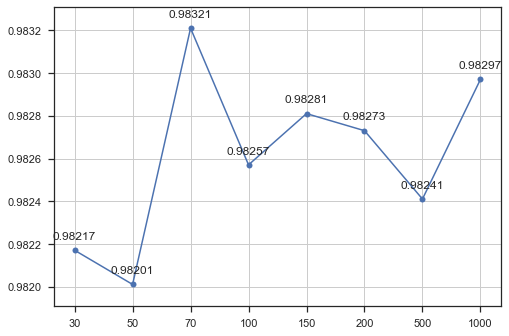

In [381]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(len(list_tree)), rfc_score, marker='o')

plt.xticks(np.arange(len(list_tree)), list_tree)

for i, v in enumerate(rfc_score):
    ax.text(i, v+0.00005, "%.5f" % v, ha="center")

plt.grid()
plt.ylim(min(rfc_score) - 0.0001, max(rfc_score) + 0.0001)
plt.show()

In [382]:
dic_score = {a:b for a, b in zip(list_tree, rfc_score)}
for tree, score in dic_score.items():
    if score == max(dic_score.values()):
        break
print('Number of the most efficiency tree:', tree)

Number of the most efficiency tree: 70


In [383]:
rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
rfc.fit(X_train, y_train)
feature_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [384]:
rfc_f1 = evaluate_model(rfc, X_test, y_test)

Model RandomForestClassifier Performance
- Recall score: 93.0467 %.
- f1 score    : 94.85 %.


# Như vậy, với RandomForestClassifier ta thấy bộ dữ liệu cho score của dữ liệu khá cao.

## Điều chỉnh các hyperparameter của mô hình Decision tree bằng GridSearchCV

In [385]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 3, 4, None],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
CV_dtc = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), 
                      param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, None],
                         'max_features': ['auto', 'sqrt', 'log2', None]})

In [386]:
print(CV_dtc.best_params_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None}


In [387]:
dtc_CVed = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_features=None)
dtc_CVed.fit(X_train, y_train)
dtc_CVed.score(X_test, y_test)
dtc_CVed.score(X_train, y_train)

0.9979411529543456

In [388]:
dtc_CVed_f1 = evaluate_model(dtc_CVed, X_test, y_test)

Model DecisionTreeClassifier Performance
- Recall score: 94.0988 %.
- f1 score    : 93.84 %.


## Điều chỉnh các hyperparameter của mô hình RandomForest bằng GridSearchCV

In [389]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

criterion = ['gini', 'entropy']

param_grid = {
    'n_estimators': [tree],
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'criterion': criterion
}

In [390]:
pprint(param_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [70]}


In [391]:
# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1), 
#                       param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# CV_rfc.fit(X_train, y_train)

In [392]:
# print(CV_rfc.best_params_)

In [393]:
pprint("{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}")

("{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', "
 "'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}")


In [394]:
rfc_CVed = RandomForestClassifier(criterion='entropy', max_depth= 20, max_features='auto',
                                  min_samples_leaf=1, min_samples_split=10, n_estimators=150, n_jobs=-1)
rfc_CVed.fit(X_train, y_train)
rfc_CVed_f1 = evaluate_model(rfc_CVed, X_test, y_test)

Model RandomForestClassifier Performance
- Recall score: 92.8179 %.
- f1 score    : 94.75 %.


## Học tăng cường bằng AdaBoostClassifier

In [395]:
ml = RandomForestClassifier(criterion='entropy', max_depth= 20, max_features='auto',
                            min_samples_leaf=1, min_samples_split=10, n_estimators=150, n_jobs=-1)
boosting = AdaBoostClassifier(n_estimators=100, 
                              base_estimator=ml, 
                              learning_rate=1)
model_boosting = boosting.fit(X_train, y_train)
print('Training model score:', model_boosting.score(X_train, y_train))
print('Testing model score:', model_boosting.score(X_test, y_test))

Training model score: 0.9979411529543456
Testing model score: 0.9822513591301567


In [396]:
model_boosting_f1 = evaluate_model(model_boosting, X_test, y_test)

Model AdaBoostClassifier Performance
- Recall score: 93.0009 %.
- f1 score    : 94.82 %.


**Nhận xét:**
Mô hình có precision của các khách hàng 'churn' là 92%. Tuy nhiên xác suất phát hiện khách hàng churn (recall) thì đạt 89% có nghĩa là 11% lượng khách hàng churn nhưng mô hình dự đoán là không (Sai lầm loại 2). 

## Imbalance handling <a name="handleImbalance"></a>

## Resample bằng Smote

In [397]:
y_train.value_counts()

0.0    41573
1.0     8455
Name: label, dtype: int64

In [398]:
data

avg_VND   min_VND     max_VND  avg_USD  min_USD  max_USD  \
0       4786.616838  1996.814  501997.314      0.0      0.0      0.0   
1        491.076354   425.364     555.064      0.0      0.0      0.0   
2        105.692233    97.762     108.762      0.0      0.0      0.0   
3      32377.561932  2091.601   72587.330      0.0      0.0      0.0   
4         63.580233    55.650      66.650      0.0      0.0      0.0   
...             ...       ...         ...      ...      ...      ...   
62531     16.803073     0.000      50.000      0.0      0.0      0.0   
62532   2599.262570    50.000   17010.050      0.0      0.0      0.0   
62533   1471.355491    43.900    8070.900      0.0      0.0      0.0   
62534    307.255362     0.000    3430.000      0.0      0.0      0.0   
62535   1231.933409    76.350   13566.387      0.0      0.0      0.0   

       avg_interest  0_MaGD  10_MaGD  11_MaGD  ...  GIOITINH  \
0          0.223046       1        0        0  ...         0   
1          0.209180       1        0        0  ...         0   
2          0.300000       1        0        0  ...         1   
3          0.217048       1        0        0  ...         1   
4          0.300000       1        0        0  ...         1   
...             ...     ...      ...      ...  ...       ...   
62531      0.200000       1        0        0  ...         0   
62532      0.200000       1        0        0  ...         0   
62533      0.200000       1        0        0  ...         1   
62534      0.200000       1        0        0  ...         0   
62535      0.200000       1        0        0  ...         1   

       Account_Management  label  avg_VND_log  min_VND_log  max_VND_log  \
0                     0.0    0.0     8.473579     7.599308    13.126350   
1                     0.0    0.0     6.196600     6.052945     6.319083   
2                     0.0    1.0     4.660531     4.582536     4.689162   
3                     0.0    0.0    10.385221     7.645685    11.192546   
4                     0.0    1.0     4.152303     4.019082     4.199455   
...                   ...    ...          ...          ...          ...   
62531                 0.0    0.0     2.821562     0.000000     3.912023   
62532                 0.0    0.0     7.862983     3.912023     9.741560   
62533                 0.0    0.0     7.293939     3.781914     8.996020   
62534                 0.0    0.0     5.727679     0.000000     8.140316   
62535                 0.0    0.0     7.116340     4.335328     9.515350   

       avg_USD_log  min_USD_log  max_USD_log  avg_interest_log  
0              0.0          0.0          0.0               0.0  
1              0.0          0.0          0.0               0.0  
2              0.0          0.0          0.0               0.0  
3              0.0          0.0          0.0               0.0  
4              0.0          0.0          0.0               0.0  
...            ...          ...          ...               ...  
62531          0.0          0.0          0.0               0.0  
62532          0.0          0.0          0.0               0.0  
62533          0.0          0.0          0.0               0.0  
62534          0.0          0.0          0.0               0.0  
62535          0.0          0.0          0.0               0.0  

[62536 rows x 48 columns]

In [399]:
X_S, y_S = SMOTE().fit_resample(X_train, y_train)
print(y_S.value_counts())

1.0    41573
0.0    41573
Name: label, dtype: int64


In [400]:
# fit Logistic Regression
clf = LogisticRegression()
clf.fit(X_S, y_S)

LogisticRegression()

In [401]:
print(confusion_matrix(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))

[[10164   158]
 [ 1508   678]]
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     10322
         1.0       0.81      0.31      0.45      2186

    accuracy                           0.87     12508
   macro avg       0.84      0.65      0.69     12508
weighted avg       0.86      0.87      0.84     12508



In [402]:
clf.score(X_test, y_test)

0.8668052446434282

In [403]:
# fit Decision tree
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_S, y_S)

DecisionTreeClassifier(criterion='entropy')

In [404]:
dtc.score(X_S, y_S)

0.9982681067038703

In [405]:
dtc.score(X_test, y_test)

0.9716981132075472

In [406]:
dtc_CVed_f1 = evaluate_model(dtc_CVed, X_test, y_test)

Model DecisionTreeClassifier Performance
- Recall score: 94.0988 %.
- f1 score    : 93.84 %.


In [407]:
# fit Random forest
list_tree = [30, 50, 70, 100, 150, 200, 500, 1000]
rfc_score = []
for tree in list_tree:
    rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rfc.fit(X_S, y_S)
    score_train = rfc.score(X_S, y_S)
    score_test = rfc.score(X_test, y_test)
    rfc_score.append(score_test)
    print('----')
    print('n_estimators = %i trees:' % tree)
    print('R squared of training model', score_train)
    print('R squared of testing model', score_test)

----
n_estimators = 30 trees:
R squared of training model 0.9981117552257475
R squared of testing model 0.98081228014071
----
n_estimators = 50 trees:
R squared of training model 0.9982079715199769
R squared of testing model 0.9811320754716981
----
n_estimators = 70 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9817716661336745
----
n_estimators = 100 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9815318196354333
----
n_estimators = 150 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9813719219699393
----
n_estimators = 200 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9816917173009274
----
n_estimators = 500 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9816917173009274
----
n_estimators = 1000 trees:
R squared of training model 0.9982681067038703
R squared of testing model 0.9812919731371922


In [408]:
dic_score = {a:b for a, b in zip(list_tree, rfc_score)}
for tree, score in dic_score.items():
    if score == max(dic_score.values()):
        break
print('Number of the most efficiency tree:', tree)

Number of the most efficiency tree: 70


In [409]:
rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
rfc.fit(X_S, y_S)

RandomForestClassifier(n_estimators=70, n_jobs=-1)

In [410]:
rfc_f1 = evaluate_model(rfc, X_test, y_test)

Model RandomForestClassifier Performance
- Recall score: 94.1446 %.
- f1 score    : 94.73 %.


**Nhận xét:**
    
    * Khi thực hiện resample bằng thư viện SMOTE cho thấy các mô hình đều đáp ứng tốt.
    * Riêng với mô hình Random forest tăng recall lên đến 93%.

## Resample bằng thư viện sklearn.utils

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [412]:
data_train = X_train.merge(y_train, on=X_train.index)

In [413]:
data_0 = data_train.loc[data_train['label']==0]
data_1 = data_train.loc[data_train['label']==1]

In [414]:
print('Rows of label 0:', data_0.shape[0])
print('Rows of label 1:', data_1.shape[0])

Rows of label 0: 41573
Rows of label 1: 8455


In [415]:
data_1_resample = resample(data_1,
                          replace=True,
                          n_samples = data_0.shape[0],
                          random_state=27)

In [416]:
print('Rows of label 1 resampling:', data_1_resample.shape[0])

Rows of label 1 resampling: 41573


In [417]:
data_upsampled_1 = pd.concat([data_1_resample, data_0])

In [418]:
X_train = data_upsampled_1[inputs_list]
y_train = data_upsampled_1['label']

In [419]:
# fit Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# fit Decision tree
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, y_train)

# fit Random forest
list_tree = [30, 50, 70, 100, 150, 200, 500, 1000]
rfc_score = []
for tree in list_tree:
    rfc = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rfc.fit(X_train, y_train)
    score_train = rfc.score(X_train, y_train)
    score_test = rfc.score(X_test, y_test)
    rfc_score.append(score_test)
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [420]:
dic_score = {a:b for a, b in zip(list_tree, rfc_score)}
for tree, score in dic_score.items():
    if score == max(dic_score.values()):
        break
print('Number of the most efficiency tree:', tree)

Number of the most efficiency tree: 200


In [421]:
evaluate_model(clf, X_test, y_test)
evaluate_model(dtc, X_test, y_test)
evaluate_model(rfc, X_test, y_test)

Model LogisticRegression Performance
- Recall score: 32.1592 %.
- f1 score    : 45.96 %.
Model DecisionTreeClassifier Performance
- Recall score: 93.9158 %.
- f1 score    : 92.96 %.
Model RandomForestClassifier Performance
- Recall score: 94.5105 %.
- f1 score    : 94.66 %.


(94.66208476517754, 94.51052150045746)

**Nhận xét:**
    
    * Khi thực hiện resample bằng thư viện sklearn.utils cho thấy các mô hình đáp ứng tốt hơn khi resample bằng SMOTE.
    * Riêng với mô hình Random forest tăng recall lên đến 94%.

# Sử dụng Robust và Standard Scaler cho các biến continuous

In [422]:
data = make_StandardScaler_column(data, con_val, prefix=True)
data = make_RobustScaler_column(data, con_val, prefix=True)

In [423]:
# Take columns that has 'scale' value
con_val_Stscale = [val for val in data.columns.tolist() if '_Stscale' in val]
con_val_Rscale = [val for val in data.columns.tolist() if '_Rscale' in val]

In [424]:
print('Range of scale:')
for col in con_val_Stscale:
    print('* ', col + ': ' + str(round(np.ptp(data[col]), 2)))

Range of scale:
*  avg_VND_Stscale: 73.62
*  min_VND_Stscale: 126.43
*  max_VND_Stscale: 101.04
*  avg_USD_Stscale: 136.95
*  min_USD_Stscale: 189.6
*  max_USD_Stscale: 117.91
*  avg_interest_Stscale: 8.48


In [425]:
print('Range of scale:')
for col in con_val_Rscale:
    print('* ', col + ': ' + str(round(np.ptp(data[col]), 2)))

Range of scale:
*  avg_VND_Rscale: 5760.43
*  min_VND_Rscale: 121423.65
*  max_VND_Rscale: 3600.09
*  avg_USD_Rscale: 619318.18
*  min_USD_Rscale: 515965.0
*  max_USD_Rscale: 700000.0
*  avg_interest_Rscale: 275.2


In [532]:
# plt.figure(figsize=(10, 6))
# for i in con_val_Rscale:
#     try:
#         sns.kdeplot(data[i])
#     except Exception:
#         pass
# plt.show()

In [534]:
# plt.figure(figsize=(10, 6))
# for i in con_val_Stscale:
#     try:
#         sns.kdeplot(data[i])
#     except Exception:
#         pass
# plt.show()

In [428]:
for i in con_val_Stscale:
    f = i + ' ~ C(label)'
    model = ols(f, data=data).fit() 
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_VND_Stscale   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.35
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.30e-12
Time:                        13:20:39   Log-Likelihood:                -88710.
No. Observations:               62536   AIC:                         1.774e+05
Df Residuals:                   62534   BIC:                         1.774e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0128      0.004     

                            OLS Regression Results                            
Dep. Variable:        max_USD_Stscale   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1246
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.724
Time:                        13:20:40   Log-Likelihood:                -88735.
No. Observations:               62536   AIC:                         1.775e+05
Df Residuals:                   62534   BIC:                         1.775e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0006      0.004     

In [429]:
for i in con_val_Rscale:
    f = i + ' ~ C(label)'
    model = ols(f, data=data).fit() 
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_VND_Rscale   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.35
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.30e-12
Time:                        13:20:40   Log-Likelihood:            -3.6135e+05
No. Observations:               62536   AIC:                         7.227e+05
Df Residuals:                   62534   BIC:                         7.227e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.3264      0.343     

                            OLS Regression Results                            
Dep. Variable:         max_USD_Rscale   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1246
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.724
Time:                        13:20:41   Log-Likelihood:            -6.3211e+05
No. Observations:               62536   AIC:                         1.264e+06
Df Residuals:                   62534   BIC:                         1.264e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         133.7421     26.062     

In [430]:
data = make_RobustScaler_column(data, con_val_log, prefix=True)
data = make_StandardScaler_column(data, con_val_log, prefix=True)

In [431]:
con_Stscaled_depend_list = [val for val in data.columns.tolist() if '_Stscale' in val and 'USD' not in val]
con_Rscaled_depend_list = [val for val in data.columns.tolist() if '_Rscale' in val and 'USD' not in val]
con_log_depend_list = [val for val in data.columns.tolist() if '_log' in val and 'USD' not in val and '_Stscale' not in val and '_Rscale' not in val]
con_log_Stscale_depend_list = [val for val in data.columns.tolist() if '_log_Stscale' in val and 'USD' not in val]
con_log_Rscaled_depend_list = [val for val in data.columns.tolist() if '_log_Rscale' in val and 'USD' not in val]

In [432]:
con_depend_list

['avg_VND', 'max_VND', 'min_VND', 'avg_interest']

## Model assessment <a name="assessment"></a>

In [433]:
inputs_list = con_depend_list + cat_depend_list
inputs_list_1 = con_log_depend_list + cat_depend_list
inputs_list_2 = con_Stscaled_depend_list + cat_depend_list
inputs_list_3 = con_Rscaled_depend_list + cat_depend_list
inputs_list_4 = con_log_Stscale_depend_list + cat_depend_list
inputs_list_5 = con_log_Rscaled_depend_list + cat_depend_list

In [434]:
df_outcomes = []
methodnames = ['none', 'smote', 'utils']
inputnames = {'inputs_list': inputs_list, 'inputs_list_1': inputs_list_1, 'inputs_list_2': inputs_list_2, 
              'inputs_list_3': inputs_list_3, 'inputs_list_4': inputs_list_4, 'inputs_list_5': inputs_list_5}

In [435]:
t_start = time.perf_counter()
for methodname in methodnames:
    for inputname in inputnames:
        t1 = time.perf_counter()
        print('Outcome of: %s, sample method: %s' % (inputname, methodname))
        df_outcome = multiModelEvaluation(data, inputnames[inputname], methodname)
        df_outcomes.append(df_outcome)
        t2 = time.perf_counter()
        print(f'It took {t2 - t1} to commplete task.')
        print('*'*40)
t_end = time.perf_counter()
print(f'It took {t_end - t_start} to commplete all tasks.')

Outcome of: inputs_list, sample method: none
Best tree:  70
Model LogisticRegression Performance
- Recall score: 2.2873 %.
- f1 score    : 4.45 %.
Model DecisionTreeClassifier Performance
- Recall score: 94.0531 %.
- f1 score    : 93.84 %.
Model RandomForestClassifier Performance
- Recall score: 93.2296 %.
- f1 score    : 95.03 %.
Model XGBClassifier Performance
- Recall score: 93.8701 %.
- f1 score    : 95.31 %.
It took 38.31014909999976 to commplete task.
****************************************
Outcome of: inputs_list_1, sample method: none
Best tree:  500
Model LogisticRegression Performance
- Recall score: 71.3632 %.
- f1 score    : 74.04 %.
Model DecisionTreeClassifier Performance
- Recall score: 91.9030 %.
- f1 score    : 87.16 %.
Model RandomForestClassifier Performance
- Recall score: 91.4913 %.
- f1 score    : 88.42 %.
Model XGBClassifier Performance
- Recall score: 91.7658 %.
- f1 score    : 88.86 %.
It took 47.40564129999984 to commplete task.
******************************

Model DecisionTreeClassifier Performance
- Recall score: 92.2232 %.
- f1 score    : 86.62 %.
Model RandomForestClassifier Performance
- Recall score: 93.6871 %.
- f1 score    : 88.09 %.
Model XGBClassifier Performance
- Recall score: 95.2882 %.
- f1 score    : 87.63 %.
It took 50.83074730000044 to commplete task.
****************************************
Outcome of: inputs_list_5, sample method: utils
Best tree:  150
Model LogisticRegression Performance
- Recall score: 92.1317 %.
- f1 score    : 70.53 %.
Model DecisionTreeClassifier Performance
- Recall score: 92.5892 %.
- f1 score    : 86.33 %.
Model RandomForestClassifier Performance
- Recall score: 93.6414 %.
- f1 score    : 87.97 %.
Model XGBClassifier Performance
- Recall score: 94.9222 %.
- f1 score    : 87.24 %.
It took 50.70937370000138 to commplete task.
****************************************
It took 895.6874976999989 to commplete all tasks.


In [436]:
from functools import reduce
df_outcome_merge = reduce(lambda left, right: pd.merge(left,right,on=['name'],
                                                       how='outer'), df_outcomes)

In [437]:
# df_outcome_merge.to_excel('benchmarkModel_c1.xlsx')

In [438]:
df_outcome_merge.set_index('name', inplace=True)

In [439]:
list_col = ['f1', 'recall', 'time_running']
df_cols = []
for methodname in methodnames:
    for inputname in inputnames:
        for col in list_col:
            name_col = col + '_' + inputname + '_' + methodname
            df_cols.append(name_col)

In [440]:
df_outcome_merge.columns = df_cols

In [441]:
df_outcome_merge

f1_inputs_list_none  recall_inputs_list_none  \
name                                                                   
LogisticRegression                 4.454343                 2.287283   
DecisionTreeClassifier            93.838430                94.053065   
RandomForestClassifier            95.033807                93.229643   
XGBClassifier                     95.308871                93.870082   

                        time_running_inputs_list_none  f1_inputs_list_1_none  \
name                                                                           
LogisticRegression                           0.556438              74.038918   
DecisionTreeClassifier                       0.297138              87.158351   
RandomForestClassifier                       1.405338              88.417330   
XGBClassifier                                1.489758              88.859358   

                        recall_inputs_list_1_none  \
name                                                
LogisticRegression                      71.363220   
DecisionTreeClassifier                  91.903019   
RandomForestClassifier                  91.491308   
XGBClassifier                           91.765782   

                        time_running_inputs_list_1_none  \
name                                                      
LogisticRegression                             0.750205   
DecisionTreeClassifier                         0.244244   
RandomForestClassifier                         8.673427   
XGBClassifier                                  1.273128   

                        f1_inputs_list_2_none  recall_inputs_list_2_none  \
name                                                                       
LogisticRegression                  73.961548                  71.271729   
DecisionTreeClassifier              93.091577                  92.772187   
RandomForestClassifier              94.214102                  91.994511   
XGBClassifier                       95.315399                  94.007319   

                        time_running_inputs_list_2_none  \
name                                                      
LogisticRegression                             0.918295   
DecisionTreeClassifier                         0.430460   
RandomForestClassifier                         3.728237   
XGBClassifier                                  1.504699   

                        f1_inputs_list_3_none  ...  \
name                                           ...   
LogisticRegression                  32.817754  ...   
DecisionTreeClassifier              93.884071  ...   
RandomForestClassifier              95.189403  ...   
XGBClassifier                       95.308871  ...   

                        time_running_inputs_list_2_utils  \
name                                                       
LogisticRegression                              1.204682   
DecisionTreeClassifier                          0.537060   
RandomForestClassifier                          2.470595   
XGBClassifier                                   2.302789   

                        f1_inputs_list_3_utils  recall_inputs_list_3_utils  \
name                                                                         
LogisticRegression                   57.704816                   85.224154   
DecisionTreeClassifier               92.766727                   93.870082   
RandomForestClassifier               95.009158                   94.922232   
XGBClassifier                        94.696283                   95.562672   

                        time_running_inputs_list_3_utils  \
name                                                       
LogisticRegression                              1.374512   
DecisionTreeClassifier                          0.521477   
RandomForestClassifier                          3.505466   
XGBClassifier                                   2.296696   

                        f1_inputs_list_4_utils  recall_inputs_list_4_utils  \
name                          

In [442]:
df_f1 = df_outcome_merge.iloc[:, range(0, df_outcome_merge.shape[1],3)]
df_recall = df_outcome_merge.iloc[:, range(1, df_outcome_merge.shape[1],3)]
df_time = df_outcome_merge.iloc[:, range(2, df_outcome_merge.shape[1],3)]

In [443]:
df_f1.max(axis=1)

name
LogisticRegression        74.038918
DecisionTreeClassifier    93.884071
RandomForestClassifier    95.189403
XGBClassifier             95.315399
dtype: float64

In [444]:
df_f1.idxmax(axis=1)

name
LogisticRegression        f1_inputs_list_1_none
DecisionTreeClassifier    f1_inputs_list_3_none
RandomForestClassifier    f1_inputs_list_3_none
XGBClassifier             f1_inputs_list_2_none
dtype: object

In [445]:
df_recall.max(axis=1)

name
LogisticRegression        92.177493
DecisionTreeClassifier    94.510522
RandomForestClassifier    94.922232
XGBClassifier             95.928637
dtype: float64

In [446]:
df_recall.idxmax(axis=1)

name
LogisticRegression        recall_inputs_list_1_utils
DecisionTreeClassifier      recall_inputs_list_smote
RandomForestClassifier    recall_inputs_list_2_utils
XGBClassifier               recall_inputs_list_utils
dtype: object

In [447]:
df_time.min(axis=1)

name
LogisticRegression        0.290599
DecisionTreeClassifier    0.244244
RandomForestClassifier    0.908746
XGBClassifier             1.254146
dtype: float64

In [448]:
df_time.idxmin(axis=1)

name
LogisticRegression          time_running_inputs_list_utils
DecisionTreeClassifier     time_running_inputs_list_1_none
RandomForestClassifier    time_running_inputs_list_3_smote
XGBClassifier              time_running_inputs_list_5_none
dtype: object

In [449]:
df_f1.min(axis=1)

name
LogisticRegression         4.454343
DecisionTreeClassifier    85.792580
RandomForestClassifier    87.629310
XGBClassifier             87.205387
dtype: float64

In [450]:
df_f1.idxmin(axis=1)

name
LogisticRegression           f1_inputs_list_none
DecisionTreeClassifier    f1_inputs_list_5_smote
RandomForestClassifier    f1_inputs_list_1_smote
XGBClassifier             f1_inputs_list_1_utils
dtype: object

In [451]:
df_recall.min(axis=1)

name
LogisticRegression         2.287283
DecisionTreeClassifier    91.903019
RandomForestClassifier    91.354071
XGBClassifier             91.765782
dtype: float64

In [452]:
df_recall.idxmin(axis=1)

name
LogisticRegression          recall_inputs_list_none
DecisionTreeClassifier    recall_inputs_list_1_none
RandomForestClassifier    recall_inputs_list_4_none
XGBClassifier             recall_inputs_list_1_none
dtype: object

In [453]:
df_time.max(axis=1)

name
LogisticRegression         1.485128
DecisionTreeClassifier     0.601377
RandomForestClassifier    20.788700
XGBClassifier              2.411312
dtype: float64

In [454]:
df_time.idxmax(axis=1)

name
LogisticRegression        time_running_inputs_list_3_smote
DecisionTreeClassifier    time_running_inputs_list_3_smote
RandomForestClassifier    time_running_inputs_list_4_smote
XGBClassifier             time_running_inputs_list_3_smote
dtype: object

**Nhận xét: Qua việc phân tích các mô hình dựa trên từng loại mô hình, các loại biến, và dữ liệu bias/unbiased**

    1. Mô hình mang lại score và recall cao nhất là XGBClassifier, các biến continuos được Robust scaling, và oversampling label theo thuật toán sklearn.utils.

# Xem xét mức độ ổn định của từng mô hình

In [455]:
X = data[inputs_list_3]
y = data['label']

models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=150),
    XGBClassifier()
]

CV = 10
entries = list()

for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X, y, cv=CV)
    predict = cross_val_predict(model, X, y)
    recall = recall_score(y, predict)
    entries.append([model_name, scores.mean(), recall])

cv_df = pd.DataFrame(entries, columns=['model_name', 'scores', 'recall'])

In [456]:
cv_df

model_name    scores    recall
0      LogisticRegression  0.853237  0.246311
1  DecisionTreeClassifier  0.975310  0.929142
2  RandomForestClassifier  0.982266  0.927544
3           XGBClassifier  0.983050  0.931209

In [457]:
data = make_RobustScaler_column(data, con_val, prefix=True)
X = data[inputs_list_3]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = X_train.merge(y_train, on=X_train.index)
data_0 = data_train.loc[data_train['label'] == 0]
data_1 = data_train.loc[data_train['label'] == 1]     

data_1_resample = resample(data_1, replace=True, n_samples = data_0.shape[0])

data_upsampled = pd.concat([data_1_resample, data_0])
X_train = data_upsampled.drop(['label', 'key_0'], axis=1)
y_train = data_upsampled['label']

rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [458]:
evaluate_model(rfc, X_test, y_test)

Model RandomForestClassifier Performance
- Recall score: 94.9680 %.
- f1 score    : 94.92 %.


(94.92455418381344, 94.967978042086)

In [459]:
prediction_proba = rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), prediction_proba[:, 1])

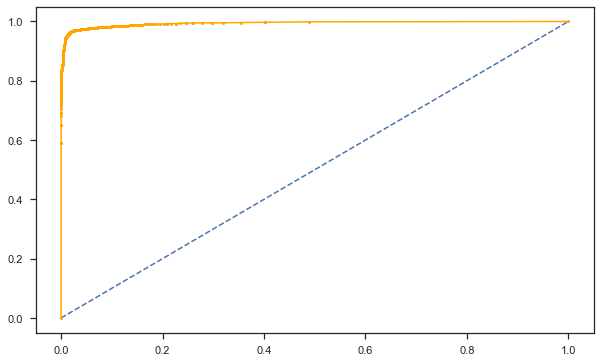

In [460]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', c='orange')
plt.show()

In [461]:
feature_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

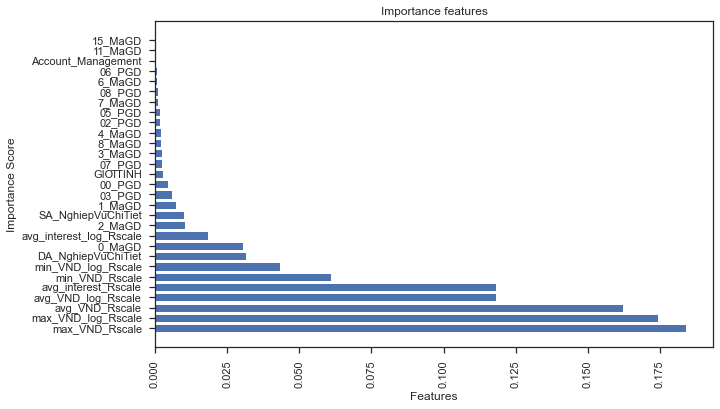

In [462]:
plt.figure(figsize=(10, 6))
plt.barh(feature_imp.index, feature_imp)
plt.xticks(rotation='vertical')
plt.title('Importance features')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [463]:
data = make_RobustScaler_column(data, con_val, prefix=True)
X = data[inputs_list_3]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = X_train.merge(y_train, on=X_train.index)
data_0 = data_train.loc[data_train['label'] == 0]
data_1 = data_train.loc[data_train['label'] == 1]     

data_1_resample = resample(data_1, replace=True, n_samples = data_0.shape[0])

data_upsampled = pd.concat([data_1_resample, data_0])
X_train = data_upsampled.drop(['label', 'key_0'], axis=1)
y_train = data_upsampled['label']

xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [464]:
evaluate_model(xgb, X_test, y_test)

Model XGBClassifier Performance
- Recall score: 95.4712 %.
- f1 score    : 94.67 %.


(94.669993195736, 95.4711802378774)

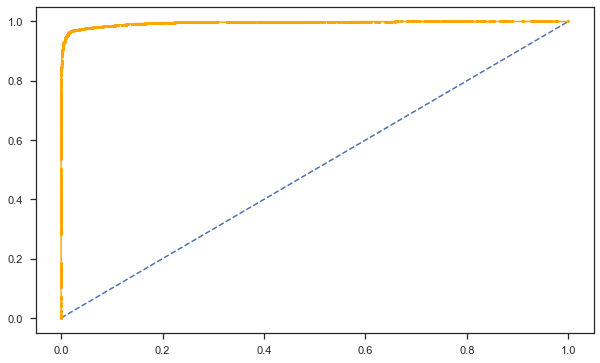

In [465]:
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', c='orange')
plt.show()

# PROPAGATION LABELLING <a name='propagation'></a>

In [466]:
from sklearn.semi_supervised import LabelPropagation

In [467]:
data_cleaned

avg_VND   min_VND     max_VND  avg_USD  min_USD  max_USD  \
0       4786.616838  1996.814  501997.314      0.0      0.0      0.0   
1        491.076354   425.364     555.064      0.0      0.0      0.0   
2        105.692233    97.762     108.762      0.0      0.0      0.0   
3      32377.561932  2091.601   72587.330      0.0      0.0      0.0   
4         63.580233    55.650      66.650      0.0      0.0      0.0   
...             ...       ...         ...      ...      ...      ...   
62531     16.803073     0.000      50.000      0.0      0.0      0.0   
62532   2599.262570    50.000   17010.050      0.0      0.0      0.0   
62533   1471.355491    43.900    8070.900      0.0      0.0      0.0   
62534    307.255362     0.000    3430.000      0.0      0.0      0.0   
62535   1231.933409    76.350   13566.387      0.0      0.0      0.0   

       avg_interest  0_MaGD  10_MaGD  11_MaGD  ...  03_PGD  05_PGD  06_PGD  \
0          0.223046       1        0        0  ...       0       0       0   
1          0.209180       1        0        0  ...       0       0       0   
2          0.300000       1        0        0  ...       0       0       0   
3          0.217048       1        0        0  ...       0       0       0   
4          0.300000       1        0        0  ...       0       0       0   
...             ...     ...      ...      ...  ...     ...     ...     ...   
62531      0.200000       1        0        0  ...       0       0       0   
62532      0.200000       1        0        0  ...       1       0       0   
62533      0.200000       1        0        0  ...       0       0       0   
62534      0.200000       1        0        0  ...       0       0       0   
62535      0.200000       1        0        0  ...       1       0       0   

       07_PGD  08_PGD  DA_NghiepVuChiTiet  SA_NghiepVuChiTiet  GIOITINH  \
0           0       0                   1                   0         0   
1           0       0                   1                   0         0   
2           0       0                   1                   0         1   
3           0       0                   1                   0         1   
4           0       0                   1                   0         1   
...       ...     ...                 ...                 ...       ...   
62531       0       0                   1                   0         0   
62532       0       0                   1                   0         0   
62533       0       0                   1                   0         1   
62534       0       0                   1                   0         0   
62535       0       0                   1                   0         1   

       Account_Management  label  
0                     0.0    0.0  
1                     0.0    0.0  
2                     0.0    1.0  
3                     0.0    0.0  
4                     0.0    1.0  
...                   ...    ...  
62531                 0.0    0.0  
62532                 0.0    0.0  
62533                 0.0    0.0  
62534                 0.0    0.0  
62535                 0.0    0.0  

[62536 rows x 52 columns]

In [513]:
X = data_cleaned.drop('label', axis = 1)
y = data_cleaned['label']

Vì phải có một tập mẫu để mô hình training nên ta sẽ chọn 10% lượng mãu từ mô hình đã gán nhãn.

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=1)

In [515]:
X_train.shape

(6253, 51)

In [516]:
model = LabelPropagation(kernel='rbf', max_iter=1000, tol=0.001, n_jobs=-1)

In [517]:
model.fit(X_train, y_train)

LabelPropagation(n_jobs=-1)

In [518]:
pred_label = model.predict(X_test)

In [519]:
# Count label == 1
np.count_nonzero(pred_label)

7398

In [520]:
recall = recall_score(y_test, pred_label) * 100
f1 = f1_score(y_test, pred_label) * 100
print(recall, f1)
print(confusion_matrix(y_test, pred_label))
print(classification_report(y_test, pred_label))

75.07592418054246 84.60494482799315
[[46505   229]
 [ 2380  7169]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46734
         1.0       0.97      0.75      0.85      9549

    accuracy                           0.95     56283
   macro avg       0.96      0.87      0.91     56283
weighted avg       0.95      0.95      0.95     56283



In [521]:
model = LabelPropagation(kernel='knn', n_neighbors=7, tol=0.01, n_jobs=-1)
model.fit(X_train, y_train)
pred_label = model.predict(X_test)
print(confusion_matrix(y_test, pred_label))
print(classification_report(y_test, pred_label))

[[46111   623]
 [ 1543  8006]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     46734
         1.0       0.93      0.84      0.88      9549

    accuracy                           0.96     56283
   macro avg       0.95      0.91      0.93     56283
weighted avg       0.96      0.96      0.96     56283



**Nhận xét:**<br>
    * Như vậy với thuật toán học bán giám sát LabelPropagation với kernel='knn' cho độ chính xác là 93% với xác suất gán nhãn đúng là 84%.

In [522]:
# Merge X_train with y_train, X_test with y_test
data_train = X_train.merge(y_train, on=X_train.index)
data_test = X_test.merge(y_test, on=X_test.index)
# Make new column pred_label
data_train['pred_label'] = data_train['label']
data_test['pred_label'] = pred_label.flatten()
# Concat 2 dataframe
data_propag_label = pd.concat([data_train, data_test])
data_propag_label

key_0        avg_VND  min_VND      max_VND  avg_USD  min_USD  max_USD  \
0      14099    3921.936750    0.000    20209.383      0.0      0.0      0.0   
1      12223    2192.909846   93.573    27719.469      0.0      0.0      0.0   
2      54544   81384.552206    0.000    83805.100      0.0      0.0      0.0   
3      39214   14615.562853   12.503  1841289.189      0.0      0.0      0.0   
4       6347    1648.916027    0.000    12228.700      0.0      0.0      0.0   
...      ...            ...      ...          ...      ...      ...      ...   
56278   9077       0.380634    0.000        2.000      0.0      0.0      0.0   
56279  34418       0.380634    0.000        2.000      0.0      0.0      0.0   
56280  35877  329588.214642    0.000   345000.000      0.0      0.0      0.0   
56281  53928       3.550000    3.550        3.550      0.0      0.0      0.0   
56282  59137    2150.458193    0.000    12757.950      0.0      0.0      0.0   

       avg_interest  0_MaGD  10_MaGD  ...  05_PGD  06_PGD  07_PGD  08_PGD  \
0          0.200614       1        0  ...       0       0       0       0   
1          0.200000       1        0  ...       0       0       1       0   
2          4.741618       0        0  ...       0       0       0       0   
3          0.200002       1        0  ...       1       0       0       0   
4          0.226527       1        0  ...       0       0       0       0   
...             ...     ...      ...  ...     ...     ...     ...     ...   
56278      0.242982       0        0  ...       0       0       0       0   
56279      0.242982       0        0  ...       0       0       0       0   
56280      6.725259       0        0  ...       0       0       0       1   
56281      0.300000       1        0  ...       0       0       0       0   
56282      0.200000       1        0  ...       0       0       0       0   

       DA_NghiepVuChiTiet  SA_NghiepVuChiTiet  GIOITINH  Account_Management  \
0                       1                   0         1                 0.0   
1                       1                   0         1                 0.0   
2                       0                   1         0                 0.0   
3                       1                   0         1                 0.0   
4                       1                   0         0                 0.0   
...                   ...                 ...       ...                 ...   
56278                   1                   0         0                 0.0   
56279                   1                   0         1                 0.0   
56280                   0                   1         0                 0.0   
56281                   1                   0         0                 0.0   
56282                   1                   0         1                 0.0   

       label  pred_label  
0        0.0         0.0  
1        0.0         0.0  
2        1.0         1.0  
3        0.0         0.0  
4        0.0         0.0  
...      ...         ...  
56278    0.0         0.0  
56279    0.0         0.0  
56280    0.0         1.0  
56281    1.0         1.0  
56282    0.0         0.0  

[62536 rows x 54 columns]

In [523]:
# Drop the key_0 and label
data_propag_label.drop(['key_0', 'label'] , axis=1, inplace=True)

In [524]:
data_propag_label.rename(columns={'pred_label':'label'}, inplace=True)

In [525]:
data_propag_label.head(5)

avg_VND  min_VND      max_VND  avg_USD  min_USD  max_USD  \
0   3921.936750    0.000    20209.383      0.0      0.0      0.0   
1   2192.909846   93.573    27719.469      0.0      0.0      0.0   
2  81384.552206    0.000    83805.100      0.0      0.0      0.0   
3  14615.562853   12.503  1841289.189      0.0      0.0      0.0   
4   1648.916027    0.000    12228.700      0.0      0.0      0.0   

   avg_interest  0_MaGD  10_MaGD  11_MaGD  ...  03_PGD  05_PGD  06_PGD  \
0      0.200614       1        0        0  ...       1       0       0   
1      0.200000       1        0        0  ...       0       0       0   
2      4.741618       0        0        0  ...       0       0       0   
3      0.200002       1        0        0  ...       0       1       0   
4      0.226527       1        0        0  ...       0       0       0   

   07_PGD  08_PGD  DA_NghiepVuChiTiet  SA_NghiepVuChiTiet  GIOITINH  \
0       0       0                   1                   0         1   
1       1       0                   1                   0         1   
2       0       0                   0                   1         0   
3       0       0                   1                   0         1   
4       0       0                   1                   0         0   

   Account_Management  label  
0                 0.0    0.0  
1                 0.0    0.0  
2                 0.0    1.0  
3                 0.0    0.0  
4                 0.0    0.0  

[5 rows x 52 columns]

In [526]:
data_propag_label.to_csv('data_cleaned_propag_label.csv')

## Evaluate Model

In [481]:
data_propag_label = make_log_column(data_propag_label, con_val, prefix=True)
data_propag_label = make_RobustScaler_column(data_propag_label, con_val, prefix=True)
data_propag_label = make_StandardScaler_column(data_propag_label, con_val, prefix=True)
data_propag_label = make_RobustScaler_column(data_propag_label, con_val_log, prefix=True)
data_propag_label = make_StandardScaler_column(data_propag_label, con_val_log, prefix=True)

In [482]:
df_outcomes_propag = []
t_start = time.perf_counter()
for methodname in methodnames:
    for inputname in inputnames:
        t1 = time.perf_counter()
        print('Outcome of: %s, sample method: %s' % (inputname, methodname))
        df_outcome = multiModelEvaluation(data_propag_label, inputnames[inputname], methodname)
        df_outcomes_propag.append(df_outcome)
        t2 = time.perf_counter()
        print(f'It took {t2 - t1} to commplete task.')
        print('*'*40)
t_end = time.perf_counter()
print(f'It took {t_end - t_start} to commplete all tasks.')

Outcome of: inputs_list, sample method: none
Best tree:  500
Model LogisticRegression Performance
- Recall score: 2.3980 %.
- f1 score    : 4.65 %.
Model DecisionTreeClassifier Performance
- Recall score: 96.1735 %.
- f1 score    : 95.90 %.
Model RandomForestClassifier Performance
- Recall score: 95.4592 %.
- f1 score    : 96.05 %.
Model XGBClassifier Performance
- Recall score: 96.4286 %.
- f1 score    : 96.68 %.
It took 51.257125899999664 to commplete task.
****************************************
Outcome of: inputs_list_1, sample method: none
Best tree:  50
Model LogisticRegression Performance
- Recall score: 74.6939 %.
- f1 score    : 75.33 %.
Model DecisionTreeClassifier Performance
- Recall score: 89.9490 %.
- f1 score    : 89.77 %.
Model RandomForestClassifier Performance
- Recall score: 88.8265 %.
- f1 score    : 89.35 %.
Model XGBClassifier Performance
- Recall score: 90.1531 %.
- f1 score    : 90.55 %.
It took 43.03447479999886 to commplete task.
*****************************

Model DecisionTreeClassifier Performance
- Recall score: 95.7143 %.
- f1 score    : 83.47 %.
Model RandomForestClassifier Performance
- Recall score: 95.7653 %.
- f1 score    : 86.26 %.
Model XGBClassifier Performance
- Recall score: 97.6020 %.
- f1 score    : 86.86 %.
It took 63.73623790000056 to commplete task.
****************************************
Outcome of: inputs_list_5, sample method: utils
Best tree:  70
Model LogisticRegression Performance
- Recall score: 98.3163 %.
- f1 score    : 64.25 %.
Model DecisionTreeClassifier Performance
- Recall score: 95.2551 %.
- f1 score    : 83.57 %.
Model RandomForestClassifier Performance
- Recall score: 95.8163 %.
- f1 score    : 86.70 %.
Model XGBClassifier Performance
- Recall score: 97.7551 %.
- f1 score    : 87.25 %.
It took 64.92726679999942 to commplete task.
****************************************
It took 1026.9962962999998 to commplete all tasks.


In [483]:
from functools import reduce
df_outcome_merge_propag = reduce(lambda left, right: pd.merge(left,right,on=['name'],
                                                       how='outer'), df_outcomes_propag)
df_outcome_merge_propag.set_index('name', inplace=True)
df_outcome_merge_propag.columns = df_cols
df_f1 = df_outcome_merge_propag.iloc[:, range(0, df_outcome_merge_propag.shape[1],3)]
df_recall = df_outcome_merge_propag.iloc[:, range(1, df_outcome_merge_propag.shape[1],3)]
df_time = df_outcome_merge_propag.iloc[:, range(2, df_outcome_merge_propag.shape[1],3)]

In [484]:
print(df_f1.max(axis=1))
print(df_f1.idxmax(axis=1))

name
LogisticRegression        77.995268
DecisionTreeClassifier    96.010165
RandomForestClassifier    96.595854
XGBClassifier             96.675192
dtype: float64
name
LogisticRegression        f1_inputs_list_2_smote
DecisionTreeClassifier     f1_inputs_list_2_none
RandomForestClassifier     f1_inputs_list_3_none
XGBClassifier                f1_inputs_list_none
dtype: object


In [485]:
df_time['time_running_inputs_list_none']

name
LogisticRegression        0.540858
DecisionTreeClassifier    0.267202
RandomForestClassifier    9.180546
XGBClassifier             1.295821
Name: time_running_inputs_list_none, dtype: float64

In [486]:
print(df_recall.max(axis=1))
print(df_recall.idxmax(axis=1))

name
LogisticRegression        98.418367
DecisionTreeClassifier    96.377551
RandomForestClassifier    97.040816
XGBClassifier             97.806122
dtype: float64
name
LogisticRegression        recall_inputs_list_1_utils
DecisionTreeClassifier     recall_inputs_list_2_none
RandomForestClassifier    recall_inputs_list_3_smote
XGBClassifier             recall_inputs_list_1_utils
dtype: object


In [487]:
df_time['time_running_inputs_list_1_utils']

name
LogisticRegression        1.131939
DecisionTreeClassifier    0.585461
RandomForestClassifier    5.604365
XGBClassifier             2.196301
Name: time_running_inputs_list_1_utils, dtype: float64

In [488]:
print(df_time.min(axis=1))
print(df_time.idxmin(axis=1))

name
LogisticRegression        0.386699
DecisionTreeClassifier    0.207480
RandomForestClassifier    1.117325
XGBClassifier             1.260175
dtype: float64
name
LogisticRegression         time_running_inputs_list_utils
DecisionTreeClassifier    time_running_inputs_list_5_none
RandomForestClassifier    time_running_inputs_list_1_none
XGBClassifier             time_running_inputs_list_1_none
dtype: object


In [489]:
df_recall['recall_inputs_list_4_none']

name
LogisticRegression        74.591837
DecisionTreeClassifier    89.897959
RandomForestClassifier    89.285714
XGBClassifier             90.153061
Name: recall_inputs_list_4_none, dtype: float64

In [490]:
print(df_f1.min(axis=1))
print(df_f1.idxmin(axis=1))

name
LogisticRegression         4.646565
DecisionTreeClassifier    83.325923
RandomForestClassifier    86.259191
XGBClassifier             86.663653
dtype: float64
name
LogisticRegression           f1_inputs_list_none
DecisionTreeClassifier    f1_inputs_list_1_utils
RandomForestClassifier    f1_inputs_list_4_utils
XGBClassifier             f1_inputs_list_1_utils
dtype: object


In [491]:
print(df_recall.min(axis=1))
print(df_recall.idxmin(axis=1))

name
LogisticRegression         2.397959
DecisionTreeClassifier    89.897959
RandomForestClassifier    88.826531
XGBClassifier             90.153061
dtype: float64
name
LogisticRegression          recall_inputs_list_none
DecisionTreeClassifier    recall_inputs_list_4_none
RandomForestClassifier    recall_inputs_list_1_none
XGBClassifier             recall_inputs_list_1_none
dtype: object


In [492]:
print(df_time.max(axis=1))
print(df_time.idxmax(axis=1))

name
LogisticRegression         1.521250
DecisionTreeClassifier     1.063057
RandomForestClassifier    15.335855
XGBClassifier              2.668147
dtype: float64
name
LogisticRegression        time_running_inputs_list_3_utils
DecisionTreeClassifier    time_running_inputs_list_2_utils
RandomForestClassifier    time_running_inputs_list_2_utils
XGBClassifier             time_running_inputs_list_2_utils
dtype: object


<https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5>

## LIME <a name='lime'></a>

In [493]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [494]:
data = make_RobustScaler_column(data, con_val, prefix=True)
X = data[inputs_list].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_metric='auc', 
        eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.98311
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.98683
[2]	validation_0-auc:0.98843
[3]	validation_0-auc:0.98918
[4]	validation_0-auc:0.98974
[5]	validation_0-auc:0.99067
[6]	validation_0-auc:0.99145
[7]	validation_0-auc:0.99247
[8]	validation_0-auc:0.99258
[9]	validation_0-auc:0.99282
[10]	validation_0-auc:0.99312
[11]	validation_0-auc:0.99327
[12]	validation_0-auc:0.99339
[13]	validation_0-auc:0.99348
[14]	validation_0-auc:0.99360
[15]	validation_0-auc:0.99377
[16]	validation_0-auc:0.99377
[17]	validation_0-auc:0.99394
[18]	validation_0-auc:0.99414
[19]	validation_0-auc:0.99413
[20]	validation_0-auc:0.99445
[21]	validation_0-auc:0.99452
[22]	validation_0-auc:0.99450
[23]	validation_0-auc:0.99459
[24]	validation_0-auc:0.99461
[25]	validation_0-auc:0.99476
[26]	validation_0-auc:0.99475
[27]	validation_0-auc:0.99468
[28]	validation_0-auc:0.99463
[29]	validation_0-auc:0.99459
[30]	validation_0-auc:0.99479
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [495]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=inputs_list,
                                                   mode='classification', class_names=['Not churn', 'Churn'],
                                                   categorical_features=cat_depend_list, discretize_continuous=True,
                                                   training_labels=y)

In [496]:
xgb.predict_proba(X_test)

array([[9.95113611e-01, 4.88640927e-03],
       [9.98407960e-01, 1.59206858e-03],
       [9.99694824e-01, 3.05168505e-04],
       ...,
       [6.96452618e-01, 3.03547382e-01],
       [9.99887526e-01, 1.12483416e-04],
       [9.96155262e-01, 3.84476036e-03]], dtype=float32)

In [497]:
# asking for explanation for LIME model
for i in range(0, 2):
    exp = explainer.explain_instance(X_train[i], xgb.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)

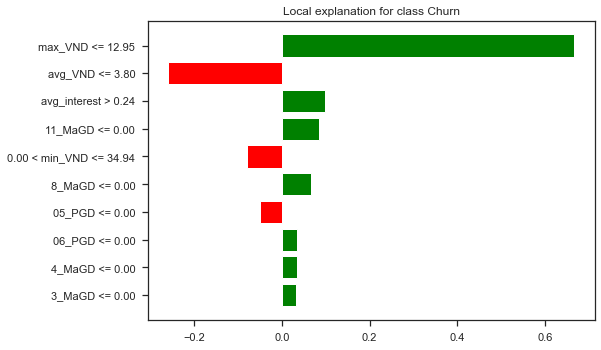

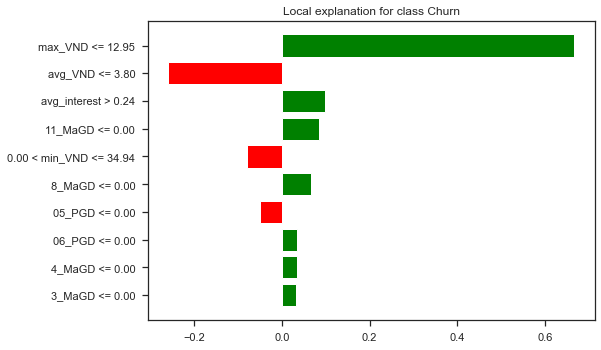

In [498]:
exp = explainer.explain_instance(X_train[15], xgb.predict_proba, num_features=10)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

In [499]:
exp = explainer.explain_instance(X_train[20], xgb.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)
# exp.save_to_file('prediction_lime_notchurn.png')

In [500]:
# Chuyển các data frame thành ma trân
# SP-LIME trả về các biến giải thích trên một tập mẫu được lấy theo phương pháp submodular 
t1 = time.perf_counter()
sp_obj = submodular_pick.SubmodularPick(explainer, X_train, 
                                        xgb.predict_proba, 
                                        num_features=5, 
                                        num_exps_desired=10, sample_size=500)
t2 = time.perf_counter()

In [501]:
print((t2-t1)/60)

31.247873319999993


In [502]:
# Tạo một dataframe với 10 mẫu
W_pick = pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)

In [503]:
W_pick

max_VND <= 12.95  avg_VND <= 3.80  8_MaGD <= 0.00  min_VND <= 0.00  \
0         -0.678768         0.255852       -0.129557        -0.088193   
1          0.000000         0.000000        0.000000         0.000000   
2          0.000000         0.000000        0.000000         0.000000   
3          0.000000         0.000000        0.000000        -0.080750   
4          0.000000         0.258262        0.000000        -0.100981   
5          0.000000         0.000000        0.000000         0.000000   
6          0.000000         0.000000        0.000000         0.000000   
7          0.000000         0.000000        0.000000         0.000000   
8          0.000000         0.000000        0.000000         0.000000   
9          0.000000         0.000000        0.000000        -0.082912   

   avg_interest > 0.24  max_VND > 21596.27  avg_VND > 2277.58  7_MaGD <= 0.00  \
0            -0.074906            0.000000           0.000000        0.000000   
1             0.000000            0.426945          -0.383248       -0.093293   
2             0.000000            0.000000           0.000000        0.000000   
3             0.000000            0.000000           0.000000        0.000000   
4            -0.087839            0.000000           0.000000        0.000000   
5             0.000000            0.000000           0.000000        0.000000   
6             0.000000            0.000000           0.000000        0.000000   
7             0.000000            0.000000           0.000000        0.000000   
8             0.000000            0.000000           0.000000        0.000000   
9             0.000000            0.000000           0.000000        0.000000   

   avg_interest <= 0.20  min_VND > 34.94  ...  2_MaGD <= 0.00  02_PGD <= 0.00  \
0              0.000000         0.000000  ...        0.000000        0.000000   
1              0.090506         0.051797  ...        0.000000        0.000000   
2              0.000000         0.000000  ...        0.000000        0.000000   
3              0.000000         0.000000  ...        0.000000        0.000000   
4              0.000000         0.000000  ...        0.000000        0.000000   
5              0.000000         0.054881  ...        0.000000        0.000000   
6              0.000000         0.065786  ...        0.078942        0.049444   
7              0.000000         0.049692  ...        0.000000        0.000000   
8              0.093882         0.034730  ...        0.000000        0.000000   
9              0.098816         0.000000  ...        0.000000        0.000000   

   0.00 < 0_MaGD <= 1.00  05_PGD <= 0.00  07_PGD <= 0.00  \
0               0.000000         0.00000        0.000000   
1               0.000000         0.00000        0.000000   
2               0.000000         0.00000        0.000000   
3               0.000000         0.00000        0.000000   
4               0.000000         0.00000        0.000000   
5               0.000000         0.00000        0.000000   
6              -0.024522         0.00000        0.000000   
7               0.000000         0.09906        0.072352   
8               0.000000         0.00000        0.000000   
9               0.000000         0.00000        0.000000   

   0.00 < GIOITINH <= 1.00  11_MaGD <= 0.00  00_PGD <= 0.00  4_MaGD <= 0.00  \
0                 0.000000          0.00000        0.000000        0.000000   
1                 0.000000          0.00000        0.000000        0.000000   
2                 0.000000          0.00000        0.000000        0.000000   
3                 0.000000          0.00000        0.000000        0.000000   
4                 0.000000          0.00000        0.000000        0.000000   
5                 0.000000          0.00000        0.000000        0.000000   
6                 0.000000          0.00000        0.000000        0.000000   
7                 0.034188          0.00000        0.000000        0.000000   
8                 0.000000          0.21151

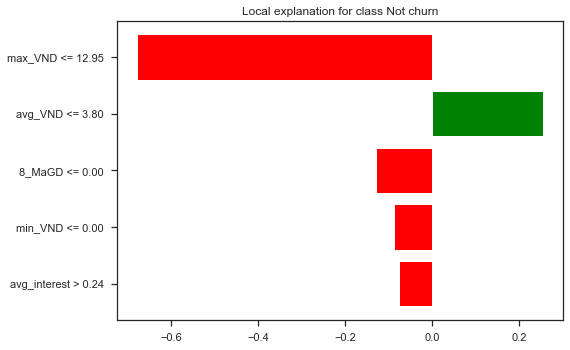

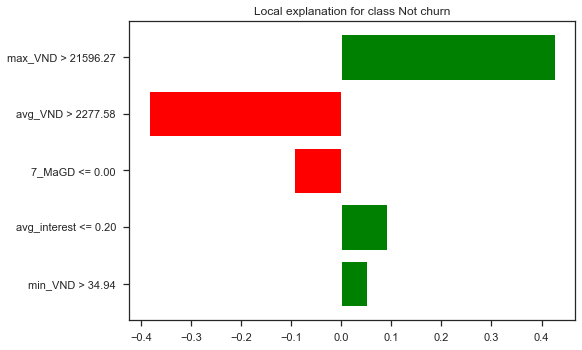

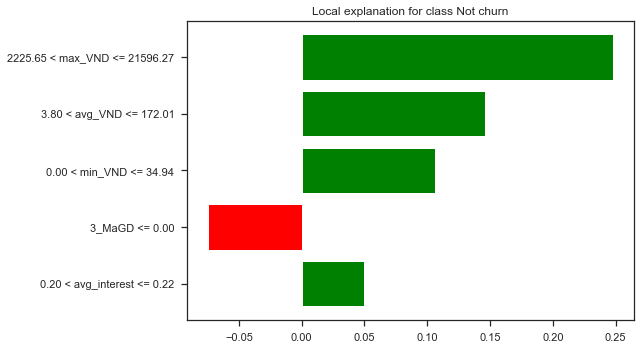

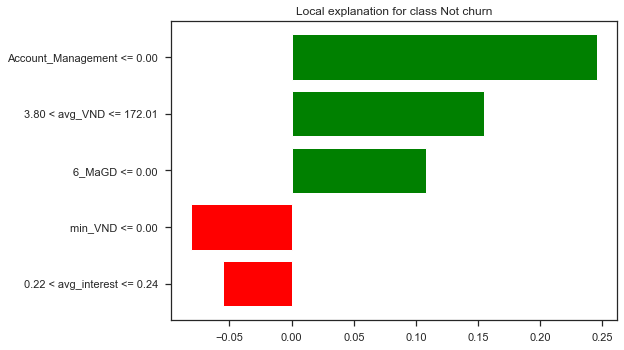

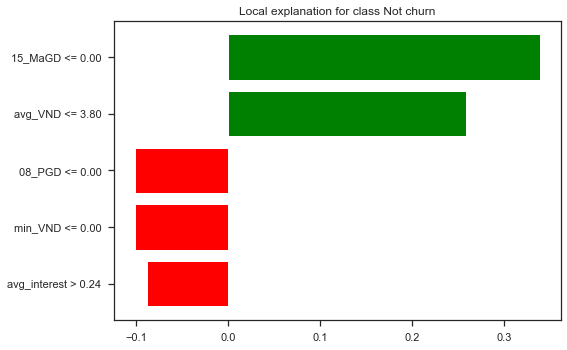

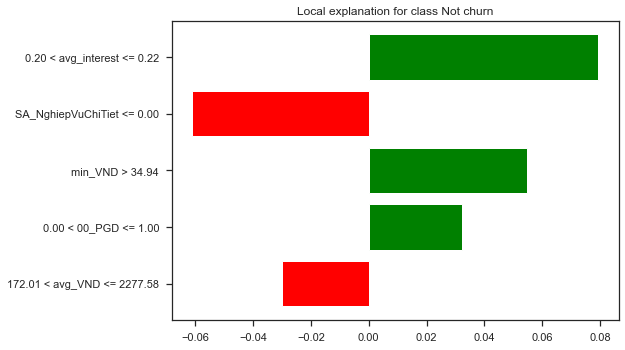

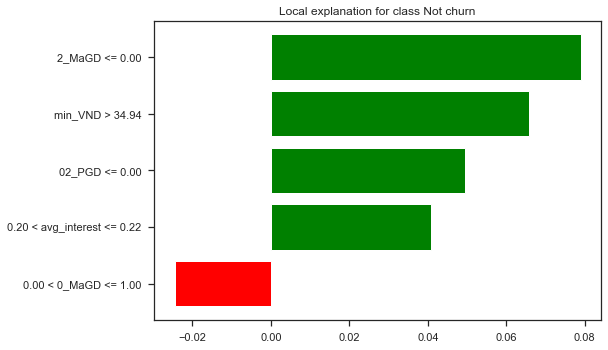

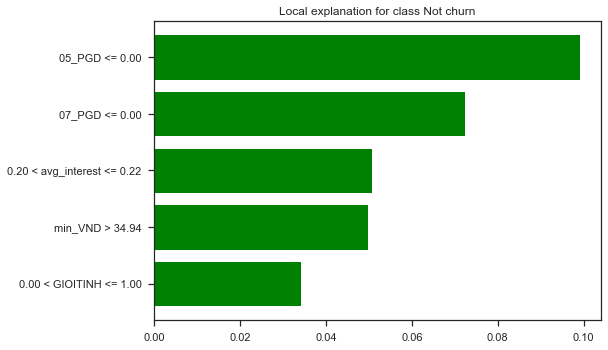

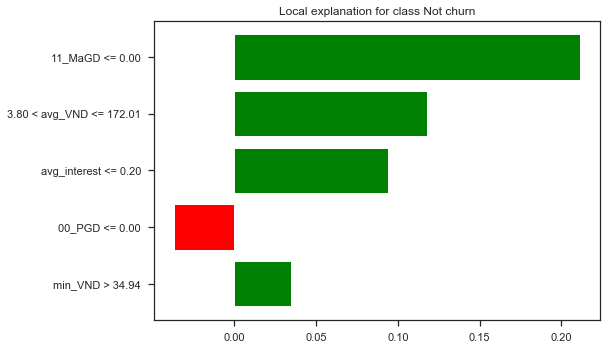

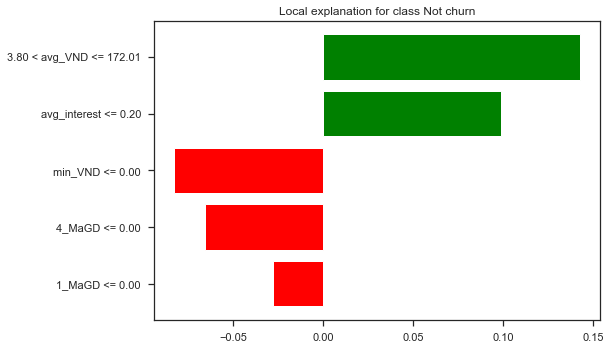

In [504]:
# In 10 mẫu
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [505]:
# Tạo một dataframe với 1000 mẫu và tất cả các biến giải thích
W = pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]

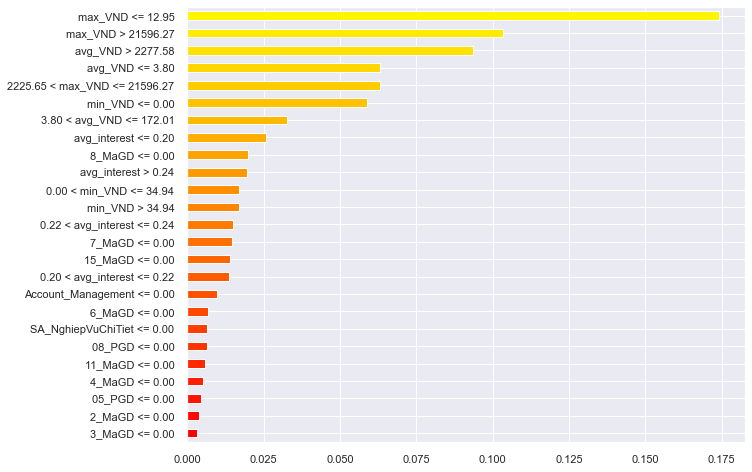

In [506]:
# Vẽ 25 nhân tố quan trọng nhất
plt.figure(figsize=(10, 8))
colors = cm.autumn(np.arange(25) / 25.0)
sns.set()
np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False)\
.head(25).sort_values(ascending=True).plot(kind="barh", color=colors)

plt.show()

In [507]:
# Vẽ theo phân loại churn - not churn cho trung bình các thuộc tính có ý nghĩa nhất trong tập đại diện.

# Trung bình
grped_coeff = W.groupby("prediction").mean()
sns.set()

# Chuyển vị
grped_coeff = grped_coeff.T

# Trị tuyệt đối
grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
grped_coeff.sort_values("abs", inplace=True, ascending=False)
a = grped_coeff.head(20).sort_values("abs", ascending=True).drop("abs", axis=1)

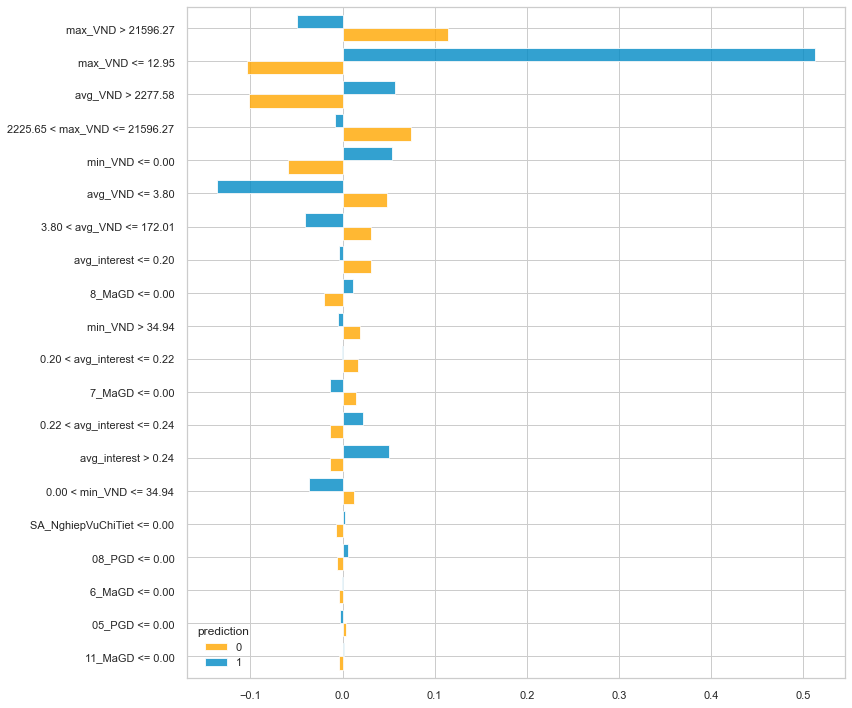

In [508]:
sns.set(style='whitegrid')
a.plot(kind="barh", figsize=(12,10), alpha=0.8, color=['#ffa600', '#008ac5'], width=0.8, grid='y', position=0.5)
plt.tight_layout()
plt.savefig('lime_breakdown.png');